In [1085]:
import pandas as pd
import numpy as np
#import utils
import io
import os
from os import listdir
import json
from ipywidgets import IntProgress
from IPython.display import display
import itertools
import matplotlib.pyplot as plt
import time
from datetime import datetime
import math
import unidecode
import requests
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from scipy.stats import poisson,skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm, skew, pearsonr #for some statistics
from bs4 import BeautifulSoup
import re
import sys, getopt
import csv
import random
from collections import Counter
pd.set_option('display.max_columns', None)

pd.options.display.max_columns=999
pd.options.display.max_rows=100

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
### Function to scrape FBRef for the last five games
### Functions to make finished spreadsheets for plain xG and p90 xG, respectively
def scrapeURL(url, homeoraway):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")

    if (homeoraway == "home"):
        summary_table = all_tables[0] # 'player', minutes', 'goals', 'assists', 'shots_total', shots_on_target', 'xg', 'xa'
        passing_table = all_tables[1] # 'assisted_shots', 'passes_completed'
        misc_table = all_tables[5] # 'crosses' ,'fouled', 'fouls', 'tackles_won', 'interceptions', 'cards_yellow', 'cards_red'
    elif (homeoraway == "away"):
        summary_table = all_tables[7]
        passing_table = all_tables[8]
        misc_table = all_tables[12]
    else:
        return("Have to supply home or away")

    # parse each table and create dict
    pre_df_player = dict()
    features_from_summary =["shirtnumber", "minutes", "goals", "assists", "shots_total", "shots_on_target", "xg", "xa"]
    features_from_passing = ["assisted_shots", "passes_completed"]
    features_from_misc = ["crosses", "fouled", "fouls", "tackles_won", "interceptions", "cards_yellow"]

    rows_summary = summary_table.find_all('tr')
    rows_passing = passing_table.find_all('tr')
    rows_misc = misc_table.find_all('tr')
    for row in range(len(rows_summary)):
        # get the names of each player
        cell = rows_summary[row].find("th", {"data-stat": "player"})
        text = cell.text.strip()
        text = unidecode.unidecode(text)
        if "player" in pre_df_player:
            pre_df_player["player"].append(text)
        else:
            pre_df_player["player"] = [text]

        for feature in features_from_summary:
            cell = rows_summary[row].find("td", {"data-stat": feature})
            if cell.text == "":
                stat = 0.0
            else:
                stat = float(cell.text)
            if feature in pre_df_player:
                pre_df_player[feature].append(stat)
            else:
                pre_df_player[feature] = [stat]

        for feature in features_from_passing:
            cell = rows_passing[row].find("td", {"data-stat": feature})
            if cell.text == "":
                stat = 0.0
            else:
                stat = float(cell.text)
            if feature in pre_df_player:
                pre_df_player[feature].append(stat)
            else:
                pre_df_player[feature] = [stat]

        for feature in features_from_misc:
            cell = rows_misc[row].find("td", {"data-stat": feature})
            if cell.text == "":
                stat = 0.0
            else:
                stat = float(cell.text)
            if feature in pre_df_player:
                pre_df_player[feature].append(stat)
            else:
                pre_df_player[feature] = [stat]

    df_player = pd.DataFrame.from_dict(pre_df_player)
    df_player = df_player.set_index("player").sort_values(by="player")
    
    df_player['starts'] = 0
    df_player['Start_Mins'] = 0
    df_player['subs'] = 0
    df_player['Sub_Mins'] = 0
    df_player['FPTS'] = df_player['goals']*10 + df_player['assists']*6 + \
                        df_player['shots_total'] + df_player['shots_on_target'] + \
                        df_player['assisted_shots'] + df_player['passes_completed']*0.02 + \
                        df_player['crosses']*0.7 + df_player['fouled'] - \
                        df_player['fouls']*0.5 + df_player['tackles_won'] + \
                        df_player['interceptions']*0.5 - df_player['cards_yellow']*1.5
    df_player['FPTS_xG'] = df_player['xg']*10 + df_player['xa']*6 + \
                        df_player['shots_total'] + df_player['shots_on_target'] + \
                        df_player['assisted_shots'] + df_player['passes_completed']*0.02 + \
                        df_player['crosses']*0.7 + df_player['fouled'] - \
                        df_player['fouls']*0.5 + df_player['tackles_won'] + \
                        df_player['interceptions']*0.5 - df_player['cards_yellow']*1.5
    
    df_player['FPTS_min'] = np.nan
    df_player['FPTS_xG_min'] = np.nan
    for name in df_player.index:
        df_player.loc[name,'FPTS_min'] = ( df_player.loc[name]['FPTS'] / max(30,df_player.loc[name]['minutes']) )*90
        df_player.loc[name,'FPTS_xG_min'] = ( df_player.loc[name]['FPTS_xG'] / max(30,df_player.loc[name]['minutes']) )*90
    for name in df_player.index:
        if (df_player.loc[name]['minutes'] >= 45):
            df_player.loc[name, 'starts'] = 1
            df_player.loc[name, 'Start_Mins'] = df_player.loc[name]['minutes']
        else:
            df_player.loc[name, 'subs'] = 1
            df_player.loc[name, 'Sub_Mins'] = df_player.loc[name]['minutes'] 
    return(df_player)
    #return(pre_df_player)



def make_finished_spreadsheet(starters, team_names, team_abbrevs, predictions_matrix, model, date):
    starters["90s"] = starters["90s"].astype('float')
    for i in range(len(starters)):
        if starters["90s"][i] > 67.5:
            starters["90s"][i] = starters["90s"][i]/90
        else:
            starters["90s"][i] = 0.75
    starters["Floor"] = (starters["Sh"] + starters["SoT"] + starters["Crs"]*0.7 + starters["KP"] + starters["Pass_Cmp"]*0.02 + starters["Fld"] - starters["Fls"]*0.5 + starters["TklW"] + starters["Int"]*0.5) / starters["90s"]
    starters["FPTS"] = (starters["Gls"]*10 + starters["Ast"]*6 + starters["Sh"] + starters["SoT"] + starters["Crs"]*0.7 + starters["KP"] + starters["Pass_Cmp"]*0.02 + starters["Fld"] - starters["Fls"]*0.5 + starters["TklW"] + starters["Int"]*0.5 - starters["CrdY"]*1.5) / starters["90s"]

    # Minutes (to simplify some calculations)
    starters["Proj_Mins"] = 0.1
    for i in range(len(starters)):
        if (starters["Starting"][i] == "y"):
            starters["Proj_Mins"][i] = starters["Start_Mins"][i]
        else:
            starters["Proj_Mins"][i] = starters["Sub_Mins"][i]

    starters_final = pd.DataFrame()
    for game_i in range(len(team_abbrevs)):
        home_name = team_names[game_i][0]
        away_name = team_names[game_i][1]
        home_abbrev = team_abbrevs[game_i][0]
        away_abbrev = team_abbrevs[game_i][1]
        game_starters = starters[(starters['Team'] == home_abbrev) | (starters['Team'] == away_abbrev)]
        game_starters = game_starters.reset_index().drop(columns=['index'])
        game_preds = predictions_matrix[(predictions_matrix['Team'] == home_name) | (predictions_matrix['Team'] == away_name)]
        game_preds = game_preds.reset_index().drop(columns=['index'])
        # xG
        game_starters["xG_p90"] = game_starters['xG']/game_starters['90s'] # create a p90 column for the stat
        game_starters["Raw_Goals"] = game_starters["xG_p90"] * (starters['Proj_Mins']/90) # this is (stat_p90)*projmins
        home_stat = sum(game_starters[game_starters['Team'] == home_abbrev]["Raw_Goals"]) # get the sum (stat_p90)*proj_mins for each team
        away_stat = sum(game_starters[game_starters['Team'] == away_abbrev]["Raw_Goals"])
        game_starters['Goal_Share'] = 0.1
        for i in range(len(game_starters['Player'])):
            if (game_starters['Team'][i] == home_abbrev):
                game_starters['Goal_Share'][i] = game_starters['Raw_Goals'][i] / home_stat
            else:
                game_starters['Goal_Share'][i] = game_starters['Raw_Goals'][i] / away_stat
        game_starters['Team_Goal_Proj'] = 0.1
        #print(game_preds)
        for i in range(len(game_starters['Player'])):
            if (game_starters["Team"][i] == home_abbrev):
                game_starters["Team_Goal_Proj"][i] = game_preds["Real_Goals"][0]
            else:
                game_starters["Team_Goal_Proj"][i] = game_preds["Real_Goals"][1]
        game_starters['Proj_Gls'] = game_starters['Goal_Share'] * game_starters['Team_Goal_Proj']

        # xA
        game_starters["xA_p90"] = game_starters['xA']/game_starters['90s'] # create a p90 column for the stat
        game_starters["Raw_Ast"] = game_starters["xA_p90"] * (game_starters['Proj_Mins']/90) # this is (stat_p90)*projmins
        home_stat = sum(game_starters[game_starters['Team'] == home_abbrev]["Raw_Ast"]) # get the sum (stat_p90)*proj_mins for each team
        away_stat = sum(game_starters[game_starters['Team'] == away_abbrev]["Raw_Ast"])
        game_starters['Ast_Share'] = 0.1
        for i in range(len(game_starters['Player'])):
            if (game_starters['Team'][i] == home_abbrev):
                game_starters['Ast_Share'][i] = game_starters['Raw_Ast'][i] / home_stat
            else:
                game_starters['Ast_Share'][i] = game_starters['Raw_Ast'][i] / away_stat
        game_starters['Team_Ast_Proj'] = 0.1
        for i in range(len(game_starters['Player'])):
            if (game_starters["Team"][i] == home_abbrev):
                game_starters["Team_Ast_Proj"][i] = game_preds["Real_Goals"][0]
            else:
                game_starters["Team_Ast_Proj"][i] = game_preds["Real_Goals"][1]
        game_starters['Proj_Ast'] = game_starters['Ast_Share'] * game_starters['Team_Ast_Proj']


        # NonGoal Stats
        statnames = ['Sh', 'SoT', 'KP', 'Fls', 'Fld', 'Crs', 'TklW', 'Int']
        for stat in statnames:
            game_starters[stat+"_p90"] = game_starters[stat]/game_starters['90s'] # create a p90 column for the stat
            game_starters["Raw_"+stat] = game_starters[stat+"_p90"] * game_starters['Proj_Mins'] # this is (stat_p90)*projmins
            home_stat = sum(game_starters[game_starters['Team'] == home_abbrev]["Raw_"+stat]) # get the sum (stat_p90)*proj_mins for each team
            away_stat = sum(game_starters[game_starters['Team'] == away_abbrev]["Raw_"+stat])
            game_starters[stat+'_Share'] = 0.1
            for i in range(len(game_starters['Player'])):
                if (game_starters['Team'][i] == home_abbrev):
                    game_starters[stat+'_Share'][i] = game_starters['Raw_'+stat][i] / home_stat
                else:
                    game_starters[stat+'_Share'][i] = game_starters['Raw_'+stat][i] / away_stat
            game_starters['Team_'+stat+'_Proj'] = 0.1
            for i in range(len(game_starters['Player'])):
                if (game_starters["Team"][i] == home_abbrev):
                    game_starters["Team_"+stat+"_Proj"][i] = game_preds["Real_"+stat][0]
                else:
                    game_starters["Team_"+stat+"_Proj"][i] = game_preds["Real_"+stat][1]
            game_starters['Proj_'+stat] = game_starters[stat+'_Share'] * game_starters['Team_'+stat+'_Proj']        


        # Fill NA's with zeros for later arithmetic
        game_starters = game_starters.fillna(0)

        # Pts_w_StartMins
        game_starters["Pts_w_StartMins"] = 0.1
        for i in range(len(game_starters["Player"])):
            if (game_starters["Starting"][i] == "y"):
                game_starters["Pts_w_StartMins"][i] = game_starters["Proj_Gls"][i]*10 + game_starters["Proj_Ast"][i]*6 + \
                                                 game_starters["Proj_Sh"][i] + game_starters["Proj_SoT"][i] +    \
                                                 game_starters["Proj_KP"][i] + game_starters["Proj_Crs"][i]*0.7 +   \
                                                 game_starters["Proj_Fld"][i] - game_starters["Proj_Fls"][i]*0.5 +  \
                                                 game_starters["Proj_TklW"][i] + game_starters["Proj_Int"][i]*0.5 + \
                                                (game_starters["Pass_Cmp"][i]*0.02)/game_starters["90s"][i] *(game_starters["Start_Mins"][i]/90)
            else:
                game_starters["Pts_w_StartMins"][i] = game_starters["Proj_Gls"][i]*10 + game_starters["Proj_Ast"][i]*6 + \
                                                 game_starters["Proj_Sh"][i] + game_starters["Proj_SoT"][i] +    \
                                                 game_starters["Proj_KP"][i] + game_starters["Proj_Crs"][i]*0.7 +   \
                                                 game_starters["Proj_Fld"][i] - game_starters["Proj_Fls"][i]*0.5 +  \
                                                 game_starters["Proj_TklW"][i] + game_starters["Proj_Int"][i]*0.5 + \
                                                (game_starters["Pass_Cmp"][i]*0.02)/game_starters["90s"][i] * (game_starters["Sub_Mins"][i]/90)
        starters_final = pd.concat([starters_final, game_starters])

    starters_final = starters_final.reset_index()

    # Now get goalkeeper projections that are actually based on gk stats and scoring
    data = pd.read_csv("Shotlogs/"+regression_league+"_shotlog2021.csv")
    # Create a logistic regression to predict clean sheet odds,
    # because CS odds stopped being scrapeable online
    data['Opp_538_Goals'] = np.nan
    for i in range(len(data)):
        if (data['HorA'][i] == 'H'): data['Opp_538_Goals'][i] = data['FiveThirtyEight_Goals'][i+1]
        elif (data['HorA'][i] == 'A'): data['Opp_538_Goals'][i] = data['FiveThirtyEight_Goals'][i-1]
    model_data = data[data['VOID'] != 'void']
    model_data = model_data[~pd.isna(model_data['Real_Goals'])]
    model_data = model_data[~pd.isna(model_data['FiveThirtyEight_Goals'])].reset_index().drop(columns=['index'])
    model_data['CS'] = 0
    for i in range(len(model_data)):
        if (model_data['HorA'][i] == 'H'):
            if (model_data['Real_Goals'][i+1] == 0): model_data['CS'][i] = 1
        elif(model_data['HorA'][i] == 'A'):
            if (model_data['Real_Goals'][i-1] == 0): model_data['CS'][i] = 1
    X = np.array(model_data['Opp_538_Goals']).reshape(-1,1)
    y = np.array(model_data['CS'])
    cs_model = LogisticRegression().fit(X,y)
    #data = data[pd.isna(data['Real_Goals'])] # focus on upcoming games
    if ('/' in str(data['Date'][0])):
        for i in range(len(data)):
            year ='20' + data['Date'][i].split('/')[2]
            month = data['Date'][i].split('/')[0]
            if (int(month) < 10): month = '0' + month
            day = data['Date'][i].split('/')[1]
            if (int(day) < 10): day = '0' + day
            data['Date'][i] = int(year+month+day)
    data = data[data['Date'] >= int(date)]
    gk_df = pd.DataFrame(columns=['Player', 'Team', 'Pos', 'Salary', 'proj_Saves', 'WinOdds', 'CSOdds', 'Pts_w_StartMins'],
                         index=list(range(len(team_names)*2)))
    gk_df['Pos'] = 'GK'
    gk_ctr=0
    for game_i in range(len(team_names)):
        home_name = team_names[game_i][0]
        away_name = team_names[game_i][1]
        home_abbrev = team_abbrevs[game_i][0]
        away_abbrev = team_abbrevs[game_i][1]
        
        #home gk
        gk_i = starters_final[(starters_final['Pos'] == 'GK') & (starters_final['Team'] == home_abbrev)].index[0]
        proj_GoalsA = predictions_matrix[predictions_matrix['Opp'] == home_name]['Real_Goals'].iloc[0]
        proj_SoTA = predictions_matrix[predictions_matrix['Opp'] == home_name]['Real_SoT'].iloc[0]
        win_odds = data[data['Team'] == home_name]['Win_Odds'].iloc[0]
        cs_odds = cs_model.predict_proba(data[data['Team'] == home_name]['Opp_538_Goals'].iloc[0].reshape(-1,1))[0][1]*100
        starters_final['Pts_w_StartMins'][gk_i] = (win_odds/100)*5 + (cs_odds/100)*5 + (proj_SoTA - proj_GoalsA)*2 - proj_GoalsA*2
        gk_df['Player'][gk_ctr] = starters_final['Player'][gk_i]
        gk_df['Team'][gk_ctr] = home_abbrev
        gk_df['Salary'][gk_ctr] = starters_final['Salary'][gk_i]
        gk_df['proj_Saves'][gk_ctr] = proj_SoTA - proj_GoalsA
        gk_df['WinOdds'][gk_ctr] = win_odds
        gk_df['CSOdds'][gk_ctr] = cs_odds
        gk_df['Pts_w_StartMins'][gk_ctr] = starters_final['Pts_w_StartMins'][gk_i]
        gk_ctr+=1
        #away_gk
        gk_i = starters_final[(starters_final['Pos'] == 'GK') & (starters_final['Team'] == away_abbrev)].index[0]
        proj_GoalsA = predictions_matrix[predictions_matrix['Opp'] == away_name]['Real_Goals'].iloc[0]
        proj_SoTA = predictions_matrix[predictions_matrix['Opp'] == away_name]['Real_SoT'].iloc[0]
        win_odds = data[data['Team'] == away_name]['Win_Odds'].iloc[0]
        cs_odds = cs_model.predict_proba(data[data['Team'] == away_name]['Opp_538_Goals'].iloc[0].reshape(-1,1))[0][1]*100
        starters_final['Pts_w_StartMins'][gk_i] = (win_odds/100)*5 + (cs_odds/100)*5 + (proj_SoTA - proj_GoalsA)*2 - proj_GoalsA*2
        gk_df['Player'][gk_ctr] = starters_final['Player'][gk_i]
        gk_df['Team'][gk_ctr] = away_abbrev
        gk_df['Salary'][gk_ctr] = starters_final['Salary'][gk_i]
        gk_df['proj_Saves'][gk_ctr] = proj_SoTA - proj_GoalsA
        gk_df['WinOdds'][gk_ctr] = win_odds
        gk_df['CSOdds'][gk_ctr] = cs_odds
        gk_df['Pts_w_StartMins'][gk_ctr] = starters_final['Pts_w_StartMins'][gk_i]
        gk_ctr+=1

    starters_final["Player_"] = starters_final["Player"] # add name column on right side for easy reading
    starters_final = starters_final.sort_values(by="Pts_w_StartMins", ascending=False).reset_index().drop(columns=["index"])

    cols = ["Player", "Team", "Pos", "Salary", "90s", "Gls", "Ast", "Sh", "SoT", "Crs", "KP", "Pass_Cmp",
            "Fld", "Fls", "TklW", "Int", "CrdY", "Floor", "FPTS","xG", "xA",
            "Raw_Goals", "Goal_Share", "Team_Goal_Proj", "Proj_Gls",
            "Raw_Ast", "Ast_Share", "Team_Ast_Proj", "Proj_Ast",
            "Raw_Sh", "Sh_Share", "Team_Sh_Proj", "Proj_Sh",
            "Raw_SoT", "SoT_Share", "Team_SoT_Proj", "Proj_SoT",
            "Raw_KP", "KP_Share", "Team_KP_Proj", "Proj_KP",
            "Raw_Crs", "Crs_Share", "Team_Crs_Proj", "Proj_Crs",
            "Raw_Fld", "Fld_Share", "Team_Fld_Proj", "Proj_Fld",
            "Raw_Fls", "Fls_Share", "Team_Fls_Proj", "Proj_Fls",
            "Raw_TklW", "TklW_Share", "Team_TklW_Proj", "Proj_TklW",
            "Raw_Int", "Int_Share", "Team_Int_Proj", "Proj_Int",
            "Pts_w_StartMins", "Start_Mins", "Sub_Mins", "Starting", "starts", "subs", "Player_"]
    starters_final = starters_final[cols]
    
    starters_final['Proj_Mins'] = np.nan
    for i in starters_final.index:
        if (starters_final['Starting'][i] == 'y'): starters_final['Proj_Mins'][i] = starters_final['Start_Mins'][i]
        elif (starters_final['Starting'][i] == 'b'): starters_final['Proj_Mins'][i] = starters_final['Sub_Mins'][i]

    y_pred = model.predict(np.array(starters_final[['Salary','Pts_w_StartMins','Proj_Mins']]))
    starters_final['Reg_Pts'] = y_pred
    
    gk_df = gk_df.merge(starters_final[['Player','Reg_Pts']])
    
    starters_final = starters_final.sort_values(by='Reg_Pts', ascending=False).reset_index().drop(columns=['index'])
    gk_df = gk_df.sort_values(by='Reg_Pts', ascending=False).reset_index().drop(columns=['index'])

    starters_final.to_csv("Matchup_Spreadsheets/"+league+"/"+contest_name+"_"+date+"_spreadsheet_finished.csv")

    return(starters_final, gk_df)

### Backfill some missing data and make a few new predictions
#### These are regressions include the FPTS_med/proj_mins predictor, a poisson regression, and an XGBoost regression
#### This is going to take extensive backfilling and rescraping stats

In [889]:
# Read in the current backlog of player-level data
points_data = pd.read_csv('PlayerPointsAnalysis2.csv')
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5.0,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [890]:
# Create and info string for each player, for extracting data and masking in the future
## "TEAM-LEAGUE-DATE-GAMESTYLE"
for i in points_data[pd.isna(points_data['InfoStr'])].index:
    points_data['InfoStr'][i] = points_data['Team'][i]+'-'+points_data['League'][i]+'-'+str(points_data['Date'][i])+'-'+points_data['GameStyle'][i]
points_data.tail(50)

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
3336,20211103,MLS,0,Showdown,Albert Rusnak,RSL,M,11200,16.335422,90.000000,0.000000,y,5,0,13.970904,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,27.42,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3337,20211103,MLS,0,Showdown,Rubio Rubin,RSL,F,9000,15.200958,78.581030,32.000000,y,5,1,12.011384,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,5.36,60.0,78.581030,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3338,20211103,MLS,0,Showdown,Maikel Chang,RSL,M,6400,9.076041,83.826622,16.000000,y,2,3,8.381417,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,10.56,75.0,83.826622,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3339,20211103,MLS,0,Showdown,Pablo Ruiz,RSL,M,5000,8.678793,77.483913,0.000000,y,6,0,7.293567,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,8.16,90.0,77.483913,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3340,20211103,MLS,0,Showdown,Aaron Herrera,RSL,D,7200,8.672462,85.986572,0.000000,y,5,0,8.704525,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,10.70,90.0,85.986572,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3341,20211103,MLS,0,Showdown,Jony,RSL,F,9400,7.907136,0.000000,30.513576,b,0,3,7.774841,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,1.18,15.0,30.513576,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3342,20211103,MLS,0,Showdown,Everton Luiz,RSL,M,4200,6.196498,90.000000,33.500000,y,4,2,6.285107,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,8.98,83.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3343,20211103,MLS,0,Showdown,Justen Glad,RSL,D,4000,5.320159,90.000000,0.000000,y,6,0,5.831177,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,5.48,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3344,20211103,MLS,0,Showdown,Andrew Brody,RSL,D,5800,4.388449,62.741398,13.000000,y,1,1,5.525827,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,4.52,45.0,62.741398,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3345,20211103,MLS,0,Showdown,Erik Holt,RSL,D,3000,2.647888,90.000000,0.000000,y,6,0,4.244345,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,6.82,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [892]:
# Get the info for how many games back we want to get player data
# This is found in the game's Matchup Spreadsheet
# We're going to read the Matchup_Spreadsheets directory to find the corresponding unfinished spreadsheet

points_data['Unfinished_Spreadsheet'] = ''

#for infostr in points_data[points_data['Date'] >= 20210827]['InfoStr'].unique():
for infostr in points_data['InfoStr'].unique():
    print(infostr)
    team = infostr.split('-')[0]
    league = infostr.split('-')[1]
    date = infostr.split('-')[2]
    style = infostr.split('-')[3]
    interleague = points_data[points_data['InfoStr'] == infostr]['Interleague?'].iloc[0]
    if (interleague): league = 'Interleague'
    for filename in listdir('Matchup_Spreadsheets/'+league+'/'):
        if (style == 'Showdown'):
            if ((filename[filename.find('2021'):filename.find('2021')+8] == date) & (team in filename) & ('finished' not in filename)):
                print(filename)
                break
        else:
            if ((filename[filename.find('2021'):filename.find('2021')+8] == date) & (league in filename) & ('finished' not in filename)):
                tmp = pd.read_csv('Matchup_Spreadsheets/'+league+'/'+filename)
                if (team in tmp['Team'].unique()):
                    print(filename)
                    break
    for i in points_data[points_data['InfoStr'] == infostr].index:
        points_data['Unfinished_Spreadsheet'][i] = 'Matchup_Spreadsheets/'+league+'/'+filename
    #tmp = pd.read_csv('Matchup_Spreadsheets/'+league'/'+filename)
    #tmp = tmp[(tmp['Team'] == team)].sort_values(by='Pts_w_StartMins', ascending=False).reset_index().drop(columns=['index'])
    #prematch = points_data[points_data['InfoStr'] == infostr]
    #for i in prematch.index:
    #    points_data['Reg_Pts'][i] = tmp[tmp['Player'] == prematch['Player'][i]]['Reg_Pts'].iloc[0]
    
    print('')

RSL-MLS-20210818-Showdown
RSL_HOU_20210818_spreadsheet.csv

HOU-MLS-20210818-Showdown
RSL_HOU_20210818_spreadsheet.csv

ATX-MLS-20210818-Showdown
ATX_VAN_20210818_spreadsheet.csv

VAN-MLS-20210818-Showdown
ATX_VAN_20210818_spreadsheet.csv

RBNY-MLS-20210818-Showdown
RBNY_CLB_20210818_spreadsheet.csv

CLB-MLS-20210818-Showdown
RBNY_CLB_20210818_spreadsheet.csv

LA-MLS-20210820-Showdown
LA_SJ_20210820_spreadsheet.csv

SJ-MLS-20210820-Showdown
LA_SJ_20210820_spreadsheet.csv

ORL-MLS-20210827-Showdown
ORL_MIA_20210827_spreadsheet.csv

MIA-MLS-20210827-Showdown
ORL_MIA_20210827_spreadsheet.csv

CLB-MLS-20210827-Showdown
CLB_CIN_20210827_spreadsheet.csv

CIN-MLS-20210827-Showdown
CLB_CIN_20210827_spreadsheet.csv

MTL-MLS-20210827-Showdown
MTL_TOR_20210827_spreadsheet.csv

TOR-MLS-20210827-Showdown
MTL_TOR_20210827_spreadsheet.csv

ATL-MLS-20210828-Showdown
ATL_NSH_20210828_spreadsheet.csv

NSH-MLS-20210828-Showdown
ATL_NSH_20210828_spreadsheet.csv

RBNY-MLS-20210828-Showdown
RBNY_CHI_2021082

BRE_CHE_20211016_spreadsheet.csv

CHE-PremierLeague-20211016-Showdown
BRE_CHE_20211016_spreadsheet.csv

EVE-PremierLeague-20211017-Showdown
EVE_WHU_20211017_spreadsheet.csv

WHU-PremierLeague-20211017-Showdown
EVE_WHU_20211017_spreadsheet.csv

NEW-PremierLeague-20211017-Showdown
NEW_TOT_20211017_spreadsheet.csv

TOT-PremierLeague-20211017-Showdown
NEW_TOT_20211017_spreadsheet.csv

ARS-PremierLeague-20211018-Showdown
ARS_CRY_20211018_spreadsheet.csv

CRY-PremierLeague-20211018-Showdown
ARS_CRY_20211018_spreadsheet.csv

TSG-Bundesliga-20211015-Showdown
TSG_KOE_20211015_spreadsheet.csv

KOE-Bundesliga-20211015-Showdown
TSG_KOE_20211015_spreadsheet.csv

ALV-LaLiga-20211018-Showdown
ALV_RBB_20211018_spreadsheet.csv

RBB-LaLiga-20211018-Showdown
ALV_RBB_20211018_spreadsheet.csv

PSG-Ligue1-20211015-Showdown
PSG_ANR_20211015_spreadsheet.csv

ANR-Ligue1-20211015-Showdown
PSG_ANR_20211015_spreadsheet.csv

COL-MLS-20211020-Showdown
COL_SEA_20211020_spreadsheet.csv

SEA-MLS-20211020-Showdown
COL_

In [893]:
# Use that unfinished spreadsheet that we found in the cell above to find the games_back value used to create the original data
# This is assumed to be the largest starts or subs value (may change to largest starts+subs value)
#points_data['GamesBack'] = 0
for infostr in points_data[pd.isna(points_data['GamesBack'])]['InfoStr'].unique():
    idx0 = points_data[points_data['InfoStr'] == infostr].index[0]
    filename = points_data['Unfinished_Spreadsheet'][idx0]
    tmp_ss = pd.read_csv(filename)
    gamesback = int(max(tmp_ss['starts'].max(), tmp_ss['subs'].max()))
    points_data['GamesBack'].iloc[points_data[points_data['InfoStr'] == infostr].index] = gamesback
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,NaN,NaN,NaN,NaN,NaN,NaN
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,NaN,NaN,NaN,NaN,NaN,NaN
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,NaN,NaN,NaN,NaN,NaN,NaN
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,NaN,NaN,NaN,NaN,NaN,NaN


In [894]:
# Get the fbref url for each team - found in csv we already created
teamnamedata = pd.read_csv('TeamNameConventions.csv')
teamurl_dict = {}
for i in range(len(teamnamedata)):
    teamurl_dict[teamnamedata['FBRef'][i]] = teamnamedata['FBRef_URL'][i]
teamurl_dict

{'Atlanta Utd': 'https://fbref.com/en/squads/1ebc1a5b/Atlanta-United-Stats',
 'Austin FC': 'https://fbref.com/en/squads/b918956d/Austin-FC-Stats',
 'CF Montréal': 'https://fbref.com/en/squads/fc22273c/CF-Montreal-Stats',
 'Chicago Fire': 'https://fbref.com/en/squads/f9940243/Chicago-Fire-Stats',
 'Colorado Rapids': 'https://fbref.com/en/squads/415b4465/Colorado-Rapids-Stats',
 'Columbus Crew': 'https://fbref.com/en/squads/529ba333/Columbus-Crew-Stats',
 'D.C. United': 'https://fbref.com/en/squads/44117292/DC-United-Stats',
 'FC Cincinnati': 'https://fbref.com/en/squads/e9ea41b2/FC-Cincinnati-Stats',
 'FC Dallas': 'https://fbref.com/en/squads/15cf8f40/FC-Dallas-Stats',
 'Houston Dynamo': 'https://fbref.com/en/squads/0d885416/Houston-Dynamo-Stats',
 'Inter Miami': 'https://fbref.com/en/squads/cb8b86a2/Inter-Miami-Stats',
 'LA Galaxy': 'https://fbref.com/en/squads/d8b46897/LA-Galaxy-Stats',
 'Los Angeles FC': 'https://fbref.com/en/squads/81d817a3/Los-Angeles-FC-Stats',
 'Minnesota Utd': '

In [895]:
# Get the full name for each team

#points_data['Team_Full'] = ''
#teamnamedata['DK_Abbrev'] = np.nan
for url in points_data[pd.isna(points_data['Team_Full'])]['MatchReport_URL'].unique():
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    hometeam = soup.findAll('th')[0].text.split(' (')[0]
    awayteam = soup.findAll('th')[2].text.split(' (')[0]
    points_data['Team_Full'].iloc[points_data[(points_data['MatchReport_URL'] == url) & (points_data['HorA'] == 'H')].index] = hometeam
    points_data['Team_Full'].iloc[points_data[(points_data['MatchReport_URL'] == url) & (points_data['HorA'] == 'A')].index] = awayteam
    teamnamedata['DK_Abbrev'].iloc[teamnamedata['FBRef'] == hometeam] = points_data[(points_data['MatchReport_URL'] == url) & (points_data['HorA'] == 'H')]['Team'].iloc[0]
    teamnamedata['DK_Abbrev'].iloc[teamnamedata['FBRef'] == awayteam] = points_data[(points_data['MatchReport_URL'] == url) & (points_data['HorA'] == 'A')]['Team'].iloc[0]
    print(url)
    print(hometeam, 'vs', awayteam)
    print('')
points_data

https://fbref.com/en/matches/0ae16095/Real-Salt-Lake-Portland-Timbers-November-3-2021-Major-League-Soccer
Real Salt Lake vs Portland Timbers

https://fbref.com/en/matches/9095661b/Austin-FC-Sporting-KC-November-3-2021-Major-League-Soccer
Austin FC vs Sporting KC



,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN


In [896]:
# Create a function to get the match urls for each team's past n games

def get_urls(date, hometeam, awayteam, homeurl, awayurl, league, prevgames):
    # Read the home team's FBRef page
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(homeurl, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")
    
    
    if (league == 'MLS'): a = 1 # this is because MLS has two main stat tables - one for each conference
    else: a = 0                 # (really important for league-wide page - not sure it's needed here)
    for i in range(a, len(all_tables[1].findAll("tr"))): # iterate through rows in 'Scores & Fixtures' table
        game_date = all_tables[1].findAll("tr")[i].findAll("a", href=True)[0].text.replace('-', '')
        if (game_date.isnumeric()): # unplayed or postponed games may not have a numeric value in date column
            game_date = int(game_date)
        note = all_tables[1].findAll("tr")[i].findAll('td', {'data-stat':'notes'})[0].text # postponed games typically have a not
        #print(game_date, note)
        if (game_date == date): # This is so that we now have a location to start working back from
            break

    home_urls = ['']*prevgames
    home_homeoraways = ['']*prevgames
    ctr=0
    for k in reversed(range(i)):
        if (ctr == prevgames): # to make sure we collect the correct amount of previous games
            break
        if (all_tables[1].findAll("tr")[k].findAll("a", href=True)[1].text.replace(' ', '') == fbref_league): # only look for games within the league (can be removed to include all games)
            home_urls[ctr] = 'https://fbref.com/' + all_tables[1].findAll("tr")[k].findAll("a", href=True)[0]['href']
            home_homeoraways[ctr] = all_tables[1].findAll("tr")[k].findAll("td", {"data-stat":"venue"})[0].text.lower()
            #print(home_urls[ctr])
            ctr+=1


    # Now, we're doing the exact same thing, but for the away team
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(awayurl, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")

    for i in range(a, len(all_tables[1].findAll("tr"))):
        game_date = all_tables[1].findAll("tr")[i].findAll("a", href=True)[0].text.replace('-', '')
        if (game_date.isnumeric()):
            game_date = int(game_date)
        note = all_tables[1].findAll("tr")[i].findAll('td', {'data-stat':'notes'})[0].text
        #print(game_date, note)
        if (game_date == date):
            break

    away_urls = ['']*prevgames
    away_homeoraways = ['']*prevgames
    ctr=0
    for k in reversed(range(i)):
        if (ctr == prevgames):
            break
        if (all_tables[1].findAll("tr")[k].findAll("a", href=True)[1].text.replace(' ', '') == fbref_league):
            away_urls[ctr] = 'https://fbref.com/' + all_tables[1].findAll("tr")[k].findAll("a", href=True)[0]['href']
            away_homeoraways[ctr] = all_tables[1].findAll("tr")[k].findAll("td", {"data-stat":"venue"})[0].text.lower()
            #print(away_urls[ctr])
            ctr+=1
    # Returning four lists
    return(home_urls, home_homeoraways, away_urls, away_homeoraways)

In [897]:
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,NaN,NaN,NaN,NaN,NaN


In [1088]:
# Just looking at which players have not had median values backfilled
# Should have all players from most recent games,
# as well as some players that were added to gameday spreadsheet without previous stats
### (ex: goalkeepers in classic matches or field players with hand-filled data from before prev_games cutoff)

ctr=0
#for matchurl in list(points_data[pd.isna(points_data['FPTS_med'])]['MatchReport_URL'].unique()):
for i in points_data[pd.isna(points_data['FPTS_xG_med'])].index:
    print(i,'-',points_data['Player'][i],'-',points_data['Team_Full'][i],'-',points_data['Date'][i],'-',points_data['MatchReport_URL'][i])
    ctr+=1




In [899]:
# For unfilled players, iterate through match urls to regenerate the matchup spreadsheet,
# and add the median FPTS values

#matchurl_i = 0
#firstmatchurl = points_data['MatchReport_URL'].unique()[matchurl_i]
#points_data['FPTS_stdev'] = np.nan
#points_data['FPTS_med'] = np.nan
ctr=1
for matchurl in points_data[pd.isna(points_data['FPTS_xG_med'])]['MatchReport_URL'].unique():
#for matchurl in [firstmatchurl]:
#for matchurl in ['https://fbref.com/en/matches/5678d0a8/Atletico-Madrid-Barcelona-October-2-2021-La-Liga']:
    # we can skip over games where only a couple players are unfilled - they were likely added
    # their median values will be filled as the dataframe's average FPTS_med later
    if (len(points_data[(pd.isna(points_data['FPTS_xG_med'])) & (points_data['MatchReport_URL'] == matchurl)]) < 5):
        continue
    home_i = points_data[(points_data['MatchReport_URL'] == matchurl) & (points_data['HorA'] == 'H')]['Team_Full'].index[0]
    away_i = points_data[(points_data['MatchReport_URL'] == matchurl) & (points_data['HorA'] == 'A')]['Team_Full'].index[0]
    #if (~pd.isna(points_data['FPTS_med'][home_i])): continue
    gamestyle = points_data['GameStyle'][home_i]
    #if (gamestyle == 'Classic'):
        #continue
    date = points_data['Date'][home_i]
    hometeam = points_data['Team_Full'][home_i]
    awayteam = points_data['Team_Full'][away_i]
    home_abbrev = points_data['Team'][home_i]
    away_abbrev = points_data['Team'][away_i]
    homeurl = teamurl_dict[points_data['Team_Full'][home_i]]
    awayurl = teamurl_dict[points_data['Team_Full'][away_i]]
    prevgames = points_data['GamesBack'][home_i]
    fbref_league = points_data['League'][home_i]
    print(f"{hometeam} vs. {awayteam} - {fbref_league}, {date}")

    # Use the get_urls function to get the previous game urls from each team's fbref page
    home_urls, home_homeoraways, away_urls, away_homeoraways = get_urls(date, hometeam, awayteam, homeurl, awayurl, league, prevgames)
    #[print(home_urls[kk]) for kk in range(len(home_urls))]
    #print(home_homeoraways)
    #print('')
    #[print(away_urls[kk]) for kk in range(len(away_urls))]
    #print(away_homeoraways)
    #print('')
    
    # Get the home data compiled from each of the previous games
    # New FPTS values will be stored as a dict with player:[list of FPTS] structure
    # other than the FPTS median stuff, this is the same as in the Lineup_Optimizer notebooks
    home_stats = scrapeURL(home_urls[0], home_homeoraways[0])
    print(home_urls[0])
    home_fpts = {}
    home_fpts_xg = {}
    for name in home_stats.index:
        home_fpts[name] = [home_stats.loc[name,'FPTS_min']]
        home_fpts_xg[name] = [home_stats.loc[name,'FPTS_xG_min']]
    for i in range(1,prevgames):
        print(home_urls[i])
        tmp = scrapeURL(home_urls[i], home_homeoraways[i])
        for name in tmp.index:
            if name in home_stats.index:
                home_fpts[name] = home_fpts[name] + [tmp.loc[name,'FPTS_min']]
                home_fpts_xg[name] = home_fpts_xg[name] + [tmp.loc[name,'FPTS_xG_min']]
                for col in home_stats.columns:
                    if (col in ['FPTS_min','FPTS_xG_min']): continue
                    home_stats.loc[name][col] = home_stats.loc[name][col] + tmp.loc[name][col]
            else:
                home_fpts[name] = [tmp.loc[name,'FPTS_min']]
                home_fpts_xg[name] = [tmp.loc[name,'FPTS_xG_min']]
                home_stats = home_stats.append(tmp.loc[name])
                if (tmp.loc[name]['minutes'] >= 45):
                    home_stats.loc[name]['starts'] = 1
                    home_stats.loc[name]['Start_Mins'] = tmp.loc[name]['minutes']
                else:
                    home_stats.loc[name]['subs'] = 1
                    home_stats.loc[name]['Sub_Mins'] = tmp.loc[name]['minutes']
    home_stats["Team"] = hometeam
    
    # Get the away data comples from each of the previous games
    print(away_urls[0])
    away_stats = scrapeURL(away_urls[0], away_homeoraways[0])
    away_fpts = {}
    away_fpts_xg = {}
    for name in away_stats.index:
        away_fpts[name] = [away_stats.loc[name,'FPTS_min']]
        away_fpts_xg[name] = [away_stats.loc[name,'FPTS_xG_min']]
    for i in range(1,prevgames):
        print(away_urls[i])
        tmp = scrapeURL(away_urls[i], away_homeoraways[i])
        for name in tmp.index:
            if name in away_stats.index:
                away_fpts[name] = away_fpts[name] + [tmp.loc[name,'FPTS_min']]
                away_fpts_xg[name] = away_fpts_xg[name] + [tmp.loc[name,'FPTS_xG_min']]
                for col in away_stats.columns:
                    if (col in ['FPTS_min','FPTS_xG_min']): continue
                    away_stats.loc[name][col] = away_stats.loc[name][col] + tmp.loc[name][col]
            else:
                away_fpts[name] = [tmp.loc[name,'FPTS_min']]
                away_fpts_xg[name] = [tmp.loc[name,'FPTS_xG_min']]
                away_stats = away_stats.append(tmp.loc[name])      
    away_stats["Team"] = awayteam
    #away_stats = away_stats.sort_values(by="minutes")
    
    # Get the home and away stats together
    full_stats = pd.concat([home_stats, away_stats])
    full_stats["Pos"] = np.nan
    full_stats["Salary"] = np.nan
    full_stats["Start_Mins"] = full_stats['Start_Mins'] / full_stats['starts']
    full_stats["Sub_Mins"] = full_stats['Sub_Mins'] / full_stats['subs']
    full_stats["Starting"] = 'y'
    full_stats = full_stats.drop(labels="shirtnumber", axis=1)
    #full_stats = full_stats.reset_index()
    full_stats = full_stats.rename(columns={"player": "Player",
                                            "minutes":"90s",
                                            "goals":"Gls",
                                            "assists":"Ast",
                                            "shots_total":"Sh",
                                            "shots_on_target":"SoT",
                                            "crosses":"Crs",
                                            "assisted_shots":"KP",
                                            "passes_completed":"Pass_Cmp",
                                            "fouled":"Fld",
                                            "fouls":"Fls",
                                            "tackles_won":"TklW",
                                            "interceptions":"Int",
                                            "cards_yellow":"CrdY",
                                            "xg":"xG",
                                            "xa":"xA"})
    cols = ["Team", "Pos", "Salary", "90s", "Gls", "Ast", "Sh", "SoT", "Crs", "KP", "Pass_Cmp", "Fld", "Fls",
            "TklW", "Int", "CrdY", "xG", "xA", "Start_Mins", "Sub_Mins", "Starting", "starts", "subs"]
    full_stats = full_stats[cols]
    # Get the stdev and med values form the dict into the full_stats dataframe
    full_stats['FPTS_stdev'] = np.nan
    full_stats['FPTS_med'] = np.nan
    full_stats['FPTS_xG_med'] = np.nan
    for name in full_stats[full_stats['Team'] == hometeam].index:
        #print(name)
        full_stats.loc[name,'FPTS_stdev'] = np.array(home_fpts[name]).std()
        full_stats.loc[name,'FPTS_med'] = np.median(home_fpts[name])
        full_stats.loc[name,'FPTS_xG_med'] = np.median(home_fpts_xg[name])
    for name in full_stats[full_stats['Team'] == awayteam].index:
       # print(name)
        full_stats.loc[name,'FPTS_stdev'] = np.array(away_fpts[name]).std()
        full_stats.loc[name,'FPTS_med'] = np.median(away_fpts[name])
        full_stats.loc[name,'FPTS_xG_med'] = np.median(away_fpts_xg[name])
    
    # Get the stdev and med fpts into the player_points df
    for player in full_stats.index:
    #for player in ['Kevin Cabral']:
        team = full_stats.loc[player,'Team']
        if (type(team) != str):
            team = team.iloc[0]
        tmp = points_data[(points_data['Player'] == player) & (points_data['Team_Full'] == team) & 
                           (points_data['Date'] == date)]
        #print(player, team, len(tmp))
        # This is operating under the assumption that multiple unfilled games from the same player are not built up
        # If this is a problem, could likely be solved with name&date masking
        if (len(tmp) == 1):
            player_i = tmp.index[0]
            points_data['FPTS_stdev'][player_i] = full_stats.loc[player,'FPTS_stdev']
            points_data['FPTS_med'][player_i] = full_stats.loc[player,'FPTS_med']
            points_data['FPTS_xG_med'][player_i] = full_stats.loc[player,'FPTS_xG_med']
        elif(len(tmp) > 1):
            print('Returned Multiple Players')
            for i in tmp.index:
                points_data['FPTS_stdev'][i] = full_stats.loc[player,'FPTS_stdev']
                points_data['FPTS_med'][i] = full_stats.loc[player,'FPTS_med']
                points_data['FPTS_xG_med'][i] = full_stats.loc[player,'FPTS_xG_med']
    
    print('')
    #if (ctr > 0):
        #break
    #ctr+=1

Real Salt Lake vs. Portland Timbers - MLS, 20211103
https://fbref.com//en/matches/48ca8309/Real-Salt-Lake-San-Jose-Earthquakes-October-30-2021-Major-League-Soccer
https://fbref.com//en/matches/8d7d8b18/FC-Dallas-Real-Salt-Lake-October-27-2021-Major-League-Soccer
https://fbref.com//en/matches/f4d8046b/Chicago-Fire-Real-Salt-Lake-October-23-2021-Major-League-Soccer
https://fbref.com//en/matches/919ff7d4/Real-Salt-Lake-Colorado-Rapids-October-16-2021-Major-League-Soccer
https://fbref.com//en/matches/584eeca3/Austin-FC-Real-Salt-Lake-October-2-2021-Major-League-Soccer
https://fbref.com//en/matches/f70ff2c5/Real-Salt-Lake-LA-Galaxy-September-29-2021-Major-League-Soccer
https://fbref.com//en/matches/1e419f66/Portland-Timbers-Real-Salt-Lake-September-25-2021-Major-League-Soccer
https://fbref.com//en/matches/77a0a08e/Real-Salt-Lake-Seattle-Sounders-FC-September-18-2021-Major-League-Soccer
https://fbref.com//en/matches/017cb9d2/Portland-Timbers-San-Jose-Earthquakes-October-27-2021-Major-League-

In [900]:
# Look again at who is unfilled
# Should be the hand-added older ones from before

for i in points_data[pd.isna(points_data['FPTS_xG_med'])].index:
    print(i,'-',points_data['Player'][i],'-',points_data['Team_Full'][i],'-',points_data['Date'][i],'-',points_data['MatchReport_URL'][i])
    ctr+=1

61 - Andres Reyes - NY Red Bulls - 20210818 - https://fbref.com/en/matches/ebb18562/New-York-Red-Bulls-Columbus-Crew-August-18-2021-Major-League-Soccer
65 - Mandela Egbo - NY Red Bulls - 20210818 - https://fbref.com/en/matches/ebb18562/New-York-Red-Bulls-Columbus-Crew-August-18-2021-Major-League-Soccer
644 - Javier Hernandez - LA Galaxy - 20210911 - https://fbref.com/en/matches/906e9bf7/Colorado-Rapids-LA-Galaxy-September-11-2021-Major-League-Soccer
664 - Nouhou Tolo - Seattle - 20210911 - https://fbref.com/en/matches/8fd0c267/Seattle-Sounders-FC-Minnesota-United-September-11-2021-Major-League-Soccer
668 - Franco Fragapane - Minnesota Utd - 20210911 - https://fbref.com/en/matches/8fd0c267/Seattle-Sounders-FC-Minnesota-United-September-11-2021-Major-League-Soccer
853 - Jhegson Mendez - Orlando City - 20210925 - https://fbref.com/en/matches/144b04d2/New-England-Revolution-Orlando-City-September-25-2021-Major-League-Soccer
1631 - Adalberto Carrasquilla - Houston Dynamo - 20211016 - https:

In [901]:
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,2.653082,3.710000,NaN,3.850000,NaN
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.080288,2.820000,NaN,2.820000,NaN
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.363332,3.320000,NaN,3.320000,NaN
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,6.220362,6.240000,NaN,6.240000,NaN


In [781]:
#print(player)
#print(team, type(team), type(team)==str)
#print(date)
#print(gamestyle)
#points_data[points_data['Player'] == 'Auro']

In [782]:
#full_stats

In [783]:
#points_data[points_data['GameStyle'] == 'Showdown']
#points_data

In [902]:
points_data[points_data['Team_Full'] == 'Sporting KC']

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
315,20210828,MLS,0,Showdown,Alan Pulido,SKC,F,10000,10.582197,69.497180,0.000000,y,2,0,9.735562,https://fbref.com/en/matches/e7412dd6/Sporting...,H,12.94,90.0,69.497180,1.0,SKC-MLS-20210828-Showdown,9.735562,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,8.033710,9.340000,7.212263,11.531250,8.904326
316,20210828,MLS,0,Showdown,Andreu Fontas,SKC,D,4400,4.201097,90.000000,0.000000,y,6,0,6.139669,https://fbref.com/en/matches/e7412dd6/Sporting...,H,4.96,90.0,90.000000,1.0,SKC-MLS-20210828-Showdown,6.139669,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,2.301146,4.040000,4.040000,4.500000,4.500000
317,20210828,MLS,0,Showdown,Cameron Duke,SKC,M,4200,8.633950,69.146184,21.000000,y,3,1,5.069282,https://fbref.com/en/matches/e7412dd6/Sporting...,H,4.58,90.0,69.146184,1.0,SKC-MLS-20210828-Showdown,5.069282,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,15.066235,12.315161,9.461627,13.340968,10.249745
318,20210828,MLS,0,Showdown,Daniel Salloi,SKC,M/F,11600,20.625438,90.000000,28.000000,y,4,1,12.317967,https://fbref.com/en/matches/e7412dd6/Sporting...,H,8.20,90.0,90.000000,1.0,SKC-MLS-20210828-Showdown,12.317967,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,7.246322,18.940000,18.940000,13.940000,13.940000
319,20210828,MLS,0,Showdown,Gadi Kinda,SKC,M,8400,9.172925,83.361517,0.000000,y,6,0,9.119871,https://fbref.com/en/matches/e7412dd6/Sporting...,H,13.86,90.0,83.361517,1.0,SKC-MLS-20210828-Showdown,9.119871,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,5.262000,11.713559,10.849556,11.567576,10.714340
320,20210828,MLS,0,Showdown,Graham Zusi,SKC,D,7400,11.446887,90.000000,19.000000,y,5,1,8.725663,https://fbref.com/en/matches/e7412dd6/Sporting...,H,10.08,90.0,90.000000,1.0,SKC-MLS-20210828-Showdown,8.725663,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,7.221564,6.750000,6.750000,5.550000,5.550000
321,20210828,MLS,0,Showdown,Ilie Sanchez,SKC,M,3400,4.263427,90.000000,28.500000,y,2,2,5.349743,https://fbref.com/en/matches/e7412dd6/Sporting...,H,8.88,90.0,90.000000,1.0,SKC-MLS-20210828-Showdown,5.349743,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,1.412818,3.600000,3.600000,4.100000,4.100000
322,20210828,MLS,0,Showdown,Johnny Russell,SKC,F,10800,11.611333,90.000000,0.000000,y,4,0,11.422359,https://fbref.com/en/matches/e7412dd6/Sporting...,H,22.90,90.0,90.000000,1.0,SKC-MLS-20210828-Showdown,11.422359,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,6.114734,14.750000,14.750000,12.970000,12.970000
323,20210828,MLS,0,Showdown,Luis Martins,SKC,D,6200,6.096253,86.871475,0.000000,y,6,0,7.463757,https://fbref.com/en/matches/e7412dd6/Sporting...,H,9.20,90.0,86.871475,1.0,SKC-MLS-20210828-Showdown,7.463757,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,5.437913,6.440000,6.216137,6.440000,6.216137
324,20210828,MLS,0,Showdown,Roger Espinoza,SKC,M,3600,7.175619,85.291994,26.333333,y,3,3,5.357789,https://fbref.com/en/matches/e7412dd6/Sporting...,H,5.20,90.0,85.291994,1.0,SKC-MLS-20210828-Showdown,5.357789,Matchup_Spreadsheets/MLS/SKC_COL_20210828_spre...,8,Sporting KC,4.237538,6.520000,6.178931,6.520000,6.178931


In [903]:
# Get the FPTS_med normalized to p90 numbers

points_data['FPTS_med/proj_mins'] = points_data['FPTS_med'] * (points_data['Proj_Mins'] / 90)
points_data['FPTS_xG_med/proj_mins'] = points_data['FPTS_xG_med'] * (points_data['Proj_Mins'] / 90)
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,2.653082,3.710000,3.710000,3.850000,3.850000
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.080288,2.820000,2.820000,2.820000,2.820000
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.363332,3.320000,3.320000,3.320000,3.320000
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,6.220362,6.240000,1.147173,6.240000,1.147173


In [904]:
# save out to a file
# check it out, make sure it's looking good
# rename to replace PlayerPointsAnalysis2.csv if you want
points_data.to_csv('PlayerPointsAnalysis2_update.csv', index=False)

In [905]:
# Get all this backfilled data we just scraped
# Create a few regressions with combinations of Pts_w_StartMins, Salary, Proj_Mins, FPTS_med/proj_mins
# Cross-Validate with a DYI K-fold 

#points_data = pd.read_csv('PlayerPointsAnalysis2.csv')
points_data = pd.read_csv('PlayerPointsAnalysis2_update.csv')
points_data = points_data[~pd.isna(points_data['MatchReport_URL'])]

# Consolidate the predicted start and sub mins into a single columns = Proj_Mins
unfilled = points_data[pd.isna(points_data['Real_Pts'])]
for i in unfilled.index:
    if (points_data['Starting'][i] == 'y'): points_data['Proj_Mins'][i] = points_data['Start_Mins'][i]
    elif (points_data['Starting'][i] == 'b'): points_data['Proj_Mins'][i] = points_data['Sub_Mins'][i]

for url in unfilled['MatchReport_URL'].unique():
    match = unfilled[points_data['MatchReport_URL'] == url]
    
    # Time to get stats from fbref
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    res = requests.get(url, headers=headers)
    ## The next two lines get around the issue with comments breaking the parsing
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")
    
    homedata = match[match['HorA'] == 'H']
    for i in homedata.index:
        found=0
        for player_i in range(len(all_tables[0].findAll('th'))):
            if (unidecode.unidecode(all_tables[0].findAll('th')[player_i].text.replace('\xa0', '')) == points_data['Player'][i]):
                found = 1
                break
        if (found):
            points_data['Real_Mins'][i] = int(all_tables[0].findAll('td', {'data-stat':'minutes'})[player_i].text)
            goals = int(all_tables[0].findAll('td', {'data-stat':'goals'})[player_i].text)
            assists = int(all_tables[0].findAll('td', {'data-stat':'assists'})[player_i].text)
            shots = int(all_tables[0].findAll('td', {'data-stat':'shots_total'})[player_i].text)
            sot = int(all_tables[0].findAll('td', {'data-stat':'shots_on_target'})[player_i].text)
            passes = 0 if (all_tables[0].findAll('td', {'data-stat':'passes_completed'})[player_i].text == '') else int(all_tables[0].findAll('td', {'data-stat':'passes_completed'})[player_i].text)
            cardsy = int(all_tables[0].findAll('td', {'data-stat':'cards_yellow'})[player_i].text)
            cardsr = int(all_tables[0].findAll('td', {'data-stat':'cards_red'})[player_i].text)
            if (cardsy==2): cardsr=0
            kp = 0 if (all_tables[1].findAll('td', {'data-stat':'assisted_shots'})[player_i].text == '') else int(all_tables[1].findAll('td', {'data-stat':'assisted_shots'})[player_i].text)
            fls = int(all_tables[5].findAll('td', {'data-stat':'fouls'})[player_i].text)
            fld = int(all_tables[5].findAll('td', {'data-stat':'fouled'})[player_i].text)
            crs = int(all_tables[5].findAll('td', {'data-stat':'crosses'})[player_i].text)
            ints = int(all_tables[5].findAll('td', {'data-stat':'interceptions'})[player_i].text)
            tklw = int(all_tables[5].findAll('td', {'data-stat':'tackles_won'})[player_i].text)
            cs = 3 if ((int(soup.findAll('div', {'class':'score'})[1].text) == 0) and (points_data['Pos'][i] == 'D')) else 0
            points_data['Real_Pts'][i] = goals*10 + assists*6 + shots + sot + passes*.02 + kp + fld + crs*0.7 + ints*0.5 + tklw + cs - cardsy*1.5 - cardsr*3 - fls*0.5
            points_data['TeamGoals'][i] = int(soup.findAll('div', {'class':['score']})[0].text)
    
    awaydata = match[match['HorA'] == 'A']
    for i in awaydata.index:
        found=0
        for player_i in range(len(all_tables[7].findAll('th'))):
            if (unidecode.unidecode(all_tables[7].findAll('th')[player_i].text.replace('\xa0', '')) == points_data['Player'][i]):
                found = 1
                break
        if (found):
            points_data['Real_Mins'][i] = int(all_tables[7].findAll('td', {'data-stat':'minutes'})[player_i].text)
            goals = int(all_tables[7].findAll('td', {'data-stat':'goals'})[player_i].text)
            assists = int(all_tables[7].findAll('td', {'data-stat':'assists'})[player_i].text)
            shots = int(all_tables[7].findAll('td', {'data-stat':'shots_total'})[player_i].text)
            sot = int(all_tables[7].findAll('td', {'data-stat':'shots_on_target'})[player_i].text)
            passes = 0 if (all_tables[7].findAll('td', {'data-stat':'passes_completed'})[player_i].text == '') else int(all_tables[7].findAll('td', {'data-stat':'passes_completed'})[player_i].text)
            cardsy = int(all_tables[7].findAll('td', {'data-stat':'cards_yellow'})[player_i].text)
            cardsr = int(all_tables[7].findAll('td', {'data-stat':'cards_red'})[player_i].text)
            if (cardsy==2): cardsr=0
            kp = 0 if (all_tables[8].findAll('td', {'data-stat':'assisted_shots'})[player_i].text == '') else int(all_tables[8].findAll('td', {'data-stat':'assisted_shots'})[player_i].text)
            fls = int(all_tables[12].findAll('td', {'data-stat':'fouls'})[player_i].text)
            fld = int(all_tables[12].findAll('td', {'data-stat':'fouled'})[player_i].text)
            crs = int(all_tables[12].findAll('td', {'data-stat':'crosses'})[player_i].text)
            ints = int(all_tables[12].findAll('td', {'data-stat':'interceptions'})[player_i].text)
            tklw = int(all_tables[12].findAll('td', {'data-stat':'tackles_won'})[player_i].text)
            cs = 3 if ((int(soup.findAll('div', {'class':'score'})[0].text) == 0) and (points_data['Pos'][i] == 'D')) else 0
            points_data['Real_Pts'][i] = goals*10 + assists*6 + shots + sot + passes*.02 + kp + fld + crs*0.7 + ints*0.5 + tklw + cs - cardsy*1.5 - cardsr*3 - fls*0.5
            points_data['TeamGoals'][i] = int(soup.findAll('div', {'class':['score']})[1].text)
            
points_data = points_data[~pd.isna(points_data['Real_Pts'])].reset_index().drop(columns=['index'])
points_data.to_csv('PlayerPointsAnalysis2.csv', index=False)

#for x in [.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]:
    #print('')
    #print('Exponential Value:', x)
    #points_data = pd.read_csv('PlayerPointsAnalysis2.csv')
points_data = points_data[points_data['GameStyle'] == 'Showdown']
#points_data = points_data[~pd.isna(points_data['FPTS_med/proj_mins'])]
    #points_data['Salary'] = points_data['Salary'] ** x # test poly fit
# Now that the data is updated and clean, time for the regressuibs

X_med = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
X_full = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins']])
X = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins']])
pts = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])]['Pts_w_StartMins'])
y = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])]['Real_Pts'])

n = 5000
full_rmse_list = [np.nan]*n
rmse_list = [np.nan]*n
pts_rmse_list = [np.nan]*n
med_rmse_list = [np.nan]*n

full_mae_list = [np.nan]*n
mae_list = [np.nan]*n
pts_mae_list = [np.nan]*n
med_mae_list = [np.nan]*n

full_r2_list = [np.nan]*n
r2_list = [np.nan]*n
pts_r2_list = [np.nan]*n
med_r2_list = [np.nan]*n
for i in range(n):
    seed = random.randint(0,999999999)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=seed)
    Xfull_train, Xfull_test, y_train, y_test1 = train_test_split(X_full, y, test_size=.1, random_state=seed)
    Xmed_train, Xmed_test, y_train, y_test3 = train_test_split(X_med, y, test_size=.1, random_state=seed)
    pts_X_train, pts_X_test, y_train, y_test2 = train_test_split(pts, y, test_size=.1, random_state=seed)
    pts_X_train = pts_X_train.reshape(-1,1)
    pts_X_test = pts_X_test.reshape(-1,1)
    y_pred1 = LinearRegression().fit(X_train, y_train).predict(X_test)
    rmse_list[i] = np.sqrt(MSE(y_test, y_pred1))
    mae_list[i] = np.mean(abs(y_test - y_pred1))
    r2_list[i] = r2_score(y_test, y_pred1)
    y_pred2 = LinearRegression().fit(Xfull_train, y_train).predict(Xfull_test)
    full_rmse_list[i] = np.sqrt(MSE(y_test, y_pred2))
    full_mae_list[i] = np.mean(abs(y_test - y_pred2))
    full_r2_list[i] = r2_score(y_test, y_pred2)
    y_pred3 = LinearRegression().fit(pts_X_train, y_train).predict(pts_X_test)
    pts_rmse_list[i] = np.sqrt(MSE(y_test, pts_X_test))
    pts_mae_list[i] = np.mean(abs(y_test - pts_X_test))
    pts_r2_list[i] = r2_score(y_test, pts_X_test)
    y_pred4 = LinearRegression().fit(Xmed_train, y_train).predict(Xmed_test)
    med_rmse_list[i] = np.sqrt(MSE(y_test, y_pred4))
    med_mae_list[i] = np.mean(abs(y_test - y_pred4))
    med_r2_list[i] = r2_score(y_test, y_pred4)
    

print('RMSEs')
print('Just the algorithm:  ', sum(pts_rmse_list)/len(pts_rmse_list))
print('Algo w/ Salary reg:  ', sum(rmse_list)/len(rmse_list))
print('Algo+Salary+Mins reg:', sum(full_rmse_list)/len(full_rmse_list))
print('Algo+Sal+Min+Med reg:', sum(med_rmse_list)/len(med_rmse_list))

print('')
print('MAEs')
print('Just the algorithm:  ', sum(pts_mae_list)/len(pts_mae_list))
print('Algo w/ Salary reg:  ', sum(mae_list)/len(mae_list))
print('Algo+Salary+Mins reg:', sum(full_mae_list)/len(full_mae_list))
print('Algo+Sal+Min+Med reg:', sum(med_mae_list)/len(med_mae_list))

print('')
print('R2s')
print('Just the algorithm:  ', sum(pts_r2_list)/len(pts_r2_list))
print('Algo w/ Salary reg:  ', sum(r2_list)/len(r2_list))
print('Algo+Salary+Mins reg:', sum(full_r2_list)/len(full_r2_list))
print('Algo+Sal+Min+Med reg:', sum(med_r2_list)/len(med_r2_list))

RMSEs
Just the algorithm:   5.718359807679225
Algo w/ Salary reg:   5.50553379848265
Algo+Salary+Mins reg: 5.4668447644269
Algo+Sal+Min+Med reg: 5.46516696900199

MAEs
Just the algorithm:   5.861879122422745
Algo w/ Salary reg:   3.896249391326641
Algo+Salary+Mins reg: 3.8358506237504435
Algo+Sal+Min+Med reg: 3.8331119446751005

R2s
Just the algorithm:   0.19465208317507068
Algo w/ Salary reg:   0.2554935605861757
Algo+Salary+Mins reg: 0.2660381158798809
Algo+Sal+Min+Med reg: 0.26648778609843654


In [906]:
predictors = ['Salary         ','Pts_w_StartMins','Proj_Mins      ']
model_full = LinearRegression().fit(X_full, y)
print('Algo+Salary+Mins coeffs:')
[print(predictors[i], '-', round(model_full.coef_[i], 4)) for i in range(len(model_full.coef_))]

print('')
predictors = ['Salary         ','Pts_w_StartMins','Proj_Mins      ', 'FPTS_med/proj_mins']
model_med = LinearRegression().fit(X_med, y)
print('Algo+Sal+Min+Med coeffs:')
[print(predictors[i], '-', round(model_med.coef_[i], 4)) for i in range(len(model_med.coef_))]


Algo+Salary+Mins coeffs:
Salary          - 0.0005
Pts_w_StartMins - 0.3978
Proj_Mins       - 0.0325

Algo+Sal+Min+Med coeffs:
Salary          - 0.0005
Pts_w_StartMins - 0.3318
Proj_Mins       - 0.0299
FPTS_med/proj_mins - 0.1121


[None, None, None, None]

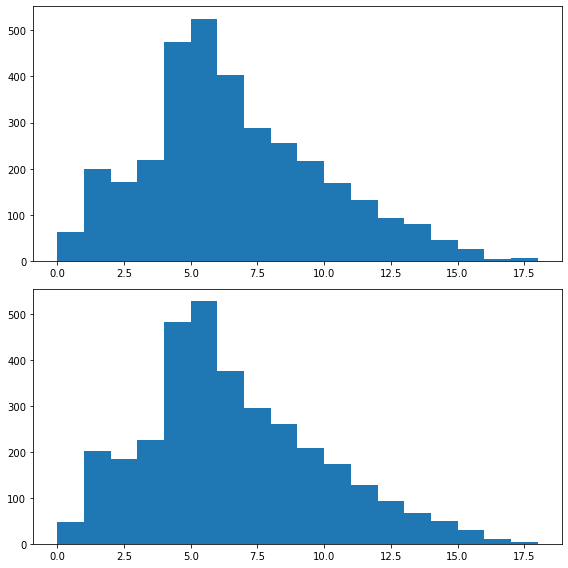

In [907]:
reg_full_preds = model_full.predict(X_full)
reg_med_preds = model_med.predict(X_med)
fig, ax = plt.subplots(2,1, figsize=(8,8))
bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
ax[0].hist(reg_full_preds, bins=bins)
ax[1].hist(reg_med_preds, bins=bins)
plt.tight_layout()

In [908]:
from sklearn.model_selection import GridSearchCV

In [909]:
X_med.shape

(3376, 4)

In [910]:
# Create an XGBoost Regression with a little bit of hyperparameter tuning
#xgb_model = xgb.XGBRegressor(n_estimator=10000, max_depth=7, eta=0.1, subsample=0.9)
#cv = RepeatedKFold(n_split=150, n_repeats=5)
dmatrix=xgb.DMatrix(data=X_med, label=y)
params={'max_depth': [3,6,10],
        'colsample_bytree': [0.3, 0.7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000]}
#cv_results =xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
xgb_reg = xgb.XGBRegressor(seed=20)
clf = GridSearchCV(estimator=xgb_reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(X, y)


#print('XGB RMSE:', round(cv_results['test-rmse-mean'].min(),3))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  3.0min finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=20,
                                    subsample=None, tree_method=None,
                       

In [911]:
print('Best parameters:', clf.best_params_)
print('Lowest RMSE: ', (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Lowest RMSE:  5.601835195672573


[17:08:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




(array([ 43., 213., 297., 363., 550., 399., 364., 236., 202., 148., 118.,
        108.,  68.,  43.,  41.,  37.,  30.,  16.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 18 Patch objects>)

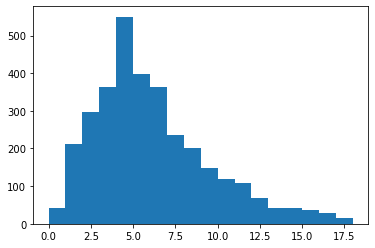

In [912]:
xgb_preds = xgb.XGBRegressor(params=clf.best_params_).fit(X, y).predict(X)
plt.hist(xgb_preds, bins=bins)

In [913]:
# Attempting to make a gamma regression and a poisson regression, but neither look better than either XBG or simple linear regression

# Gamma Regression
X_med = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
X_full = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins']])
y = np.array(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])]['Real_Pts'])
y_gamm_adj = y + abs(min(y.min(), 0)) + 0.02 # convert all value to be > 0
y_pois_adj = y * 50 # convert all values to integers
y_pois_adj = y + abs(min(y_pois_adj.min(), 0)) # convert all value to be >= 0

#gamma_reg = GammaRegressor(params={'gamma':1e-8})
#cv = RepeatedKFold(gamma_reg, n_splits=150, n_repeats=10)
#gamma_rmse = cross_val_score(gamma_reg, X_full, y_gamm_adj, scoring='neg_root_mean_squared_error').mean()*(-1)
#print('Gamma RMSE:', round(gamma_rmse,3))
##gamma_preds = gamma_reg.fit(X_full, y_gamm_adj).predict(X_full)
#gamma_preds = GammaRegressor().fit(X_full, y_gamm_adj).predict(X_full)

#poiss_reg = PoissonRegressor()
#cv = RepeatedKFold(poiss_reg, n_splits=150, n_repeats=10)
#poiss_rmse = cross_val_score(poiss_reg, X_full, y_pois_adj, scoring='neg_root_mean_squared_error').mean()*(-1)
#print('Poisson RMSE:', round(poiss_rmse,3))
#poiss_preds = poiss_reg.fit(X_full, y_pois_adj).predict(X_full)

poiss_reg = smf.glm(formula='Real_Pts ~ Salary + Pts_w_StartMins + Proj_Mins', data=points_data[~pd.isna(points_data['FPTS_med/proj_mins'])],
                    family=sm.families.Poisson()).fit()
poiss_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Real_Pts   No. Observations:                 3376
Model:                            GLM   Df Residuals:                     3372
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 04 Nov 2021   Deviance:                       18547.
Time:                        17:08:46   Pearson chi2:                 1.49e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3712      0.034     10.826      0.000       0.304       0.438
Salary           9.087e-05    4.1e-06     22.145      0.000    8.28e-05    9.89e-05
Pts_w_StartMins     0.0331      0.002     14.182      0.000       0.029       0.038
Proj_Mins           0.0096      0.000     25.293      0.000       0.009       0.010
===================================================================================
"""

In [914]:
poiss_preds = poiss_reg.predict(points_data[~pd.isna(points_data['FPTS_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins']])

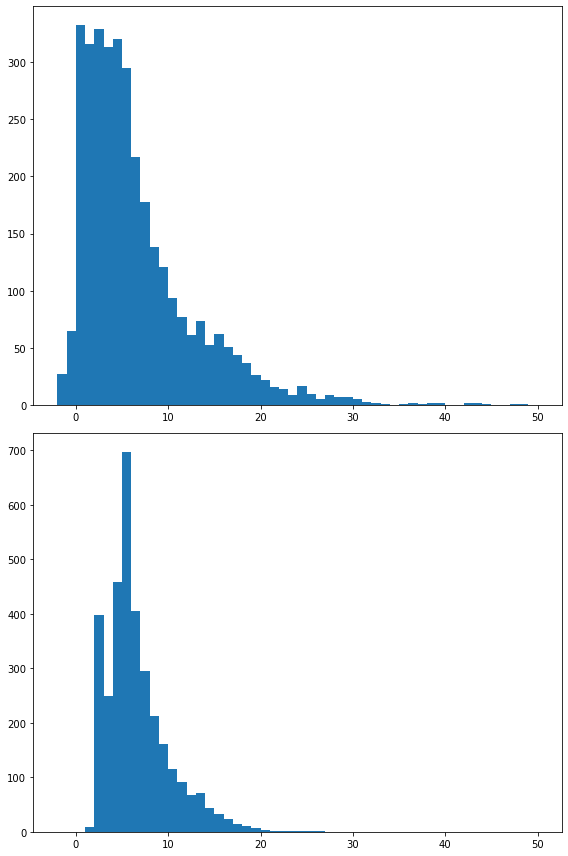

In [915]:
#fig, ax = plt.subplots(3,2, figsize=(16,12))
#ax[0,0].hist(y, bins=np.arange(int(min(y)), int(max(y)), 1))
#ax[1,0].hist(y_gamm_adj, bins=np.arange(int(min(y_gamm_adj)), int(max(y_gamm_adj)), 1))
#ax[2,0].hist(y_pois_adj, bins=np.arange(int(min(y_pois_adj)), int(max(y_pois_adj)), 50))
fig, ax = plt.subplots(2,1, figsize=(8,12))
ax[0].hist(y, bins=np.arange(int(min(y)), int(max(y)), 1))
ax[1].hist(poiss_preds, bins=np.arange(int(min(y)), int(max(y)), 1))


plt.tight_layout()

In [916]:
## XGB Random Forest, just for fun

dmatrix=xgb.DMatrix(data=X_med, label=y)
params={'max_depth': [3,6,10],
        'colsample_bytree': [0.3, 0.7],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000]}
#cv_results =xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
xgb_reg = xgb.XGBRFRegressor(seed=20)
clf = GridSearchCV(estimator=xgb_reg,
                   param_grid=params,
                   scoring='neg_mean_squared_error',
                   verbose=1)
clf.fit(X, y)


#print('XGB RMSE:', round(cv_results['test-rmse-mean'].min(),3))


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.8min finished


GridSearchCV(estimator=XGBRFRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bytree=None, gamma=None,
                                      gpu_id=None, importance_type='gain',
                                      interaction_constraints=None,
                                      max_delta_step=None, max_depth=None,
                                      min_child_weight=None, missing=nan,
                                      monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      random_state=None, reg_alpha=None,
                                      scale_pos_weight=None, seed=20,
                                      tree_method=None,
                                      val

In [917]:
print('Best parameters:', clf.best_params_)
print('Lowest RMSE: ', (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSE:  8.362766326039509


[17:11:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




(array([  0., 136., 344., 260., 669., 295., 317., 299., 295., 223., 172.,
         81.,  52.,  71.,  67.,  53.,  24.,   6.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 18 Patch objects>)

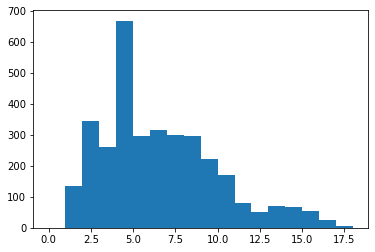

In [918]:
xgb_preds = xgb.XGBRFRegressor(params=clf.best_params_).fit(X_med, y).predict(X_med)
plt.hist(xgb_preds, bins=bins)

In [919]:
# New xG Med Predictor with linear regression
X_med_xG = np.array(points_data[~pd.isna(points_data['FPTS_xG_med/proj_mins'])][['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_xG_med/proj_mins']])
X_onlyMedxG = np.array(points_data[~pd.isna(points_data['FPTS_xG_med/proj_mins'])]['FPTS_xG_med/proj_mins']).reshape(-1,1)
y = np.array(points_data[~pd.isna(points_data['FPTS_xG_med/proj_mins'])]['Real_Pts'])

linreg = LinearRegression()

cv = RepeatedKFold(n_splits=10,n_repeats=500)
score1 = cross_val_score(linreg, X_med_xG, y, scoring='neg_root_mean_squared_error', cv=cv)
score2 = cross_val_score(linreg, X_onlyMedxG, y, scoring='neg_root_mean_squared_error', cv=cv)
print('Salary + Pts_w_StartMins + Proj_Mins + FPTS_xG_Mins:', round(-1*score1.mean(), 3))
print('Only FPTS_xG_Mins:', round(-1*score2.mean(), 3))

Salary + Pts_w_StartMins + Proj_Mins + FPTS_xG_Mins: 5.469
Only FPTS_xG_Mins: 5.602


In [920]:
print('no_xG > xG: ', round(len(points_data[points_data['FPTS_med/proj_mins'] > points_data['FPTS_xG_med/proj_mins']])/len(points_data),3))
print('no_xG < xG: ', round(len(points_data[points_data['FPTS_med/proj_mins'] < points_data['FPTS_xG_med/proj_mins']])/len(points_data),3))
print('no_xG == xG:', round(len(points_data[points_data['FPTS_med/proj_mins'] == points_data['FPTS_xG_med/proj_mins']])/len(points_data),3))


no_xG > xG:  0.141
no_xG < xG:  0.536
no_xG == xG: 0.32


In [921]:
points_data[points_data['FPTS_med/proj_mins'] > points_data['FPTS_xG_med/proj_mins']]

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
9,20210818,MLS,0,Showdown,Pablo Ruiz,RSL,M,6200,3.709688,90.000000,28.587823,b,1,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,-0.24,23.0,28.587823,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,6.420000,7.800000,2.477611,6.500000,2.064676
16,20210818,MLS,0,Showdown,Fafa Picault,HOU,M,7800,8.040528,69.672829,0.000000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,A,22.20,90.0,69.672829,1.0,HOU-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Houston Dynamo,7.611993,11.520000,8.918122,8.765455,6.785711
41,20210818,MLS,0,Showdown,Cristian Dajome,VAN,M/F,11000,16.506844,89.916435,31.000000,y,3,1,NaN,https://fbref.com/en/matches/e53e3077/Austin-F...,A,11.26,90.0,89.916435,2.0,VAN-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_VAN_20210818_spre...,5,Vancouver,12.781813,18.340000,18.322971,16.840000,16.824364
56,20210818,MLS,0,Showdown,Wikelman Carmona,RBNY,M,6800,14.940313,73.348577,23.500000,y,3,2,NaN,https://fbref.com/en/matches/ebb18562/New-York...,H,6.50,70.0,73.348577,1.0,RBNY-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RBNY_CLB_20210818_spr...,5,NY Red Bulls,7.626975,10.059048,8.197965,7.588333,6.184372
58,20210818,MLS,0,Showdown,Kyle Duncan,RBNY,D,6200,10.088784,90.000000,0.000000,y,4,0,NaN,https://fbref.com/en/matches/ebb18562/New-York...,H,8.68,90.0,90.000000,1.0,RBNY-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RBNY_CLB_20210818_spr...,5,NY Red Bulls,3.885761,9.720000,9.720000,9.640000,9.640000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3359,20211103,MLS,0,Showdown,Santiago Moreno,POR,M,5600,2.691206,69.000000,16.305791,b,2,6,3.265132,https://fbref.com/en/matches/0ae16095/Real-Sal...,A,1.62,16.0,16.305791,3.0,POR-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Portland Timbers,9.822813,11.304098,2.048025,10.230000,1.853425
3374,20211103,MLS,0,Showdown,Johnny Russell,SKC,F,12800,17.507002,82.498997,0.000000,y,8,0,15.031050,https://fbref.com/en/matches/9095661b/Austin-F...,A,20.18,77.0,82.498997,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,7.299251,19.170000,17.572286,13.283409,12.176310
3375,20211103,MLS,0,Showdown,Daniel Salloi,SKC,M/F,11400,16.753824,78.868122,37.000000,y,5,1,13.887391,https://fbref.com/en/matches/9095661b/Austin-F...,A,3.80,90.0,78.868122,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,10.957504,16.802927,14.724614,12.201463,10.692294
3377,20211103,MLS,0,Showdown,Graham Zusi,SKC,D,6400,7.709739,90.000000,0.000000,y,6,0,8.032262,https://fbref.com/en/matches/9095661b/Austin-F...,A,10.26,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.840665,6.280000,6.280000,6.160000,6.160000


In [922]:
namematching = pd.read_csv('NameMatching.csv', encoding='utf-8')
fbref_to_dk = {}
for i in range(len(namematching)):
    fbref_to_dk[namematching['FBRef'][i]] = namematching['Name'][i]

In [923]:
# Fill the still unfilled players with medians
# so that players will not be left out of lineup optimizers

stdev_med = points_data['FPTS_stdev'].median()
med_med = points_data['FPTS_med'].median()
med_xG_med = points_data['FPTS_xG_med'].median()
for i in points_data[pd.isna(points_data['FPTS_med'])].index:
    points_data['FPTS_stdev'][i] = stdev_med
    points_data['FPTS_med'][i] = med_med
    points_data['FPTS_xG_med'][i] = med_xG_med
    points_data['FPTS_med/proj_mins'][i] = points_data['FPTS_med'][i] / points_data['Proj_Mins'][i]
    points_data['FPTS_xG_med/proj_mins'][i] = points_data['FPTS_xG_med'][i] / points_data['Proj_Mins'][i]
points_data[pd.isna(points_data['FPTS_xG_med/proj_mins'])]

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins


In [924]:
#idx_list = []
#for i in points_data.index:
#    if (points_data['FPTS_stdev'][i] == stdev_med):
#        idx_list.append(i)
#print(idx_list)
#points_data.loc[idx_list]
points_data

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins
0,20210818,MLS,0,Showdown,Albert Rusnak,RSL,M,11000,14.179062,86.502811,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,2.30,90.0,86.502811,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.183388,10.340000,9.938212,13.140000,12.629410
1,20210818,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,13.843567,88.392236,27.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,3.22,90.0,88.392236,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,7.950135,8.620000,8.466012,12.220000,12.001701
2,20210818,MLS,0,Showdown,Jony,RSL,F,9000,10.856076,60.625902,23.00000,y,2,2,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,4.90,67.0,60.625902,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,5.136585,11.795294,7.945559,12.716129,8.565853
3,20210818,MLS,0,Showdown,Aaron Herrera,RSL,D,8600,9.557668,90.000000,0.00000,y,4,0,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,5.98,90.0,90.000000,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.440619,8.400000,8.400000,9.000000,9.000000
4,20210818,MLS,0,Showdown,Justin Meram,RSL,M/F,6400,9.267592,74.919813,28.00000,y,3,1,NaN,https://fbref.com/en/matches/d96cb635/Real-Sal...,H,17.08,78.0,74.919813,2.0,RSL-MLS-20210818-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_HOU_20210818_spre...,5,Real Salt Lake,3.638587,6.011351,5.004104,8.541081,7.109958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3381,20211103,MLS,0,Showdown,Ilie Sanchez,SKC,M,3200,4.718725,90.000000,0.00000,y,7,0,5.175411,https://fbref.com/en/matches/9095661b/Austin-F...,A,9.12,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,2.653082,3.710000,3.710000,3.850000,3.850000
3382,20211103,MLS,0,Showdown,Nicolas Isimat-Mirin,SKC,D,3600,3.924187,90.000000,15.00000,y,2,1,5.065800,https://fbref.com/en/matches/9095661b/Austin-F...,A,1.36,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.080288,2.820000,2.820000,2.820000,2.820000
3383,20211103,MLS,0,Showdown,Andreu Fontas,SKC,D,3800,3.877221,90.000000,0.00000,y,7,0,5.150922,https://fbref.com/en/matches/9095661b/Austin-F...,A,2.80,90.0,90.000000,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,1.363332,3.320000,3.320000,3.320000,3.320000
3384,20211103,MLS,0,Showdown,Cameron Duke,SKC,M,4600,1.972046,77.666667,16.54576,b,3,1,2.466102,https://fbref.com/en/matches/9095661b/Austin-F...,A,0.16,23.0,16.545760,1.0,SKC-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/ATX_SKC_20211103_spre...,8,Sporting KC,6.220362,6.240000,1.147173,6.240000,1.147173


In [312]:
#contest_list_ = list(TestingResults_PTS['Contest'])
#league_list_ = list(TestingResults_PTS['League'])
#league_list_

In [925]:
# Read in old data so we don't have to rerun everything
TR_PTS_Old = pd.read_csv('Backtesting/TestingResults_PTS_1step.csv')
TR_POS_Old = pd.read_csv('Backtesting/TestingResults_POS_1step.csv')
TR_PER_Old = pd.read_csv('Backtesting/TestingResults_PER_1step.csv')

#contest_list = ['RVM_CEL_20211101', 'WOL_EVE_20211101', 'SEA_LA_20211101']
#league_list = ['LaLiga', 'PremierLeague', 'MLS']
#contest_list = ['LAFC_VAN_20211102']
#league_list = ['MLS']
contest_list = ['RSL_POR_20211103', 'ATX_SKC_20211103'] # new contests to backtest
league_list = ['MLS', 'MLS']

# We don't want to have to refit XGBoost for every game - we don't do that in real life
# Refit like in real life, usually Friday or Tuesday before weekend or midweek games
refit_dates = [20211001, 20211009, 20211015, 20211020, 20211022, 20211026, 20211029, 20211102]
print(len(contest_list), len(league_list))
#print(len(contest_list),len(league_list))
##win_cutoff_list = [10,10,10,10,17,10,10,10,10,10,10,5,10] + [np.nan]*(len(contest_list)-len(win_cutoff_list))
##print(win_cutoff_list)
##print(len(win_cutoff_list))
target_cols = ['Pts_w_StartMins', 'Reg_Pts', 'FPTS_med/proj_mins', 'FPTS_xG_med/proj_mins', 'Med_Reg', 'XGB_Reg']
#twostep_cols = ['Pts_']
TestingResults_PTS = pd.DataFrame(index=range(len(contest_list)))
TestingResults_POS = pd.DataFrame(index=range(len(contest_list)))
TestingResults_PTS['Contest'] = contest_list
TestingResults_POS['Contest'] = contest_list
TestingResults_PTS['Date'] = 0
TestingResults_POS['Date'] = 0
for i in range(len(TestingResults_PTS)): TestingResults_PTS['Date'][i] = int(TestingResults_PTS['Contest'][i].split('_')[-1])
for i in range(len(TestingResults_POS)): TestingResults_POS['Date'][i] = int(TestingResults_POS['Contest'][i].split('_')[-1])
TestingResults_PTS['League'] = league_list
TestingResults_POS['League'] = league_list
TestingResults_PTS['GameType'] = 'Showdown'
TestingResults_POS['GameType'] = 'Showdown'
TestingResults_PTS['Contest_Size'] = 0
TestingResults_POS['Contest_Size'] = 0
TestingResults_PTS['Win_Cutoff'] = np.nan
TestingResults_POS['Win_Cutoff'] = np.nan
TestingResults_PTS['Original'] = 0.0
TestingResults_POS['Original'] = 0
for col in target_cols:
    TestingResults_PTS[col] = 0.0
    TestingResults_POS[col] = 0

TestingResults_PTS = pd.concat([TR_PTS_Old, TestingResults_PTS], axis=0)
TestingResults_POS = pd.concat([TR_POS_Old, TestingResults_POS], axis=0)
    
TestingResults_PTS = TestingResults_PTS.sort_values(by=['Date','League','GameType','Contest']).reset_index(drop=True)
TestingResults_POS = TestingResults_POS.sort_values(by=['Date','League','GameType','Contest']).reset_index(drop=True)

TestingResults_PTS

2 2


,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,60.64,63.72,60.64,45.74,63.72,59.57
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,75.90,58.54,70.48,53.90,77.94,60.02
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,48.25,45.32,36.82,36.82,45.32,42.60
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,69.94,64.20,99.72,63.40,61.67,41.94
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,96.04,84.10,94.78,101.04,91.62,92.66
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,45.73,45.73,75.03,48.11,72.35,67.21
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,34.65,32.71,36.25,36.25,34.65,39.77
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,59.99,51.17,55.46,57.81,46.95,54.38
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,88.28,88.28,75.60,54.41,88.28,78.04
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,48.29,63.35,53.97,55.97,64.65,53.97


In [203]:
#for contest in contest_list:
#    idx = TestingResults_PTS[(TestingResults_PTS['Contest'] == contest) & (TestingResults_PTS['Pts_w_StartMins'] != 0)].index[0]
#    print(contest, idx)
#    TestingResults_PTS = TestingResults_PTS.drop(index=idx).reset_index(drop=True)
#    TestingResults_POS = TestingResults_POS.drop(index=idx).reset_index(drop=True)
#TestingResults_PTS

In [926]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# DK result files have ?'s for letters with accents
# fix that if possible
def fix_Qs(df, name, col):
    mask_a = df[col] == name.replace('?','a')
    mask_i = df[col] == name.replace('?','i')
    mask_e = df[col] == name.replace('?','e')
    mask_n = df[col] == name.replace('?','n')
    return(mask_a | mask_i | mask_e | mask_n)

#with open('Backtesting/results.txt') as f:
#    tst = json.load(f)
#print(tst)

DK_username = 'stevensthrill' # That's me!
starters_list = {}
Lineups_list = {}
#results_list = {}
with open('Backtesting/Results.txt') as f: # old results will have been saved there
    results_list = json.load(f)
twostep_range = 1 # thinking of increasing this to 1.5 or 2
# All in One Cell
#for resdf_ctr in range(len(TestingResults_PTS)):
#for resdf_ctr in [23]:
ii=-1
for resdf_ctr in TestingResults_PTS[(pd.isna(TestingResults_PTS['FPTS_med/proj_mins'])) | (TestingResults_PTS['FPTS_med/proj_mins'] == 0)].index:
    start_match = time.time()
    #resdf_ctr+=1
    ii+=1
    print(TestingResults_PTS['Contest'][resdf_ctr])
    contest = TestingResults_PTS['Contest'][resdf_ctr]
    home_team = TestingResults_PTS['Contest'][resdf_ctr].split('_')[0]
    away_team = TestingResults_PTS['Contest'][resdf_ctr].split('_')[1]
    league = TestingResults_PTS['League'][resdf_ctr]
    date = int(TestingResults_PTS['Contest'][resdf_ctr].split('_')[2])
    if (ii!=0): last_date = int(TestingResults_PTS['Contest'][resdf_ctr-1].split('_')[2])
    
    #################################################################################################################################################
    #################################################################################################################################################
    #################################################################################################################################################

    starters = points_data[(points_data['Date'] == date) & (points_data['League'] == league) & 
                           ((points_data['Team'] == home_team) | (points_data['Team'] == away_team))]
    # FBRef xG data takes a day or two to come out - in real life the most recent data is from a few days ago
    training = points_data[(points_data['Date'] < date-3) & (points_data['GameStyle'] == 'Showdown')]
    
    # Create linear regression
    X_med = np.array(training[['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
    X_test = np.array(starters[['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
    y = np.array(training['Real_Pts'])
    starters['Med_Reg'] = LinearRegression().fit(X_med, y).predict(X_test)
    
    # if we're on the the next weekend, create a new xgboost model
    last_date = int(TestingResults_PTS['Contest'][max(resdf_ctr-1,0)].split('_')[2])
    #if (((date - last_date) >= 2) or (ii == 0)): #this saves a bit of computation
    if (((date in refit_dates) and (last_date != date)) or (ii==0)):
    #if (True): # for testing - comment out
        print('XGBoost Refit')
        dmatrix=xgb.DMatrix(data=X_med, label=y)
        params={'max_depth': [3,6,10],
                'colsample_bytree': [0.3, 0.7],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 500, 1000]}
        #cv_results =xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
        xgb_reg = xgb.XGBRegressor(seed=20)
        clf = GridSearchCV(estimator=xgb_reg,
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           verbose=0)
        clf.fit(X_med, y)
    args = {'max_depth': clf.best_params_['max_depth'],
            'learning_rate': clf.best_params_['learning_rate'],
            'n_estimators': clf.best_params_['n_estimators'],
            'colsample_bytree': clf.best_params_['colsample_bytree']}
    starters['XGB_Reg'] = xgb.XGBRegressor(**args).fit(X_med, y).predict(X_test)

    ###
    #################################################################################################################################################
    #################################################################################################################################################
    #################################################################################################################################################

    starters = starters[starters['Starting'] == 'y']
    starters_list[contest] = starters
    #starters_list.append(starters)
    
    filename = 'DK_Standings/'+league+'/'+home_team+'_'+away_team+'_'+str(date)+'_standings.csv'
    standings = pd.read_csv(filename, encoding='utf-8')
    player_pts = standings[['Player', 'Roster Position', '%Drafted', 'FPTS']]
    player_pts = player_pts[~pd.isna(player_pts['Player'])].reset_index(drop=True)
    player_pts['Q_n'] = 0
    player_pts['Similarity'] = 0.0
    player_pts['Player_FBRef'] = ''
    for i in range(len(player_pts)):
        name = player_pts['Player'][i]
        player_pts['Q_n'][i] = name.count('?')
        starters['Similarity'] = 0.0
        for t in starters.index:
            starters['Similarity'][t] = similar(name, fbref_to_dk[starters['Player'][t]])
        starters_sorted = starters.sort_values(by='Similarity', ascending=False).reset_index(drop=True)
        player_pts['Similarity'][i] = starters_sorted['Similarity'][0]
        if (player_pts['Similarity'][i] < 0.6):
            player_pts['Player_FBRef'][i] = np.nan
        else:
            player_pts['Player_FBRef'][i] = starters_sorted['Player'][0]
        if (player_pts['Roster Position'][i] == 'CPT'):
            player_pts['FPTS'][i] = player_pts['FPTS'][i] / 1.5
    standings = standings[~pd.isna(standings['EntryName'])]
    TestingResults_PTS['Contest_Size'][resdf_ctr] = len(standings)
    TestingResults_POS['Contest_Size'][resdf_ctr] = len(standings)
    if (DK_username in list(standings['EntryName'])):
        old_pts = standings[standings['EntryName'] == 'stevensthrill']['Points'].iloc[0]
        old_pos = standings[standings['EntryName'] == 'stevensthrill']['Rank'].iloc[0]
        TestingResults_PTS['Original'][resdf_ctr] = old_pts
        TestingResults_POS['Original'][resdf_ctr] = old_pos
        standings = standings[standings['EntryName'] != 'stevensthrill'].reset_index(drop=True)
    else:
        TestingResults_PTS['Original'][resdf_ctr] = np.nan
        TestingResults_POS['Original'][resdf_ctr] = np.nan
    
    col_ctr = 1
    Lineups_dict = {}
    results_dict = {}
    for target_col in target_cols:
    #for target_col in ['Reg_Med_Pts_Even']:
        print(target_col, '-', col_ctr)
        col_ctr+=1
        starters = starters.sort_values(by=target_col, ascending=False)
        #starters = starters.reset_index(drop=True)
        
        #starters[['Team','Pos','Salary','Proj_Mins','Reg_Pts','FPTS_stdev','stdev/reg','Reg_Pts_Dev']]

        min_pts = starters[target_col].mean() * (6.5)

        start = time.time()
        Lineups_DF = pd.DataFrame(columns=['Captain', 'Flex1', 'Flex2', 'Flex3', 'Flex4', 'Flex5', 'Proj_Pts', 'Price'],
                                  index=range(len(starters)*len(list(itertools.combinations(range(len(starters)-1), 5)))))
        i=0
        for cpt_idx in list(starters.index):
            full_idxs = list(starters.index)
            full_idxs.remove(cpt_idx)
            full_idxs
            index_combos = list(itertools.combinations(full_idxs, 5))
            for index_combo in index_combos:
                if (len(set([starters['Team'][cpt_idx], starters['Team'][index_combo[0]], starters['Team'][index_combo[1]], starters['Team'][index_combo[2]], starters['Team'][index_combo[3]], starters['Team'][index_combo[4]]])) > 1):
                    price = starters['Salary'][cpt_idx]*1.5 + \
                                starters['Salary'][index_combo[0]] + \
                                starters['Salary'][index_combo[1]] + \
                                starters['Salary'][index_combo[2]] + \
                                starters['Salary'][index_combo[3]] + \
                                starters['Salary'][index_combo[4]]
                    proj_pts = starters[target_col][cpt_idx]*1.5 + \
                                starters[target_col][index_combo[0]] + \
                                starters[target_col][index_combo[1]] + \
                                starters[target_col][index_combo[2]] + \
                                starters[target_col][index_combo[3]] + \
                                starters[target_col][index_combo[4]]
                    Lineups_DF.loc[i] = [starters['Player'][cpt_idx], starters['Player'][index_combo[0]], starters['Player'][index_combo[1]], starters['Player'][index_combo[2]],
                                         starters['Player'][index_combo[3]], starters['Player'][index_combo[4]], proj_pts, price]
                i+=1

        Lineups_DF = Lineups_DF[Lineups_DF['Price'] <= 50000]
        Lineups_DF = Lineups_DF[Lineups_DF['Proj_Pts'] > min_pts]
        Lineups_DF = Lineups_DF.sort_values(by='Proj_Pts', ascending=False).reset_index().drop(columns=['index'])
        Lineups_dict[target_col] = Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-twostep_range]
        #if (target_col == 'Reg_Pts'):
            #print(Lineups_DF.iloc[[0]])
        

        stop = time.time()
        #print('Total Time:', round(stop-start), 'sec')
        #Lineups_DF
        
        #cpt = game_data.loc[Lineups_DF['Captain'][0],'FPTS']*1.5
        
        if (Lineups_DF['Captain'][0] in list(player_pts['Player_FBRef'])):
            cpt = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Captain'][0]]['FPTS'].iloc[0]
        else:
            cpt = starters[starters['Player'] == Lineups_DF['Captain'][0]]['Real_Pts'].iloc[0]
        
        if (Lineups_DF['Flex1'][0] in list(player_pts['Player_FBRef'])):
            flex1 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex1'][0]]['FPTS'].iloc[0]
        else:
            flex1 = starters[starters['Player'] == Lineups_DF['Flex1'][0]]['Real_Pts'].iloc[0]
               
        if (Lineups_DF['Flex2'][0] in list(player_pts['Player_FBRef'])):
            flex2 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex2'][0]]['FPTS'].iloc[0]
        else:
            flex2 = starters[starters['Player'] == Lineups_DF['Flex2'][0]]['Real_Pts'].iloc[0]
            
        if (Lineups_DF['Flex3'][0] in list(player_pts['Player_FBRef'])):
            flex3 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex3'][0]]['FPTS'].iloc[0]
        else:
            flex3 = starters[starters['Player'] == Lineups_DF['Flex3'][0]]['Real_Pts'].iloc[0]
        
        if (Lineups_DF['Flex4'][0] in list(player_pts['Player_FBRef'])):
            flex4 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex4'][0]]['FPTS'].iloc[0]
        else:
            flex4 = starters[starters['Player'] == Lineups_DF['Flex4'][0]]['Real_Pts'].iloc[0]
            
        if (Lineups_DF['Flex5'][0] in list(player_pts['Player_FBRef'])):
            flex5 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex5'][0]]['FPTS'].iloc[0]
        else:
            flex5 = starters[starters['Player'] == Lineups_DF['Flex5'][0]]['Real_Pts'].iloc[0]
        #print('CPT:  ', round(cpt,2), '-', Lineups_DF['Captain'][0])
        #print('FLEX1:', round(flex1,2), '-', Lineups_DF['Flex1'][0])
        #print('FLEX2:', round(flex2,2), '-', Lineups_DF['Flex2'][0])
        #print('FLEX3:', round(flex3,2), '-', Lineups_DF['Flex3'][0])
        #print('FLEX4:', round(flex4,2), '-', Lineups_DF['Flex4'][0])
        #print('FLEX5:', round(flex5,2), '-', Lineups_DF['Flex5'][0])
        #print('')
        pts = cpt*1.5 + flex1 + flex2 + flex3 + flex4 + flex5
        
        results_dict[target_col] = {Lineups_DF['Captain'][0]: cpt,
                                    Lineups_DF['Flex1'][0]: flex1,
                                    Lineups_DF['Flex2'][0]: flex2,
                                    Lineups_DF['Flex3'][0]: flex3,
                                    Lineups_DF['Flex4'][0]: flex4,
                                    Lineups_DF['Flex5'][0]: flex5}

        #print('new_pts:', round(pts,2))
        for i in range(len(standings['Points'])):
            if (pts > standings['Points'][i]):
                break
        new_pos = i+1
        if (pts < standings['Points'].min()): new_pos = len(standings['Points'])+1
        #print('new_pos:', new_pos)
        TestingResults_PTS[target_col][resdf_ctr] = pts
        TestingResults_POS[target_col][resdf_ctr] = new_pos
    #Lineups_list.append(Lineups_dict)
    #results_list.append(results_dict)
    Lineups_list[contest] = Lineups_dict.copy()
    results_list[contest] = results_dict
    stop_match = time.time()
    print('Match Took', round(stop_match-start_match,2), 'sec\n')
    
TestingResults_PTS

ATX_SKC_20211103
XGBoost Refit
Pts_w_StartMins - 1
Reg_Pts - 2
FPTS_med/proj_mins - 3
FPTS_xG_med/proj_mins - 4
Med_Reg - 5
XGB_Reg - 6
Match Took 611.29 sec

RSL_POR_20211103
Pts_w_StartMins - 1
Reg_Pts - 2
FPTS_med/proj_mins - 3
FPTS_xG_med/proj_mins - 4
Med_Reg - 5
XGB_Reg - 6
Match Took 354.73 sec



,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,60.64,63.72,60.64,45.74,63.72,59.57
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,75.90,58.54,70.48,53.90,77.94,60.02
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,48.25,45.32,36.82,36.82,45.32,42.60
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,69.94,64.20,99.72,63.40,61.67,41.94
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,96.04,84.10,94.78,101.04,91.62,92.66
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,45.73,45.73,75.03,48.11,72.35,67.21
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,34.65,32.71,36.25,36.25,34.65,39.77
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,59.99,51.17,55.46,57.81,46.95,54.38
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,88.28,88.28,75.60,54.41,88.28,78.04
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,48.29,63.35,53.97,55.97,64.65,53.97


In [927]:
print(contest)
results_list[contest]

RSL_POR_20211103


{'Pts_w_StartMins': {'Rubio Rubin': 5.4,
  'Damir Kreilach': 9.16,
  'Sebastian Blanco': 32.04,
  'Dairon Asprilla': 6.5,
  'Cristhian Paredes': 10.4,
  'Diego Chara': 2.14},
 'Reg_Pts': {'Damir Kreilach': 9.16,
  'Albert Rusnak': 27.3,
  'Rubio Rubin': 5.4,
  'Maikel Chang': 10.42,
  'Claudio Bravo': -1.78,
  'Diego Chara': 2.14},
 'FPTS_med/proj_mins': {'Dairon Asprilla': 6.5,
  'Damir Kreilach': 9.16,
  'Yimmi Chara': 18.22,
  'Aaron Herrera': 10.5,
  'Diego Chara': 2.14,
  'Claudio Bravo': -1.78},
 'FPTS_xG_med/proj_mins': {'Damir Kreilach': 9.16,
  'Sebastian Blanco': 32.04,
  'Dairon Asprilla': 6.5,
  'Aaron Herrera': 10.5,
  'Cristhian Paredes': 10.4,
  'Pablo Ruiz': 7.66},
 'Med_Reg': {'Damir Kreilach': 9.16,
  'Albert Rusnak': 27.3,
  'Dairon Asprilla': 6.5,
  'Aaron Herrera': 10.5,
  'Diego Chara': 2.14,
  'Cristhian Paredes': 10.4},
 'XGB_Reg': {'Damir Kreilach': 9.16,
  'Albert Rusnak': 27.3,
  'Dairon Asprilla': 6.5,
  'Aaron Herrera': 10.5,
  'Cristhian Paredes': 10.4,
  

In [928]:
starters_list[contest]

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg,Similarity
3335,20211103,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,17.674307,90.000000,0.000000,y,6,0,13.778541,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,9.14,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,7.198857,16.209512,16.209512,12.590000,12.590000,14.231310,14.061037,0.480000
3336,20211103,MLS,0,Showdown,Albert Rusnak,RSL,M,11200,16.335422,90.000000,0.000000,y,5,0,13.970904,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,27.42,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,9.483781,9.870000,9.870000,9.650000,9.650000,13.639080,13.538191,0.083333
3337,20211103,MLS,0,Showdown,Rubio Rubin,RSL,F,9000,15.200958,78.581030,32.000000,y,5,1,12.011384,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,5.36,60.0,78.581030,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,8.828931,10.398893,9.079508,10.125634,8.840919,11.759677,9.855596,0.181818
3338,20211103,MLS,0,Showdown,Maikel Chang,RSL,M,6400,9.076041,83.826622,16.000000,y,2,3,8.381417,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,10.56,75.0,83.826622,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,14.267193,6.773684,6.309056,7.484211,6.970845,8.294695,8.008377,0.434783
3339,20211103,MLS,0,Showdown,Pablo Ruiz,RSL,M,5000,8.678793,77.483913,0.000000,y,6,0,7.293567,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,8.16,90.0,77.483913,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,1.976091,6.960000,5.992089,8.734426,7.519750,7.253088,7.501833,0.190476
3340,20211103,MLS,0,Showdown,Aaron Herrera,RSL,D,7200,8.672462,85.986572,0.000000,y,5,0,8.704525,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,10.70,90.0,85.986572,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,4.537327,10.457778,9.991427,9.026883,8.624342,9.124006,9.697035,0.250000
3342,20211103,MLS,0,Showdown,Everton Luiz,RSL,M,4200,6.196498,90.000000,33.500000,y,4,2,6.285107,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,8.98,83.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,4.480603,5.485517,5.485517,5.785517,5.785517,6.349888,5.930311,0.173913
3343,20211103,MLS,0,Showdown,Justen Glad,RSL,D,4000,5.320159,90.000000,0.000000,y,6,0,5.831177,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,5.48,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,2.874787,3.280000,3.280000,3.720000,3.720000,5.672636,5.203389,0.181818
3344,20211103,MLS,0,Showdown,Andrew Brody,RSL,D,5800,4.388449,62.741398,13.000000,y,1,1,5.525827,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,4.52,45.0,62.741398,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,3.381302,1.940000,1.352426,1.940000,1.352426,5.242603,4.981833,0.260870
3345,20211103,MLS,0,Showdown,Erik Holt,RSL,D,3000,2.647888,90.000000,0.000000,y,6,0,4.244345,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,6.82,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,1.485867,2.730000,2.730000,2.730000,2.730000,4.252783,4.095019,0.300000


In [929]:
Lineups_list[contest]['FPTS_xG_med/proj_mins']

,Captain,Flex1,Flex2,Flex3,Flex4,Flex5,Proj_Pts,Price
0,Damir Kreilach,Sebastian Blanco,Dairon Asprilla,Aaron Herrera,Cristhian Paredes,Pablo Ruiz,64.272618,49700.0
1,Damir Kreilach,Sebastian Blanco,Dairon Asprilla,Aaron Herrera,Cristhian Paredes,Claudio Bravo,63.742868,49500.0
2,Damir Kreilach,Sebastian Blanco,Dairon Asprilla,Aaron Herrera,Cristhian Paredes,Diego Chara,63.572868,48500.0


In [930]:
TestingResults_POS

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,17.0,19,17,19,23,17,22
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,14.0,3,14,5,16,3,13
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,19.0,18,19,20,20,19,19
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,4.0,4,9,2,11,12,16
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,9.0,7,9,7,3,7,7
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,16.0,16,16,1,16,1,1
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,14.0,13,14,11,11,13,6
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,18.0,15,18,16,16,18,17
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,9.0,9,9,17,29,9,17
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,10.0,20,10,16,16,9,16


In [209]:
#starters
##### STARTING HERE - SUNDAY A.M.

In [931]:
TestingResults_PER = pd.DataFrame(columns=TestingResults_PTS.columns, index=TestingResults_PTS.index)
TestingResults_PER['Contest'] = TestingResults_PTS['Contest']
TestingResults_PER['League'] = TestingResults_PTS['League']
TestingResults_PER['GameType'] = TestingResults_PTS['GameType']
TestingResults_PER['Contest_Size'] = TestingResults_PTS['Contest_Size']
TestingResults_PER['Win_Cutoff'] = TestingResults_PTS['Win_Cutoff']
TestingResults_PER['Original'] = TestingResults_PTS['Original']
for i in range(len(TestingResults_PER)):
    if (pd.isna(TestingResults_PER['Original'][i])):
        TestingResults_PER['Contest_Size'][i] = TestingResults_PER['Contest_Size'][i] + 1
        TestingResults_PTS['Contest_Size'][i] = TestingResults_PTS['Contest_Size'][i] + 1
        TestingResults_POS['Contest_Size'][i] = TestingResults_POS['Contest_Size'][i] + 1

for col in target_cols:
    TestingResults_PER[col] = TestingResults_POS[col] / TestingResults_PER['Contest_Size']
TestingResults_PER

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg
0,ATH_ALV_20211001,NaN,LaLiga,Showdown,23,NaN,63.720000,0.826087,0.739130,0.826087,1.000000,0.739130,0.956522
1,ATX_RSL_20211002,NaN,MLS,Showdown,19,NaN,58.540000,0.157895,0.736842,0.263158,0.842105,0.157895,0.684211
2,DAL_MIN_20211002,NaN,MLS,Showdown,20,NaN,45.320000,0.900000,0.950000,1.000000,1.000000,0.950000,0.950000
3,VAN_SJ_20211002,NaN,MLS,Showdown,17,NaN,69.940000,0.235294,0.529412,0.117647,0.647059,0.705882,0.941176
4,DSC_LEV_20211003,NaN,Bundesliga,Showdown,11,NaN,84.100000,0.636364,0.818182,0.636364,0.272727,0.636364,0.636364
5,LA_LAFC_20211003,NaN,MLS,Showdown,17,NaN,45.730000,0.941176,0.941176,0.058824,0.941176,0.058824,0.058824
6,NYC_NSH_20211003,NaN,MLS,Showdown,17,NaN,32.710000,0.764706,0.823529,0.647059,0.647059,0.764706,0.352941
7,POR_MIA_20211003,NaN,MLS,Showdown,19,NaN,51.170000,0.789474,0.947368,0.842105,0.842105,0.947368,0.894737
8,LIV_MCI_20211003,NaN,PremierLeague,Showdown,32,NaN,88.280000,0.281250,0.281250,0.531250,0.906250,0.281250,0.531250
9,RBNY_MIA_20211009,NaN,MLS,Showdown,21,NaN,63.350000,0.952381,0.476190,0.761905,0.761905,0.428571,0.761905


In [932]:
tmp_med = pd.DataFrame(data=TestingResults_PER.median(axis=0)).drop(index=['Contest_Size','Win_Cutoff', 'Original'])
tmp_mean = pd.DataFrame(data=TestingResults_PER.mean(axis=0)).drop(index=['Contest_Size','Win_Cutoff', 'Original'])
tmp_concat = pd.concat([tmp_med, tmp_mean], axis=1)
tmp_concat.columns = ['median', 'mean']
tmp_concat.sort_values(by=['median','mean'])

,median,mean
Med_Reg,0.428571,0.471693
XGB_Reg,0.488095,0.488121
FPTS_med/proj_mins,0.526495,0.485570
Reg_Pts,0.533937,0.481194
Pts_w_StartMins,0.534632,0.504537
FPTS_xG_med/proj_mins,0.587121,0.540809
Date,NaN,NaN


In [933]:
TestingResults_POS_1step = TestingResults_POS.copy()
TestingResults_PTS_1step = TestingResults_PTS.copy()
TestingResults_PER_1step = TestingResults_PER.copy()

In [934]:
TestingResults_POS_1step.to_csv('Backtesting/TestingResults_POS_1step.csv', index=False)
TestingResults_PTS_1step.to_csv('Backtesting/TestingResults_PTS_1step.csv', index=False)
TestingResults_PER_1step.to_csv('Backtesting/TestingResults_PER_1step.csv', index=False)

In [ ]:
# Now, I want to test a more stick & twist method, where a method is used to create the top handfull of lineups,
# Then use another metric to determine which of this hand full is most likely to be optimal

In [935]:
TR_PTS_Old = pd.read_csv('Backtesting/TestingResults_PTS_2step.csv')
TR_POS_Old = pd.read_csv('Backtesting/TestingResults_POS_2step.csv')
TR_PER_Old = pd.read_csv('Backtesting/TestingResults_PER_2step.csv')

#target_cols = ['Pts_w_StartMins', 'Reg_Pts', 'FPTS_med', 'Med_Reg', 'XGB_Reg', 'Gamma_Reg']
target_cols = ['Pts_w_StartMins&Salary_2step', 'Reg_Pts&Salary_2step', 'FPTS_med/proj_mins&Salary_2step', 'FPTS_xG_med/proj_mins&Salary_2step', 'Med_Reg&Salary_2step', 'XGB_Reg&Salary_2step',
               'Pts_w_StartMins&Med_2step', 'Reg_Pts&Med_2step', 'FPTS_xG_med/proj_mins&Med_2step', 'Med_Reg&Med_2step', 'XGB_Reg&Med_2step',
               'Pts_w_StartMins&MedxG_2step', 'Reg_Pts&MedxG_2step', 'FPTS_med/proj_mins&MedxG_2step', 'Med_Reg&MedxG_2step', 'XGB_Reg&MedxG_2step',
               'Reg_Pts&PwSM_2step', 'FPTS_med/proj_mins&PwSM_2step', 'FPTS_xG_med/proj_mins&PwSM_2step', 'Med_Reg&PwSM_2step', 'XGB_Reg&PwSM_2step',
               'Pts_w_StartMins&StDev_2step', 'Reg_Pts&StDev_2step', 'FPTS_med/proj_mins&StDev_2step', 'FPTS_xG_med/proj_mins&StDev_2step', 'Med_Reg&StDev_2step', 'XGB_Reg&StDev_2step']
TestingResults_PTS = pd.DataFrame(index=range(len(contest_list)))
TestingResults_POS = pd.DataFrame(index=range(len(contest_list)))
TestingResults_PTS['Contest'] = contest_list
TestingResults_POS['Contest'] = contest_list
TestingResults_PTS['Date'] = 0
TestingResults_POS['Date'] = 0
for i in range(len(TestingResults_PTS)): TestingResults_PTS['Date'][i] = int(TestingResults_PTS['Contest'][i].split('_')[-1])
for i in range(len(TestingResults_POS)): TestingResults_POS['Date'][i] = int(TestingResults_POS['Contest'][i].split('_')[-1])
TestingResults_PTS['League'] = league_list
TestingResults_POS['League'] = league_list
TestingResults_PTS['GameType'] = 'Showdown'
TestingResults_POS['GameType'] = 'Showdown'
TestingResults_PTS['Contest_Size'] = 0
TestingResults_POS['Contest_Size'] = 0
TestingResults_PTS['Win_Cutoff'] = np.nan
TestingResults_POS['Win_Cutoff'] = np.nan
TestingResults_PTS['Original'] = 0.0
TestingResults_POS['Original'] = 0
for col in target_cols:
    TestingResults_PTS[col] = 0.0
    TestingResults_POS[col] = 0
    
TestingResults_PTS = pd.concat([TR_PTS_Old, TestingResults_PTS], axis=0)
TestingResults_POS = pd.concat([TR_POS_Old, TestingResults_POS], axis=0)

TestingResults_PTS = TestingResults_PTS.sort_values(by=['Date','League','GameType','Contest']).reset_index(drop=True)
TestingResults_POS = TestingResults_POS.sort_values(by=['Date','League','GameType','Contest']).reset_index(drop=True)
TestingResults_PTS

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,43.28,63.72,59.57,52.20,63.72,48.64,60.64,60.64,45.74,60.64,59.57,60.64,60.64,45.74,60.64,59.57,60.64,60.64,45.74,60.64,48.64,43.28,45.82,45.04,45.04,40.42,57.56
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,75.90,62.28,77.94,62.28,62.28,77.94,58.54,77.94,62.28,77.94,77.94,53.90,53.90,63.38,53.20,60.02,75.90,77.94,58.54,58.54,60.02,61.18,56.62,70.48,53.20,71.58,70.58
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,39.56,45.32,36.82,45.32,45.32,42.60,36.82,36.82,36.82,36.82,48.25,36.82,36.82,36.82,36.82,48.25,36.82,36.82,36.82,36.82,48.25,40.73,48.78,42.28,45.32,48.78,48.25
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,69.94,69.94,114.52,66.78,61.67,44.53,66.94,61.67,60.89,94.45,78.03,66.94,66.94,99.72,66.70,47.29,69.94,99.72,63.40,69.94,46.26,66.94,64.44,114.52,58.13,64.43,44.68
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,111.34,91.59,91.62,111.34,91.62,111.34,100.24,94.78,94.78,94.78,111.34,111.34,111.34,94.78,101.04,111.34,92.72,91.62,111.34,84.10,111.34,92.72,78.24,94.78,109.32,84.10,90.76
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,45.73,45.73,72.35,48.11,72.35,72.35,60.12,72.35,72.35,72.35,75.03,60.12,48.11,72.35,48.11,72.35,45.73,72.35,60.12,45.73,72.35,60.12,48.62,56.95,60.12,48.62,68.13
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,34.65,34.11,36.25,34.65,40.29,40.53,34.65,34.65,36.25,36.25,40.53,34.65,34.65,36.25,36.25,45.03,34.65,32.09,34.65,34.65,40.53,32.71,35.12,36.25,36.25,30.28,40.67
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,59.99,51.17,55.46,57.81,46.95,65.14,61.63,66.85,52.15,54.83,60.74,59.99,67.65,55.46,48.47,53.03,59.99,55.46,45.79,61.63,62.27,51.03,67.65,55.46,58.69,54.83,60.74
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,84.01,84.01,75.60,54.41,88.28,78.04,88.28,88.28,74.42,75.60,80.74,54.41,54.41,64.82,54.41,70.52,88.28,75.60,54.41,88.28,70.52,84.75,87.73,75.60,74.42,62.99,80.28
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,62.61,63.35,53.09,61.49,64.65,53.97,49.21,53.09,53.55,53.97,53.97,47.91,53.09,53.09,53.09,54.33,49.03,63.53,53.55,47.91,53.97,49.03,58.29,52.25,46.73,58.29,59.43


In [936]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def fix_Qs(df, name, col):
    mask_a = df[col] == name.replace('?','a')
    mask_i = df[col] == name.replace('?','i')
    mask_e = df[col] == name.replace('?','e')
    mask_n = df[col] == name.replace('?','n')
    return(mask_a | mask_i | mask_e | mask_n)

DK_username = 'stevensthrill' #initialized above
starters_list_2step = {}
Lineups_list_2step = {}
twostep_range = 1
list_ctr=0
# All in One Cell
#for resdf_ctr in range(len(TestingResults_PTS)):
#for resdf_ctr in [0]:
ii=-1
for resdf_ctr in TestingResults_PTS[(pd.isna(TestingResults_PTS['FPTS_med/proj_mins&MedxG_2step'])) | (TestingResults_PTS['FPTS_med/proj_mins&MedxG_2step'] == 0)].index:
    start_match = time.time()
    #resdf_ctr+=1
    ii+=1
    print(TestingResults_PTS['Contest'][resdf_ctr])
    contest = TestingResults_PTS['Contest'][resdf_ctr]
    home_team = TestingResults_PTS['Contest'][resdf_ctr].split('_')[0]
    away_team = TestingResults_PTS['Contest'][resdf_ctr].split('_')[1]
    league = TestingResults_PTS['League'][resdf_ctr]
    date = int(TestingResults_PTS['Contest'][resdf_ctr].split('_')[2])
    
    #################################################################################################################################################
    #################################################################################################################################################
    #################################################################################################################################################

    starters = points_data[(points_data['Date'] == date) & (points_data['League'] == league) & 
                           ((points_data['Team'] == home_team) | (points_data['Team'] == away_team))]
    training = points_data[(points_data['Date'] < date-3) & (points_data['GameStyle'] == 'Showdown')]
    
    X_med = np.array(training[['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
    X_test = np.array(starters[['Salary','Pts_w_StartMins','Proj_Mins', 'FPTS_med/proj_mins']])
    y = np.array(training['Real_Pts'])
    starters['Med_Reg'] = LinearRegression().fit(X_med, y).predict(X_test)
    
    # if we're on the the next weekend, create a new xgboost model
    last_date = int(TestingResults_PTS['Contest'][max(resdf_ctr-1,0)].split('_')[2])
    #if (((date - last_date) >= 2) or (resdf_ctr == 0)): #this saves a bit of computation
    if (((date in refit_dates) and (last_date != date)) or (ii==0)):
        print('XGBoost Refit')
        dmatrix=xgb.DMatrix(data=X_med, label=y)
        params={'max_depth': [3,6,10],
                'colsample_bytree': [0.3, 0.7],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 500, 1000]}
        #cv_results =xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
        xgb_reg = xgb.XGBRegressor(seed=20)
        clf = GridSearchCV(estimator=xgb_reg,
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           verbose=0)
        clf.fit(X_med, y)
    args = {'max_depth': clf.best_params_['max_depth'],
            'learning_rate': clf.best_params_['learning_rate'],
            'n_estimators': clf.best_params_['n_estimators'],
            'colsample_bytree': clf.best_params_['colsample_bytree']}
    starters['XGB_Reg'] = xgb.XGBRegressor(**args).fit(X_med, y).predict(X_test)

    ###
    #################################################################################################################################################
    #################################################################################################################################################
    #################################################################################################################################################

    starters = starters[starters['Starting'] == 'y']
    starters['neg_FPTS_stdev'] = -1*starters['FPTS_stdev']
    starters_list[contest] = starters.copy()
    #starters_list_2step.append(starters)
    #starters_list[contest] = starters
    
    filename = 'DK_Standings/'+league+'/'+home_team+'_'+away_team+'_'+str(date)+'_standings.csv'
    standings = pd.read_csv(filename, encoding='utf-8')
    player_pts = standings[['Player', 'Roster Position', '%Drafted', 'FPTS']]
    player_pts = player_pts[~pd.isna(player_pts['Player'])].reset_index(drop=True)
    player_pts['Q_n'] = 0
    player_pts['Similarity'] = 0.0
    player_pts['Player_FBRef'] = ''
    for i in range(len(player_pts)):
        name = player_pts['Player'][i]
        player_pts['Q_n'][i] = name.count('?')
        starters['Similarity'] = 0.0
        for t in starters.index:
            starters['Similarity'][t] = similar(name, fbref_to_dk[starters['Player'][t]])
        starters_sorted = starters.sort_values(by='Similarity', ascending=False).reset_index(drop=True)
        player_pts['Similarity'][i] = starters_sorted['Similarity'][0]
        if (player_pts['Similarity'][i] < 0.6):
            player_pts['Player_FBRef'][i] = np.nan
        else:
            player_pts['Player_FBRef'][i] = starters_sorted['Player'][0]
        if (player_pts['Roster Position'][i] == 'CPT'):
            player_pts['FPTS'][i] = player_pts['FPTS'][i] / 1.5
    standings = standings[~pd.isna(standings['EntryName'])]
    TestingResults_PTS['Contest_Size'][resdf_ctr] = len(standings)
    TestingResults_POS['Contest_Size'][resdf_ctr] = len(standings)
    if (DK_username in list(standings['EntryName'])):
        old_pts = standings[standings['EntryName'] == 'stevensthrill']['Points'].iloc[0]
        old_pos = standings[standings['EntryName'] == 'stevensthrill']['Rank'].iloc[0]
        TestingResults_PTS['Original'][resdf_ctr] = old_pts
        TestingResults_POS['Original'][resdf_ctr] = old_pos
        standings = standings[standings['EntryName'] != 'stevensthrill'].reset_index(drop=True)
    else:
        TestingResults_PTS['Original'][resdf_ctr] = np.nan
        TestingResults_POS['Original'][resdf_ctr] = np.nan
    
    col_ctr = 1
    #Lineups_dict = {}
    for target_col in target_cols:
    #for target_col in ['Reg_Med_Pts_Even']:
        print(target_col, '-', col_ctr)
        target = target_col.split('&')[0]
        twostep_target = target_col.split('&')[1]
        if (twostep_target == 'Salary_2step'):
            twostep_target = 'Salary'
        elif (twostep_target == 'Med_2step'):
            twostep_target = 'FPTS_med/proj_mins'
        elif(twostep_target == 'MedxG_2step'):
            twostep_target = 'FPTS_xG_med/proj_mins'
        elif(twostep_target == 'PwSM_2step'):
            twostep_target = 'Pts_w_StartMins'
        elif(twostep_target == 'StDev_2step'):
            twostep_target = 'neg_FPTS_stdev'
        
        col_ctr+=1
        starters = starters.sort_values(by=target, ascending=False)
        #starters = starters.reset_index(drop=True)
        
        #starters[['Team','Pos','Salary','Proj_Mins','Reg_Pts','FPTS_stdev','stdev/reg','Reg_Pts_Dev']]

        min_pts = starters[target].mean() * (6.5)

        start = time.time()
        Lineups_DF = Lineups_list[contest][target]
        #Lineups_DF = pd.DataFrame(columns=['Captain', 'Flex1', 'Flex2', 'Flex3', 'Flex4', 'Flex5', 'Proj_Pts', 'Price'],
        #                          index=range(len(starters)*len(list(itertools.combinations(range(len(starters)-1), 5)))))
        #i=0
        #for cpt_idx in list(starters.index):
        #    full_idxs = list(starters.index)
        #    full_idxs.remove(cpt_idx)
        #    full_idxs
        #    index_combos = list(itertools.combinations(full_idxs, 5))
        #    for index_combo in index_combos:
        #        if (len(set([starters['Team'][cpt_idx], starters['Team'][index_combo[0]], starters['Team'][index_combo[1]], starters['Team'][index_combo[2]], starters['Team'][index_combo[3]], starters['Team'][index_combo[4]]])) > 1):
        #            price = starters['Salary'][cpt_idx]*1.5 + \
        #                        starters['Salary'][index_combo[0]] + \
        #                        starters['Salary'][index_combo[1]] + \
        #                        starters['Salary'][index_combo[2]] + \
        #                        starters['Salary'][index_combo[3]] + \
        #                        starters['Salary'][index_combo[4]]
        #            proj_pts = starters[target][cpt_idx]*1.5 + \
        #                        starters[target][index_combo[0]] + \
        #                        starters[target][index_combo[1]] + \
        #                        starters[target][index_combo[2]] + \
        #                        starters[target][index_combo[3]] + \
        #                        starters[target][index_combo[4]]
        #            Lineups_DF.loc[i] = [starters['Player'][cpt_idx], starters['Player'][index_combo[0]], starters['Player'][index_combo[1]], starters['Player'][index_combo[2]],
        #                                 starters['Player'][index_combo[3]], starters['Player'][index_combo[4]], proj_pts, price]
        #        i+=1

        #Lineups_DF = Lineups_DF[Lineups_DF['Price'] <= 50000]
        #Lineups_DF = Lineups_DF[Lineups_DF['Proj_Pts'] > min_pts]
        #Lineups_DF = Lineups_DF.sort_values(by='Proj_Pts', ascending=False).reset_index().drop(columns=['index'])
        Lineups_DF = Lineups_DF[Lineups_DF['Proj_Pts'] >= Lineups_DF['Proj_Pts'].max()-twostep_range]
        Lineups_DF['TwoStep_Pts'] = np.nan
        if (twostep_target != 'Salary'):
            for i in range(len(Lineups_DF)):
                cpt = starters[starters['Player'] == Lineups_DF['Captain'][i]][twostep_target].iloc[0]
                f1 = starters[starters['Player'] == Lineups_DF['Flex1'][i]][twostep_target].iloc[0]
                f2 = starters[starters['Player'] == Lineups_DF['Flex2'][i]][twostep_target].iloc[0]
                f3 = starters[starters['Player'] == Lineups_DF['Flex3'][i]][twostep_target].iloc[0]
                f4 = starters[starters['Player'] == Lineups_DF['Flex4'][i]][twostep_target].iloc[0]
                f5 = starters[starters['Player'] == Lineups_DF['Flex5'][i]][twostep_target].iloc[0]
                Lineups_DF['TwoStep_Pts'][i] = (cpt*1.5) + f1 + f2 + f3 + f4 + f5
            Lineups_DF = Lineups_DF.sort_values(by='TwoStep_Pts', ascending=False).reset_index(drop=True)
        else:
            Lineups_DF = Lineups_DF.sort_values(by=['Price', 'Proj_Pts'], ascending=False).reset_index(drop=True)
        
        
        #Lineups_dict[target_col] = Lineups_DF
        Lineups_list[contest][target_col] = Lineups_DF.copy()
        #if (target_col == 'Reg_Pts'):
            #print(Lineups_DF.iloc[[0]])
        

        stop = time.time()
        #print('Total Time:', round(stop-start), 'sec')
        #Lineups_DF
        
        #cpt = game_data.loc[Lineups_DF['Captain'][0],'FPTS']*1.5
        
        if (Lineups_DF['Captain'][0] in list(player_pts['Player_FBRef'])):
            cpt = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Captain'][0]]['FPTS'].iloc[0]
        else:
            cpt = starters[starters['Player'] == Lineups_DF['Captain'][0]]['Real_Pts'].iloc[0]
        
        if (Lineups_DF['Flex1'][0] in list(player_pts['Player_FBRef'])):
            flex1 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex1'][0]]['FPTS'].iloc[0]
        else:
            flex1 = starters[starters['Player'] == Lineups_DF['Flex1'][0]]['Real_Pts'].iloc[0]
               
        if (Lineups_DF['Flex2'][0] in list(player_pts['Player_FBRef'])):
            flex2 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex2'][0]]['FPTS'].iloc[0]
        else:
            flex2 = starters[starters['Player'] == Lineups_DF['Flex2'][0]]['Real_Pts'].iloc[0]
            
        if (Lineups_DF['Flex3'][0] in list(player_pts['Player_FBRef'])):
            flex3 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex3'][0]]['FPTS'].iloc[0]
        else:
            flex3 = starters[starters['Player'] == Lineups_DF['Flex3'][0]]['Real_Pts'].iloc[0]
        
        if (Lineups_DF['Flex4'][0] in list(player_pts['Player_FBRef'])):
            flex4 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex4'][0]]['FPTS'].iloc[0]
        else:
            flex4 = starters[starters['Player'] == Lineups_DF['Flex4'][0]]['Real_Pts'].iloc[0]
            
        if (Lineups_DF['Flex5'][0] in list(player_pts['Player_FBRef'])):
            flex5 = player_pts[player_pts['Player_FBRef'] == Lineups_DF['Flex5'][0]]['FPTS'].iloc[0]
        else:
            flex5 = starters[starters['Player'] == Lineups_DF['Flex5'][0]]['Real_Pts'].iloc[0]
        #print('CPT:  ', round(cpt,2), '-', Lineups_DF['Captain'][0])
        #print('FLEX1:', round(flex1,2), '-', Lineups_DF['Flex1'][0])
        #print('FLEX2:', round(flex2,2), '-', Lineups_DF['Flex2'][0])
        #print('FLEX3:', round(flex3,2), '-', Lineups_DF['Flex3'][0])
        #print('FLEX4:', round(flex4,2), '-', Lineups_DF['Flex4'][0])
        #print('FLEX5:', round(flex5,2), '-', Lineups_DF['Flex5'][0])
        #print('')
        pts = cpt*1.5 + flex1 + flex2 + flex3 + flex4 + flex5
        
        results_list[contest][target_col] = {Lineups_DF['Captain'][0]: cpt,
                                             Lineups_DF['Flex1'][0]: flex1,
                                             Lineups_DF['Flex2'][0]: flex2,
                                             Lineups_DF['Flex3'][0]: flex3,
                                             Lineups_DF['Flex4'][0]: flex4,
                                             Lineups_DF['Flex5'][0]: flex5}

        #print('new_pts:', round(pts,2))
        for i in range(len(standings['Points'])):
            if (pts > standings['Points'][i]):
                break
        new_pos = i+1
        if (pts < standings['Points'].min()): new_pos = len(standings['Points'])+1
        #print('new_pos:', new_pos)
        TestingResults_PTS[target_col][resdf_ctr] = pts
        TestingResults_POS[target_col][resdf_ctr] = new_pos
    #Lineups_list_2step.append(Lineups_dict)
    #Lineups_list[contest] = Lineups_dict
    stop_match = time.time()
    print('Match Took', round(stop_match-start_match,2), 'sec\n')
    list_ctr+=1
    
TestingResults_PTS

ATX_SKC_20211103
XGBoost Refit
Pts_w_StartMins&Salary_2step - 1
Reg_Pts&Salary_2step - 2
FPTS_med/proj_mins&Salary_2step - 3
FPTS_xG_med/proj_mins&Salary_2step - 4
Med_Reg&Salary_2step - 5
XGB_Reg&Salary_2step - 6
Pts_w_StartMins&Med_2step - 7
Reg_Pts&Med_2step - 8
FPTS_xG_med/proj_mins&Med_2step - 9
Med_Reg&Med_2step - 10
XGB_Reg&Med_2step - 11
Pts_w_StartMins&MedxG_2step - 12
Reg_Pts&MedxG_2step - 13
FPTS_med/proj_mins&MedxG_2step - 14
Med_Reg&MedxG_2step - 15
XGB_Reg&MedxG_2step - 16
Reg_Pts&PwSM_2step - 17
FPTS_med/proj_mins&PwSM_2step - 18
FPTS_xG_med/proj_mins&PwSM_2step - 19
Med_Reg&PwSM_2step - 20
XGB_Reg&PwSM_2step - 21
Pts_w_StartMins&StDev_2step - 22
Reg_Pts&StDev_2step - 23
FPTS_med/proj_mins&StDev_2step - 24
FPTS_xG_med/proj_mins&StDev_2step - 25
Med_Reg&StDev_2step - 26
XGB_Reg&StDev_2step - 27
Match Took 173.12 sec

RSL_POR_20211103
Pts_w_StartMins&Salary_2step - 1
Reg_Pts&Salary_2step - 2
FPTS_med/proj_mins&Salary_2step - 3
FPTS_xG_med/proj_mins&Salary_2step - 4
Med_Reg

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,43.28,63.72,59.57,52.20,63.72,48.64,60.64,60.64,45.74,60.64,59.57,60.64,60.64,45.74,60.64,59.57,60.64,60.64,45.74,60.64,48.64,43.28,45.82,45.04,45.04,40.42,57.56
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,75.90,62.28,77.94,62.28,62.28,77.94,58.54,77.94,62.28,77.94,77.94,53.90,53.90,63.38,53.20,60.02,75.90,77.94,58.54,58.54,60.02,61.18,56.62,70.48,53.20,71.58,70.58
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,39.56,45.32,36.82,45.32,45.32,42.60,36.82,36.82,36.82,36.82,48.25,36.82,36.82,36.82,36.82,48.25,36.82,36.82,36.82,36.82,48.25,40.73,48.78,42.28,45.32,48.78,48.25
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,69.94,69.94,114.52,66.78,61.67,44.53,66.94,61.67,60.89,94.45,78.03,66.94,66.94,99.72,66.70,47.29,69.94,99.72,63.40,69.94,46.26,66.94,64.44,114.52,58.13,64.43,44.68
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,111.34,91.59,91.62,111.34,91.62,111.34,100.24,94.78,94.78,94.78,111.34,111.34,111.34,94.78,101.04,111.34,92.72,91.62,111.34,84.10,111.34,92.72,78.24,94.78,109.32,84.10,90.76
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,45.73,45.73,72.35,48.11,72.35,72.35,60.12,72.35,72.35,72.35,75.03,60.12,48.11,72.35,48.11,72.35,45.73,72.35,60.12,45.73,72.35,60.12,48.62,56.95,60.12,48.62,68.13
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,34.65,34.11,36.25,34.65,40.29,40.53,34.65,34.65,36.25,36.25,40.53,34.65,34.65,36.25,36.25,45.03,34.65,32.09,34.65,34.65,40.53,32.71,35.12,36.25,36.25,30.28,40.67
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,59.99,51.17,55.46,57.81,46.95,65.14,61.63,66.85,52.15,54.83,60.74,59.99,67.65,55.46,48.47,53.03,59.99,55.46,45.79,61.63,62.27,51.03,67.65,55.46,58.69,54.83,60.74
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,84.01,84.01,75.60,54.41,88.28,78.04,88.28,88.28,74.42,75.60,80.74,54.41,54.41,64.82,54.41,70.52,88.28,75.60,54.41,88.28,70.52,84.75,87.73,75.60,74.42,62.99,80.28
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,62.61,63.35,53.09,61.49,64.65,53.97,49.21,53.09,53.55,53.97,53.97,47.91,53.09,53.09,53.09,54.33,49.03,63.53,53.55,47.91,53.97,49.03,58.29,52.25,46.73,58.29,59.43


In [937]:
print(contest)
results_list[contest]

RSL_POR_20211103


{'Pts_w_StartMins': {'Rubio Rubin': 5.4,
  'Damir Kreilach': 9.16,
  'Sebastian Blanco': 32.04,
  'Dairon Asprilla': 6.5,
  'Cristhian Paredes': 10.4,
  'Diego Chara': 2.14},
 'Reg_Pts': {'Damir Kreilach': 9.16,
  'Albert Rusnak': 27.3,
  'Rubio Rubin': 5.4,
  'Maikel Chang': 10.42,
  'Claudio Bravo': -1.78,
  'Diego Chara': 2.14},
 'FPTS_med/proj_mins': {'Dairon Asprilla': 6.5,
  'Damir Kreilach': 9.16,
  'Yimmi Chara': 18.22,
  'Aaron Herrera': 10.5,
  'Diego Chara': 2.14,
  'Claudio Bravo': -1.78},
 'FPTS_xG_med/proj_mins': {'Damir Kreilach': 9.16,
  'Sebastian Blanco': 32.04,
  'Dairon Asprilla': 6.5,
  'Aaron Herrera': 10.5,
  'Cristhian Paredes': 10.4,
  'Pablo Ruiz': 7.66},
 'Med_Reg': {'Damir Kreilach': 9.16,
  'Albert Rusnak': 27.3,
  'Dairon Asprilla': 6.5,
  'Aaron Herrera': 10.5,
  'Diego Chara': 2.14,
  'Cristhian Paredes': 10.4},
 'XGB_Reg': {'Damir Kreilach': 9.16,
  'Albert Rusnak': 27.3,
  'Dairon Asprilla': 6.5,
  'Aaron Herrera': 10.5,
  'Cristhian Paredes': 10.4,
  

In [938]:
results_list['RBB_VCF_20211027']

{'Pts_w_StartMins': {'Goncalo Guedes': 4.18,
  'Nabil Fekir': 12.840000000000002,
  'Martin Montoya': 5.5,
  'Daniel Wass': 3.36,
  'Jose Luis Gaya': 7.54,
  'William Carvalho': 7.04},
 'Reg_Pts': {'Goncalo Guedes': 4.18,
  'Nabil Fekir': 12.840000000000002,
  'Martin Montoya': 5.5,
  'Alex Moreno': 8.78,
  'Daniel Wass': 3.36,
  'Hugo Guillamon': -0.54},
 'FPTS_med/proj_mins': {'Goncalo Guedes': 4.18,
  'Martin Montoya': 5.5,
  'Daniel Wass': 3.36,
  'Jose Luis Gaya': 7.54,
  'Alex Moreno': 8.78,
  'Sergio Canales': 5.8},
 'FPTS_xG_med/proj_mins': {'Goncalo Guedes': 4.18,
  'Nabil Fekir': 12.840000000000002,
  'Martin Montoya': 5.5,
  'Alex Moreno': 8.78,
  'William Carvalho': 7.04,
  'Dimitri Foulquier': 3.08},
 'Med_Reg': {'Goncalo Guedes': 4.18,
  'Nabil Fekir': 12.840000000000002,
  'Martin Montoya': 5.5,
  'Alex Moreno': 8.78,
  'Daniel Wass': 3.36,
  'Hugo Guillamon': -0.54},
 'XGB_Reg': {'Goncalo Guedes': 4.18,
  'Nabil Fekir': 12.840000000000002,
  'Martin Montoya': 5.5,
  'Jo

In [939]:
starters_list[contest]

,Date,League,Interleague?,GameStyle,Player,Team,Pos,Salary,Pts_w_StartMins,Start_Mins,Sub_Mins,Starting,starts,subs,Reg_Pts,MatchReport_URL,HorA,Real_Pts,Real_Mins,Proj_Mins,TeamGoals,InfoStr,Reg_Pts.1,Unfinished_Spreadsheet,GamesBack,Team_Full,FPTS_stdev,FPTS_med,FPTS_med/proj_mins,FPTS_xG_med,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg,neg_FPTS_stdev
3335,20211103,MLS,0,Showdown,Damir Kreilach,RSL,M,9800,17.674307,90.000000,0.000000,y,6,0,13.778541,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,9.14,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,7.198857,16.209512,16.209512,12.590000,12.590000,14.231310,14.061037,-7.198857
3336,20211103,MLS,0,Showdown,Albert Rusnak,RSL,M,11200,16.335422,90.000000,0.000000,y,5,0,13.970904,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,27.42,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,9.483781,9.870000,9.870000,9.650000,9.650000,13.639080,13.538191,-9.483781
3337,20211103,MLS,0,Showdown,Rubio Rubin,RSL,F,9000,15.200958,78.581030,32.000000,y,5,1,12.011384,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,5.36,60.0,78.581030,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,8.828931,10.398893,9.079508,10.125634,8.840919,11.759677,9.855596,-8.828931
3338,20211103,MLS,0,Showdown,Maikel Chang,RSL,M,6400,9.076041,83.826622,16.000000,y,2,3,8.381417,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,10.56,75.0,83.826622,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,14.267193,6.773684,6.309056,7.484211,6.970845,8.294695,8.008377,-14.267193
3339,20211103,MLS,0,Showdown,Pablo Ruiz,RSL,M,5000,8.678793,77.483913,0.000000,y,6,0,7.293567,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,8.16,90.0,77.483913,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,1.976091,6.960000,5.992089,8.734426,7.519750,7.253088,7.501833,-1.976091
3340,20211103,MLS,0,Showdown,Aaron Herrera,RSL,D,7200,8.672462,85.986572,0.000000,y,5,0,8.704525,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,10.70,90.0,85.986572,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,4.537327,10.457778,9.991427,9.026883,8.624342,9.124006,9.697035,-4.537327
3342,20211103,MLS,0,Showdown,Everton Luiz,RSL,M,4200,6.196498,90.000000,33.500000,y,4,2,6.285107,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,8.98,83.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,4.480603,5.485517,5.485517,5.785517,5.785517,6.349888,5.930311,-4.480603
3343,20211103,MLS,0,Showdown,Justen Glad,RSL,D,4000,5.320159,90.000000,0.000000,y,6,0,5.831177,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,5.48,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,2.874787,3.280000,3.280000,3.720000,3.720000,5.672636,5.203389,-2.874787
3344,20211103,MLS,0,Showdown,Andrew Brody,RSL,D,5800,4.388449,62.741398,13.000000,y,1,1,5.525827,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,4.52,45.0,62.741398,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,3.381302,1.940000,1.352426,1.940000,1.352426,5.242603,4.981833,-3.381302
3345,20211103,MLS,0,Showdown,Erik Holt,RSL,D,3000,2.647888,90.000000,0.000000,y,6,0,4.244345,https://fbref.com/en/matches/0ae16095/Real-Sal...,H,6.82,90.0,90.000000,1.0,RSL-MLS-20211103-Showdown,NaN,Matchup_Spreadsheets/MLS/RSL_POR_20211103_spre...,8,Real Salt Lake,1.485867,2.730000,2.730000,2.730000,2.730000,4.252783,4.095019,-1.485867


In [940]:
Lineups_list[contest]['FPTS_med/proj_mins&Salary_2step']

,Captain,Flex1,Flex2,Flex3,Flex4,Flex5,Proj_Pts,Price,TwoStep_Pts
0,Damir Kreilach,Dairon Asprilla,Yimmi Chara,Aaron Herrera,Diego Chara,Claudio Bravo,77.143915,49900.0,NaN
1,Dairon Asprilla,Damir Kreilach,Yimmi Chara,Aaron Herrera,Diego Chara,Pablo Ruiz,76.754184,49800.0,NaN
2,Dairon Asprilla,Damir Kreilach,Yimmi Chara,Aaron Herrera,Diego Chara,Claudio Bravo,77.452095,49600.0,NaN
3,Dairon Asprilla,Damir Kreilach,Yimmi Chara,Aaron Herrera,Diego Chara,Cristhian Paredes,76.476265,48400.0,NaN


In [941]:
Lineups_list['SEA_LA_20211101']['FPTS_med/proj_mins&Salary_2step']

KeyError: 'SEA_LA_20211101'

In [942]:
TestingResults_POS

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,17.0,23,17,22,22,17,23,19,19,23,19,22,19,19,23,19,22,19,19,23,19,23,23,23,23,23,23,22
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,14.0,3,11,3,11,11,3,14,3,11,3,3,16,16,9,16,13,3,3,14,14,13,13,15,5,16,4,5
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,19.0,19,19,20,19,19,19,20,20,20,20,18,20,20,20,20,18,20,20,20,20,18,19,18,19,19,18,18
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,4.0,4,4,2,6,12,16,5,12,12,3,4,5,5,2,7,16,4,2,11,4,16,5,9,2,12,9,16
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,9.0,1,7,7,1,7,1,4,7,7,7,1,1,1,7,3,1,7,7,1,9,1,7,9,7,1,9,8
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,16.0,16,16,1,16,1,1,5,1,1,1,1,5,16,1,16,1,16,1,5,16,1,5,16,8,5,16,1
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,14.0,13,13,11,13,6,6,13,13,11,11,6,13,13,11,11,3,13,14,13,13,6,14,13,11,11,16,6
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,18.0,15,18,16,16,18,13,14,13,18,17,15,15,13,16,18,18,15,16,18,14,13,18,13,16,16,17,15
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,9.0,12,12,17,29,9,17,9,9,17,17,15,29,29,24,29,23,9,17,29,9,23,12,10,17,17,25,15
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,10.0,11,10,17,12,9,16,20,17,17,16,16,20,17,17,17,16,20,10,17,20,16,20,15,17,20,15,13


In [943]:
# Save the results (top lineups) to json to reload later
with open('Backtesting/Results.txt', 'w') as f:
    json.dump(results_list, f)

In [944]:
with open('Backtesting/Results.txt') as f:
    reload = json.load(f)
print(reload)

{'VIL_CAD_20211026': {'Pts_w_StartMins': {'Arnaut Groeneveld': 24.38, 'Daniel Parejo': 18.68, 'Alfonso Espino': 5.36, 'Paco Alcacer': -2.32, 'Alfonso Pedraza': 8.68, 'Mario Gaspar': 5.18}, 'Reg_Pts': {'Arnaut Groeneveld': 24.38, 'Daniel Parejo': 18.68, 'Alfonso Espino': 5.36, 'Manu Trigueros': 2.98, 'Mario Gaspar': 5.18, 'Paco Alcacer': -2.32}, 'FPTS_med/proj_mins': {'Arnaut Groeneveld': 24.38, 'Daniel Parejo': 18.68, 'Alfonso Espino': 5.36, 'Mario Gaspar': 5.18, 'Isaac Carcelen': 3.16, 'Paco Alcacer': -2.32}, 'FPTS_xG_med/proj_mins': {'Arnaut Groeneveld': 24.38, 'Daniel Parejo': 18.68, 'Alfonso Espino': 5.36, 'Paco Alcacer': -2.32, 'Mario Gaspar': 5.18, 'Manu Trigueros': 2.98}, 'Med_Reg': {'Arnaut Groeneveld': 24.38, 'Daniel Parejo': 18.68, 'Alfonso Espino': 5.36, 'Manu Trigueros': 2.98, 'Mario Gaspar': 5.18, 'Paco Alcacer': -2.32}, 'XGB_Reg': {'Arnaut Groeneveld': 24.38, 'Daniel Parejo': 18.68, 'Alfonso Espino': 5.36, 'Paco Alcacer': -2.32, 'Manu Trigueros': 2.98, 'Mario Gaspar': 5.1

In [945]:
print(len(reload))
reload[contest]['Pts_w_StartMins&Salary_2step']

33


{'Dairon Asprilla': 6.5,
 'Damir Kreilach': 9.16,
 'Rubio Rubin': 5.4,
 'Sebastian Blanco': 32.04,
 'Cristhian Paredes': 10.4,
 'Diego Chara': 2.14}

In [948]:
#for i in TestingResults_PTS.index:
# save out the lineups, too
# change the date in the line below as necessary
for i in TestingResults_PTS[TestingResults_PTS['Date'] >= 20211103].index:
    contest = TestingResults_PTS['Contest'][i]
    fname = 'Backtesting/Starters/' + contest + '_starters.csv'
    print(i, fname)
    starters_list[contest].to_csv(fname, index=False)

76 Backtesting/Starters/ATX_SKC_20211103_starters.csv
77 Backtesting/Starters/RSL_POR_20211103_starters.csv


In [949]:
for contest in Lineups_list.keys():
    print(contest)
    if (contest not in os.listdir('Backtesting/Lineups')):
        os.mkdir('Backtesting/Lineups/'+contest)
    for method in Lineups_list[contest].keys():
        method_ = method.replace('/', '_per_')
        Lineups_list[contest][method].to_csv('Backtesting/Lineups/'+contest+'/'+contest+'_'+method_+'_Lineups.csv')

ATX_SKC_20211103
RSL_POR_20211103


In [950]:
TestingResults_PER = pd.DataFrame(columns=TestingResults_PTS.columns, index=TestingResults_PTS.index)
TestingResults_PER['Contest'] = TestingResults_PTS['Contest']
TestingResults_PER['League'] = TestingResults_PTS['League']
TestingResults_PER['GameType'] = TestingResults_PTS['GameType']
TestingResults_PER['Contest_Size'] = TestingResults_PTS['Contest_Size']
TestingResults_PER['Win_Cutoff'] = TestingResults_PTS['Win_Cutoff']
TestingResults_PER['Original'] = TestingResults_PTS['Original']
for i in range(len(TestingResults_PER)):
    if (pd.isna(TestingResults_PER['Original'][i])):
        TestingResults_PER['Contest_Size'][i] = TestingResults_PER['Contest_Size'][i] + 1
        TestingResults_PTS['Contest_Size'][i] = TestingResults_PTS['Contest_Size'][i] + 1
        TestingResults_POS['Contest_Size'][i] = TestingResults_POS['Contest_Size'][i] + 1

for col in target_cols:
    TestingResults_PER[col] = TestingResults_POS[col] / TestingResults_PER['Contest_Size']
TestingResults_PER

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,NaN,LaLiga,Showdown,23,NaN,63.720000,1.000000,0.739130,0.956522,0.956522,0.739130,1.000000,0.826087,0.826087,1.000000,0.826087,0.956522,0.826087,0.826087,1.000000,0.826087,0.956522,0.826087,0.826087,1.000000,0.826087,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.956522
1,ATX_RSL_20211002,NaN,MLS,Showdown,19,NaN,58.540000,0.157895,0.578947,0.157895,0.578947,0.578947,0.157895,0.736842,0.157895,0.578947,0.157895,0.157895,0.842105,0.842105,0.473684,0.842105,0.684211,0.157895,0.157895,0.736842,0.736842,0.684211,0.684211,0.789474,0.263158,0.842105,0.210526,0.263158
2,DAL_MIN_20211002,NaN,MLS,Showdown,20,NaN,45.320000,0.950000,0.950000,1.000000,0.950000,0.950000,0.950000,1.000000,1.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.900000,0.950000,0.900000,0.950000,0.950000,0.900000,0.900000
3,VAN_SJ_20211002,NaN,MLS,Showdown,17,NaN,69.940000,0.235294,0.235294,0.117647,0.352941,0.705882,0.941176,0.294118,0.705882,0.705882,0.176471,0.235294,0.294118,0.294118,0.117647,0.411765,0.941176,0.235294,0.117647,0.647059,0.235294,0.941176,0.294118,0.529412,0.117647,0.705882,0.529412,0.941176
4,DSC_LEV_20211003,NaN,Bundesliga,Showdown,11,NaN,84.100000,0.090909,0.636364,0.636364,0.090909,0.636364,0.090909,0.363636,0.636364,0.636364,0.636364,0.090909,0.090909,0.090909,0.636364,0.272727,0.090909,0.636364,0.636364,0.090909,0.818182,0.090909,0.636364,0.818182,0.636364,0.090909,0.818182,0.727273
5,LA_LAFC_20211003,NaN,MLS,Showdown,17,NaN,45.730000,0.941176,0.941176,0.058824,0.941176,0.058824,0.058824,0.294118,0.058824,0.058824,0.058824,0.058824,0.294118,0.941176,0.058824,0.941176,0.058824,0.941176,0.058824,0.294118,0.941176,0.058824,0.294118,0.941176,0.470588,0.294118,0.941176,0.058824
6,NYC_NSH_20211003,NaN,MLS,Showdown,17,NaN,32.710000,0.764706,0.764706,0.647059,0.764706,0.352941,0.352941,0.764706,0.764706,0.647059,0.647059,0.352941,0.764706,0.764706,0.647059,0.647059,0.176471,0.764706,0.823529,0.764706,0.764706,0.352941,0.823529,0.764706,0.647059,0.647059,0.941176,0.352941
7,POR_MIA_20211003,NaN,MLS,Showdown,19,NaN,51.170000,0.789474,0.947368,0.842105,0.842105,0.947368,0.684211,0.736842,0.684211,0.947368,0.894737,0.789474,0.789474,0.684211,0.842105,0.947368,0.947368,0.789474,0.842105,0.947368,0.736842,0.684211,0.947368,0.684211,0.842105,0.842105,0.894737,0.789474
8,LIV_MCI_20211003,NaN,PremierLeague,Showdown,32,NaN,88.280000,0.375000,0.375000,0.531250,0.906250,0.281250,0.531250,0.281250,0.281250,0.531250,0.531250,0.468750,0.906250,0.906250,0.750000,0.906250,0.718750,0.281250,0.531250,0.906250,0.281250,0.718750,0.375000,0.312500,0.531250,0.531250,0.781250,0.468750
9,RBNY_MIA_20211009,NaN,MLS,Showdown,21,NaN,63.350000,0.523810,0.476190,0.809524,0.571429,0.428571,0.761905,0.952381,0.809524,0.809524,0.761905,0.761905,0.952381,0.809524,0.809524,0.809524,0.761905,0.952381,0.476190,0.809524,0.952381,0.761905,0.952381,0.714286,0.809524,0.952381,0.714286,0.619048


In [951]:
tmp_med2 = pd.DataFrame(data=TestingResults_PER.median(axis=0)).drop(index=['Contest_Size','Win_Cutoff', 'Original'])
tmp_mean2 = pd.DataFrame(data=TestingResults_PER.mean(axis=0)).drop(index=['Contest_Size','Win_Cutoff', 'Original'])
tmp_concat2 = pd.concat([tmp_med2, tmp_mean2], axis=1)
tmp_concat2.columns = ['median', 'mean']
tmp_concat = pd.concat([tmp_concat, tmp_concat2], axis=0)
tmp_concat.sort_values(by=['median','mean'])

,median,mean
Med_Reg,0.428571,0.471693
FPTS_med/proj_mins&PwSM_2step,0.439614,0.471457
Pts_w_StartMins&Med_2step,0.442391,0.469182
Reg_Pts&Med_2step,0.442391,0.479209
Med_Reg&Salary_2step,0.445055,0.479701
Reg_Pts&StDev_2step,0.452273,0.461388
Pts_w_StartMins&MedxG_2step,0.455769,0.468167
Med_Reg&PwSM_2step,0.466009,0.488338
Pts_w_StartMins&StDev_2step,0.480769,0.472249
XGB_Reg&Med_2step,0.488095,0.479126


In [952]:
TestingResults_POS.to_csv('Backtesting/TestingResults_POS_2step.csv', index=False)
TestingResults_PTS.to_csv('Backtesting/TestingResults_PTS_2step.csv', index=False)
TestingResults_PER.to_csv('Backtesting/TestingResults_PER_2step.csv', index=False)

In [953]:
TR_PER_1step = pd.read_csv('Backtesting/TestingResults_PER_1step.csv')
TR_PER_2step = pd.read_csv('Backtesting/TestingResults_PER_2step.csv')
TR_PER = pd.merge(left=TR_PER_1step, right=TR_PER_2step)
TR_PER

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,NaN,LaLiga,Showdown,23,NaN,63.720000,0.826087,0.739130,0.826087,1.000000,0.739130,0.956522,1.000000,0.739130,0.956522,0.956522,0.739130,1.000000,0.826087,0.826087,1.000000,0.826087,0.956522,0.826087,0.826087,1.000000,0.826087,0.956522,0.826087,0.826087,1.000000,0.826087,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.956522
1,ATX_RSL_20211002,NaN,MLS,Showdown,19,NaN,58.540000,0.157895,0.736842,0.263158,0.842105,0.157895,0.684211,0.157895,0.578947,0.157895,0.578947,0.578947,0.157895,0.736842,0.157895,0.578947,0.157895,0.157895,0.842105,0.842105,0.473684,0.842105,0.684211,0.157895,0.157895,0.736842,0.736842,0.684211,0.684211,0.789474,0.263158,0.842105,0.210526,0.263158
2,DAL_MIN_20211002,NaN,MLS,Showdown,20,NaN,45.320000,0.900000,0.950000,1.000000,1.000000,0.950000,0.950000,0.950000,0.950000,1.000000,0.950000,0.950000,0.950000,1.000000,1.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.900000,1.000000,1.000000,1.000000,1.000000,0.900000,0.950000,0.900000,0.950000,0.950000,0.900000,0.900000
3,VAN_SJ_20211002,NaN,MLS,Showdown,17,NaN,69.940000,0.235294,0.529412,0.117647,0.647059,0.705882,0.941176,0.235294,0.235294,0.117647,0.352941,0.705882,0.941176,0.294118,0.705882,0.705882,0.176471,0.235294,0.294118,0.294118,0.117647,0.411765,0.941176,0.235294,0.117647,0.647059,0.235294,0.941176,0.294118,0.529412,0.117647,0.705882,0.529412,0.941176
4,DSC_LEV_20211003,NaN,Bundesliga,Showdown,11,NaN,84.100000,0.636364,0.818182,0.636364,0.272727,0.636364,0.636364,0.090909,0.636364,0.636364,0.090909,0.636364,0.090909,0.363636,0.636364,0.636364,0.636364,0.090909,0.090909,0.090909,0.636364,0.272727,0.090909,0.636364,0.636364,0.090909,0.818182,0.090909,0.636364,0.818182,0.636364,0.090909,0.818182,0.727273
5,LA_LAFC_20211003,NaN,MLS,Showdown,17,NaN,45.730000,0.941176,0.941176,0.058824,0.941176,0.058824,0.058824,0.941176,0.941176,0.058824,0.941176,0.058824,0.058824,0.294118,0.058824,0.058824,0.058824,0.058824,0.294118,0.941176,0.058824,0.941176,0.058824,0.941176,0.058824,0.294118,0.941176,0.058824,0.294118,0.941176,0.470588,0.294118,0.941176,0.058824
6,NYC_NSH_20211003,NaN,MLS,Showdown,17,NaN,32.710000,0.764706,0.823529,0.647059,0.647059,0.764706,0.352941,0.764706,0.764706,0.647059,0.764706,0.352941,0.352941,0.764706,0.764706,0.647059,0.647059,0.352941,0.764706,0.764706,0.647059,0.647059,0.176471,0.764706,0.823529,0.764706,0.764706,0.352941,0.823529,0.764706,0.647059,0.647059,0.941176,0.352941
7,POR_MIA_20211003,NaN,MLS,Showdown,19,NaN,51.170000,0.789474,0.947368,0.842105,0.842105,0.947368,0.894737,0.789474,0.947368,0.842105,0.842105,0.947368,0.684211,0.736842,0.684211,0.947368,0.894737,0.789474,0.789474,0.684211,0.842105,0.947368,0.947368,0.789474,0.842105,0.947368,0.736842,0.684211,0.947368,0.684211,0.842105,0.842105,0.894737,0.789474
8,LIV_MCI_20211003,NaN,PremierLeague,Showdown,32,NaN,88.280000,0.281250,0.281250,0.531250,0.906250,0.281250,0.531250,0.375000,0.375000,0.531250,0.906250,0.281250,0.531250,0.281250,0.281250,0.531250,0.531250,0.468750,0.906250,0.906250,0.750000,0.906250,0.718750,0.281250,0.531250,0.906250,0.281250,0.718750,0.375000,0.312500,0.531250,0.531250,0.781250,0.468750
9,RBNY_MIA_20211009,NaN,

In [954]:
# Crude way to backtest profits for double up competitions
Winnings = pd.DataFrame(columns=['Contests','Wins','Losses','Win%','Profit'], index=TR_PER.columns[7:])
Winnings['Contests'] = 0
Winnings['Wins'] = 0
Winnings['Losses'] = 0
Winnings['Profit'] = 0

for method in Winnings.index:
    for i in range(len(TR_PER[method])):
        Winnings.loc[method,'Contests'] = Winnings.loc[method,'Contests'] + 1
        if (TR_PER[method][i] < 0.45):
            Winnings.loc[method,'Wins'] = Winnings.loc[method,'Wins'] + 1
            Winnings.loc[method,'Profit'] = Winnings.loc[method,'Profit'] + 1
        else:
            Winnings.loc[method,'Losses'] = Winnings.loc[method,'Losses'] + 1
            Winnings.loc[method,'Profit'] = Winnings.loc[method,'Profit'] - 1
Winnings['Win%'] = Winnings['Wins'] / Winnings['Contests']
Winnings = Winnings.sort_values(by='Profit', ascending=False)
Winnings

,Contests,Wins,Losses,Win%,Profit
Med_Reg,78,40,38,0.512821,2
FPTS_med/proj_mins&PwSM_2step,78,40,38,0.512821,2
Med_Reg&Salary_2step,78,39,39,0.500000,0
Pts_w_StartMins&Med_2step,78,39,39,0.500000,0
Reg_Pts&Med_2step,78,39,39,0.500000,0
XGB_Reg&PwSM_2step,78,38,40,0.487179,-2
Pts_w_StartMins&MedxG_2step,78,38,40,0.487179,-2
Reg_Pts&StDev_2step,78,38,40,0.487179,-2
Pts_w_StartMins&StDev_2step,78,38,40,0.487179,-2
Med_Reg&PwSM_2step,78,37,41,0.474359,-4


In [955]:
Winnings.to_csv('Backtesting/TestingResults_50-50_Profits.csv')

In [840]:
# Winnings with $100 "Corner Kick" payout structure
### 23 ($5) entries
###   1 - $35    (        < 4.50%, $7.00)
###   2 - $25    ( 4.50%  - 8.75%, $5.00)
###   3 - $17.50 ( 8.75% - 13.00%, $3.50)
###   4 - $12.50 (13.00% - 17.50%, $2.50)
###   5 - $10    (17.50% - 22.00%, $2.00)

In [956]:
# Also backtest for the Corner Kick structure
Winnings_CK = pd.DataFrame(columns=['Contests','Wins','1st', '2nd', '3rd', '4th', '5th', 'Losses','Win%','Profit'], index=TR_PER.columns[7:])
Winnings_CK['Contests'] = 0
Winnings_CK['Wins'] = 0
Winnings_CK['1st'] = 0
Winnings_CK['2nd'] = 0
Winnings_CK['3rd'] = 0
Winnings_CK['4th'] = 0
Winnings_CK['5th'] = 0
Winnings_CK['Losses'] = 0
Winnings_CK['Profit'] = 0

for method in Winnings_CK.index:
    for i in range(len(TR_PER[method])):
        Winnings_CK.loc[method,'Contests'] = Winnings_CK.loc[method,'Contests'] + 1
        if (TR_PER[method][i] < 0.22):
            Winnings_CK.loc[method,'Wins'] = Winnings_CK.loc[method,'Wins'] + 1
            if (TR_PER[method][i] < 0.045):
                Winnings_CK.loc[method,'Profit'] = Winnings_CK.loc[method,'Profit'] + 6
                Winnings_CK.loc[method,'1st'] = Winnings_CK.loc[method,'1st'] + 1
            elif (TR_PER[method][i] < 0.0875):
                Winnings_CK.loc[method,'Profit'] = Winnings_CK.loc[method,'Profit'] + 4
                Winnings_CK.loc[method,'2nd'] = Winnings_CK.loc[method,'2nd'] + 1
            elif (TR_PER[method][i] < 0.13):
                Winnings_CK.loc[method,'Profit'] = Winnings_CK.loc[method,'Profit'] + 2.5
                Winnings_CK.loc[method,'3rd'] = Winnings_CK.loc[method,'3rd'] + 1
            elif (TR_PER[method][i] < 0.175):
                Winnings_CK.loc[method,'Profit'] = Winnings_CK.loc[method,'Profit'] + 1.5
                Winnings_CK.loc[method,'4th'] = Winnings_CK.loc[method,'4th'] + 1
            elif (TR_PER[method][i] < 0.22):
                Winnings_CK.loc[method,'Profit'] = Winnings_CK.loc[method,'Profit'] + 1
                Winnings_CK.loc[method,'5th'] = Winnings_CK.loc[method,'5th'] + 1
        else:
            Winnings_CK.loc[method,'Losses'] = Winnings_CK.loc[method,'Losses'] + 1
            Winnings_CK.loc[method,'Profit'] = Winnings_CK.loc[method,'Profit'] - 1
Winnings_CK['Win%'] = Winnings_CK['Wins'] / Winnings_CK['Contests']
Winnings_CK = Winnings_CK.sort_values(by='Profit', ascending=False)
Winnings_CK

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Profit
XGB_Reg&Salary_2step,78,24,6,4,4,7,3,54,0.307692,21.5
XGB_Reg&MedxG_2step,78,23,7,1,5,4,6,55,0.294872,15.5
Pts_w_StartMins&StDev_2step,78,21,4,8,3,4,2,57,0.269231,14.5
XGB_Reg,78,23,5,4,3,7,4,55,0.294872,13.0
XGB_Reg&Med_2step,78,23,4,4,6,6,3,55,0.294872,12.0
XGB_Reg&PwSM_2step,78,22,4,4,5,5,4,56,0.282051,8.0
FPTS_med/proj_mins&PwSM_2step,78,21,5,2,7,4,3,57,0.269231,7.5
Reg_Pts&StDev_2step,78,21,4,4,6,4,3,57,0.269231,7.0
Pts_w_StartMins&MedxG_2step,78,21,3,6,4,4,4,57,0.269231,5.0
FPTS_med/proj_mins,78,18,4,5,5,3,1,60,0.230769,2.0


In [957]:
Winnings_CK.to_csv('Backtesting/TestingResults_Multi_Profits.csv')

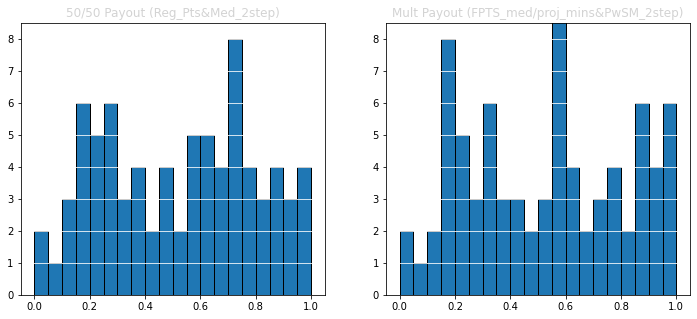

In [961]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist(TR_PER[Winnings.index[0]], bins=np.linspace(0,1,21), edgecolor='black')
title = '50/50 Payout -' + Winnings.index[0]
ax[0].set_title(title, color='lightgray')
ax[0].set_ylim(0,8.5)
ax[0].grid(axis='y', color='white')
ax[1].hist(TR_PER[Winnings_CK.index[0]], bins=np.linspace(0,1,21), edgecolor='black')
title = 'Mult Payout -' + Winnings_CK.index[0]
ax[1].set_title(title, color='lightgray')
ax[1].set_ylim(0,8.5)
ax[1].grid(axis='y', color='white')

In [ ]:
# Found a way to save out contest results more effectively from Draft Kings
## ('https://www.fantasycruncher.com/contest-links/SOC/' is a place to start)
# Going to backtest more effectively with Quarter Jukebox style competitions
# For each method, read in the DK results for each game, and add my optimal lineup in as if I had originally entered
# Re-rank the competition with me in it, as reassign payout
# Log my profits throughout, to record which methods provide the best profits

# Possibly create a similar backtesting structure, but so that I enter as many times as possible (or optimal)
# This could be with all the same create lineup, or with the best n lineups within a method,
# or with the best lineups from n methods

In [962]:
# Let's see how many Quarter Jukebox results we have for each game

N = 0
for i in range(len(TestingResults_PTS)):
    contest = TestingResults_PTS['Contest'][i]
    league = TestingResults_PTS['League'][i]
    fpath = 'DK_standings/'+league+'/'
    flist = os.listdir(fpath)
    res_ctr = 0
    for fname in flist:
        if ((contest in fname) and ('Quarter' in fname)):
            res_ctr+=1
    if (res_ctr>=1): N+=1
    print(contest, '-', res_ctr)

print('')
print('N:', N)

ATH_ALV_20211001 - 0
ATX_RSL_20211002 - 0
DAL_MIN_20211002 - 0
VAN_SJ_20211002 - 0
DSC_LEV_20211003 - 0
LA_LAFC_20211003 - 0
NYC_NSH_20211003 - 0
POR_MIA_20211003 - 0
LIV_MCI_20211003 - 0
RBNY_MIA_20211009 - 0
SEA_VAN_20211009 - 0
TSG_KOE_20211015 - 0
PSG_ANR_20211015 - 0
ATX_MIN_20211016 - 0
CLB_MIA_20211016 - 0
HOU_SEA_20211016 - 0
LAFC_SJ_20211016 - 0
LA_POR_20211016 - 0
MTL_PHI_20211016 - 0
NE_CHI_20211016 - 0
RSL_COL_20211016 - 0
BRE_CHE_20211016 - 0
LEI_MU_20211016 - 0
TOT_NEW_20211017 - 0
ALV_RBB_20211018 - 0
ARS_CRY_20211018 - 0
POR_VAN_20211020 - 0
SEA_POR_20211020 - 0
SJ_ATX_20211020 - 0
M05_FCA_20211022 - 0
ARS_AVL_20211022 - 0
TNO_GEN_20211022 - 0
CLB_RBNY_20211023 - 0
COL_POR_20211023 - 0
SEA_SKC_20211023 - 0
BHA_MCI_20211023 - 0
CHE_NOR_20211023 - 0
EVE_WAT_20211023 - 0
BOC_SGE_20211024 - 1
BAR_RMA_20211024 - 1
ATX_HOU_20211024 - 1
ORL_NE_20211024 - 1
MU_LIV_20211024 - 3
WHU_TOT_20211024 - 2
GTF_CEL_20211025 - 2
VIL_CAD_20211026 - 1
LAFC_SEA_20211026 - 1
RBB_VCF_20211027 

In [1033]:
# There is an excel file in the Backtesting Repository that has the payout structures for every DK contest I've seen
xls = pd.ExcelFile('Backtesting/DK_Contest_Structures.xlsx')
df1 = pd.read_excel(xls, sheet_name=None)

In [1034]:
# Compile this excel doc into a dict

contest_struct = {}
contest_types = list(df1.keys())

#contest_type = contest_types[0]
for contest_type in contest_types:
    col1 = df1[contest_type].columns[0]
    col_list = []
    for c in range(1,len(df1[contest_type].columns)):
        col_list.append('col'+str(c))
    df1[contest_type].columns = [col1]+col_list
    
    contest_struct[contest_type] = {}
    contest_struct[contest_type]['EntryPrice'] = df1[contest_type].columns[0]
    df1[contest_type].columns = ['col0'] + list(df1[contest_type].columns)[1:]

    for c in np.arange(0,len(df1[contest_type].columns),4):
        col1, col2, col3 = 'col'+str(c), 'col'+str(c+1), 'col'+str(c+2)

        total = int(df1[contest_type][col1][0])
        contest_struct[contest_type][total] = {}
        contest_struct[contest_type][total]['Entries'] = df1[contest_type][col2][0]
        contest_struct[contest_type][total]['Multi-Entry'] = df1[contest_type][col3][0]
        contest_struct[contest_type][total]['Prizes'] = {}
        cols = list(df1[contest_type].columns)

        tmp = df1[contest_type].copy()
        tmp = tmp[[col1, col2, col3]]
        tmp = tmp[~pd.isna(tmp[col1])]
        for i in range(1,len(tmp)):
            contest_struct[contest_type][total]['Prizes'][int(tmp[col1][i])] = tmp[col3][i]

In [1035]:
contest_struct

{'DimeTime': {'EntryPrice': 0.1,
  100: {'Entries': 1189.0,
   'Multi-Entry': 20.0,
   'Prizes': {1: 10.0,
    2: 6.0,
    3: 4.0,
    4: 3.0,
    5: 2.0,
    6: 1.5,
    8: 1.0,
    12: 0.75,
    22: 0.5,
    52: 0.4,
    117: 0.3,
    277: 0.2}},
  150: {'Entries': 1783.0,
   'Multi-Entry': 20.0,
   'Prizes': {1: 15.0,
    2: 7.5,
    3: 5.0,
    4: 4.0,
    5: 3.0,
    7: 2.0,
    10: 1.5,
    14: 1.0,
    20: 0.75,
    35: 0.5,
    70: 0.4,
    150: 0.3,
    415: 0.2}},
  250: {'Entries': 2972.0,
   'Multi-Entry': 20.0,
   'Prizes': {1: 25.0,
    2: 15.0,
    3: 8.0,
    4: 5.0,
    5: 4.0,
    6: 3.0,
    8: 2.0,
    10: 1.5,
    13: 1.0,
    23: 0.75,
    48: 0.5,
    113: 0.4,
    283: 0.3,
    698: 0.2}}},
 'Quarter': {'EntryPrice': 0.25,
  20: {'Entries': 95.0,
   'Multi-Entry': 2.0,
   'Prizes': {1: 5.0,
    2: 3.0,
    3: 2.0,
    4: 1.4,
    6: 0.8,
    9: 0.6,
    13: 0.5,
    21: 0.4}},
  50: {'Entries': 237.0,
   'Multi-Entry': 7.0,
   'Prizes': {1: 5.0,
    2: 4.0,
    

In [966]:
# read in the backtesting from earlier - we really only need the contest names, leagues, and the method names
# the other values will be overwritten and used for profit recording
TR_PTS_1step = pd.read_csv('Backtesting/TestingResults_PTS_1step.csv')
TR_PTS_2step = pd.read_csv('Backtesting/TestingResults_PTS_2step.csv')
TR_PTS = pd.merge(left=TR_PTS_1step, right=TR_PTS_2step)
TR_PTS

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,60.64,63.72,60.64,45.74,63.72,59.57,43.28,63.72,59.57,52.20,63.72,48.64,60.64,60.64,45.74,60.64,59.57,60.64,60.64,45.74,60.64,59.57,60.64,60.64,45.74,60.64,48.64,43.28,45.82,45.04,45.04,40.42,57.56
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,75.90,58.54,70.48,53.90,77.94,60.02,75.90,62.28,77.94,62.28,62.28,77.94,58.54,77.94,62.28,77.94,77.94,53.90,53.90,63.38,53.20,60.02,75.90,77.94,58.54,58.54,60.02,61.18,56.62,70.48,53.20,71.58,70.58
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,48.25,45.32,36.82,36.82,45.32,42.60,39.56,45.32,36.82,45.32,45.32,42.60,36.82,36.82,36.82,36.82,48.25,36.82,36.82,36.82,36.82,48.25,36.82,36.82,36.82,36.82,48.25,40.73,48.78,42.28,45.32,48.78,48.25
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,69.94,64.20,99.72,63.40,61.67,41.94,69.94,69.94,114.52,66.78,61.67,44.53,66.94,61.67,60.89,94.45,78.03,66.94,66.94,99.72,66.70,47.29,69.94,99.72,63.40,69.94,46.26,66.94,64.44,114.52,58.13,64.43,44.68
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,96.04,84.10,94.78,101.04,91.62,92.66,111.34,91.59,91.62,111.34,91.62,111.34,100.24,94.78,94.78,94.78,111.34,111.34,111.34,94.78,101.04,111.34,92.72,91.62,111.34,84.10,111.34,92.72,78.24,94.78,109.32,84.10,90.76
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,45.73,45.73,75.03,48.11,72.35,67.21,45.73,45.73,72.35,48.11,72.35,72.35,60.12,72.35,72.35,72.35,75.03,60.12,48.11,72.35,48.11,72.35,45.73,72.35,60.12,45.73,72.35,60.12,48.62,56.95,60.12,48.62,68.13
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,34.65,32.71,36.25,36.25,34.65,39.77,34.65,34.11,36.25,34.65,40.29,40.53,34.65,34.65,36.25,36.25,40.53,34.65,34.65,36.25,36.25,45.03,34.65,32.09,34.65,34.65,40.53,32.71,35.12,36.25,36.25,30.28,40.67
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,59.99,51.17,55.46,57.81,46.95,54.38,59.99,51.17,55.46,57.81,46.95,65.14,61.63,66.85,52.15,54.83,60.74,59.99,67.65,55.46,48.47,53.03,59.99,55.46,45.79,61.63,62.27,51.03,67.65,55.46,58.69,54.83,60.74
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,88.28,88.28,75.60,54.41,88.28,78.04,84.01,84.01,75.60,54.41,88.28,78.04,88.28,88.28,74.42,75.60,80.74,54.41,54.41,64.82,54.41,70.52,88.28,75.60,54.41,88.28,70.52,84.75,87.73,75.60,74.42,62.99,80.28
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,48.29,63.35,53.97,55.97,64.65,53.97,62.61,63.35,53.09,61.49,64.65,53.97,49.21,53.09,53.55,53.97,53.97,47.91,53.09,53.09,53.09,54.33,49.03,63.53,53.55,47.91,53.97,49.03,58.29,52.25,46.73,58.29,59.43


In [967]:
# For games with multiple Quarter results saved, choose on randomly
# as in real life, it's hard to determine when one pay structure will be 
# the actively filling contest

N = 0
for i in range(len(TR_PTS)):
    contest = TR_PTS['Contest'][i]
    league = TR_PTS['League'][i]
    fpath = 'DK_standings/'+league+'/'
    flist = os.listdir(fpath)
    res_ctr = 0
    fnames = []
    for fname in flist:
        if ((contest in fname) and ('Quarter' in fname)):
            fnames.append(fname)
            res_ctr+=1
    if (res_ctr>=1):
        rand = np.random.randint(len(fnames))
        fname = fnames[rand]
        print(fname)
        N+=1
    
    #print(contest, '-', res_ctr)



BOC_SGE_20211024_50_Quarter_standings.csv
BAR_RMA_20211024_50_Quarter_standings.csv
ATX_HOU_20211024_50_Quarter_standings.csv
ORL_NE_20211024_50_Quarter_standings.csv
MU_LIV_20211024_75_Quarter_standings.csv
WHU_TOT_20211024_200_Quarter_standings.csv
GTF_CEL_20211025_75_Quarter_standings.csv
VIL_CAD_20211026_50_Quarter_standings.csv
LAFC_SEA_20211026_50_Quarter_standings.csv
CEL_RSO_20211028_75_Quarter_standings.csv
GRA_GTF_20211028_50_Quarter_standings.csv
LUD_ATL_20211028_50_Quarter_standings.csv
NAP_BOL_20211028_75_Quarter_standings.csv
TSG_BSC_20211029_50_Quarter_standings.csv
PSG_LIL_20211029_50_Quarter_standings.csv
ATL_TOR_20211030_50_Quarter_standings.csv
DAL_ATX_20211030_50_Quarter_standings.csv
DC_CLB_20211030_50_Quarter_standings.csv
MIA_NYC_20211030_50_Quarter_standings.csv
RBNY_MTL_20211030_50_Quarter_standings.csv
RSL_SJ_20211030_50_Quarter_standings.csv
LEI_ARS_20211030_300_Quarter_standings.csv
LIV_BHA_20211030_200_Quarter_standings.csv
TOT_MU_20211030_75_Quarter_standi

In [983]:
contest_family = 'Quarter'

Winnings_Quarter = pd.DataFrame(columns=['Contests','Wins','1st','2nd','3rd','4th','5th','Losses','Win%','Investment','Return','Profit'], index=TR_PTS.columns[7:])
Winnings_Quarter['Contests'] = 0
Winnings_Quarter['Wins'] = 0
Winnings_Quarter['1st'] = 0
Winnings_Quarter['2nd'] = 0
Winnings_Quarter['3rd'] = 0
Winnings_Quarter['4th'] = 0
Winnings_Quarter['5th'] = 0
Winnings_Quarter['Losses'] = 0
Winnings_Quarter['Investment'] = 0
Winnings_Quarter['Return'] = 0
Winnings_Quarter['Profit'] = 0

for method in Winnings_Quarter.index:
    print(method)
    for i in range(len(TR_PTS[method])):
        contest = TR_PTS['Contest'][i]
        league = TR_PTS['League'][i]
        fpath = 'DK_standings/'+league+'/'
        flist = os.listdir(fpath)
        res_ctr = 0
        fnames = []
        for fname in flist:
            if ((contest in fname) and ('Quarter' in fname)):
                fnames.append(fname)
                res_ctr+=1
        if (res_ctr>=1):
            rand = np.random.randint(len(fnames))
            fname = fnames[rand]
            standings = pd.read_csv('DK_standings/'+league+'/'+fname)
            standings = standings[['Rank', 'EntryId', 'EntryName', 'Points']]
            standings = standings[~pd.isna(standings['EntryName'])].reset_index(drop=True)
            #print(fname[:-14])
            #print('Contest Size:', len(standings), 'entries')
            total = int(fname.split('_')[3])
            max_entries = contest_struct[contest_family][total]['Entries']
            if (len(standings) == max_entries): # if the contest is full, remove one entry at random to mainain strucutre integrity
                full=True
                #print('Full Contest\n')
                name_to_drop = '('
                while ('(' in name_to_drop):
                    idx_to_drop = np.random.randint(len(standings))
                    name_to_drop = standings['EntryName'][idx_to_drop]
                rankdropped = standings['Rank'][idx_to_drop]
                #print('Full Contest. Dropped Rank:', rankdropped)
                #print(standings.loc[idx_to_drop])
                standings = standings.drop(index=idx_to_drop).reset_index(drop=True)
            else:
                full=False
                #print('None Dropped.', len(standings), 'of', contest_struct['Quarter'][total]['Entries'], 'in Contest')
            total = int(fname.split('_')[3])
            my_pts = TR_PTS[TR_PTS['Contest'] == contest][method].iloc[0]
            for entry in range(len(standings)):
                if (my_pts > standings['Points'][entry]):
                    my_rank = standings['Rank'][entry] - 1
                    break
                elif (my_pts == standings['Points'][entry]):
                    my_rank = standings['Rank'][entry]
                    break
            #print(my_rank, 'stevensthrill', my_pts 'points -', round(my_rank/len(standings),4), 'percentile')
            # Enter the result of my optimal lineup into the dataframe
            me = {'Rank':my_rank,
                  'EntryId':'',
                  'EntryName':'stevensthrill',
                  'Points':my_pts}
            me_df = pd.DataFrame(columns=standings.columns,
                                 index=[0],
                                 data=me)
            standings = standings.append(me_df)
            standings = standings.sort_values(by='Points', ascending=False).reset_index(drop=True)
            
            # re-rank with myself in the proper position
            standings['Rank'] = 0
            standings['Points'] = standings['Points'].round(2)
            standings['Rank'][0] = 1
            for i in range(1, len(standings)):
                if (standings['Points'][i] == standings['Points'][i-1]):
                    standings['Rank'][i] = standings['Rank'][i-1]
                elif (standings['Points'][i] < standings['Points'][i-1]):
                    standings['Rank'][i] = i+1
            
            # The payout for ties gets pretty complicated
            # Essentially, entries split the sum of the winnings set for the positions they are tied over
            cutoffs = list(contest_struct[contest_family][total]['Prizes'].keys())
            standings['PayStruct'] = 0.0
            standings['PayStruct'][0] = contest_struct['Quarter'][total]['Prizes'][1]
            for i in range(len(standings)):
                pos = i+1
                if (pos in cutoffs):
                    standings['PayStruct'][i] = contest_struct[contest_family][total]['Prizes'][pos]
                elif (pos < cutoffs[-1]):
                    for cut in range(1,len(cutoffs)):
                        if ((pos > cutoffs[cut-1]) and (pos < cutoffs[cut])):
                            standings['PayStruct'][i] = contest_struct[contest_family][total]['Prizes'][cutoffs[cut]]
                            
            standings['Payout'] = 0.0
            for rank in standings['Rank'].unique():
                pay_sum = standings[standings['Rank'] == rank]['PayStruct'].sum()
                num_entries = len(standings[standings['Rank'] == rank]['PayStruct'])
                idxs = list(standings[standings['Rank'] == rank]['PayStruct'].index)
                for idx in idxs:
                    standings['Payout'][idx] = round(pay_sum / num_entries, 2)
            
            profit = standings[standings['EntryName'] == 'stevensthrill']['Payout'].iloc[0] - contest_struct[contest_family]['EntryPrice']
            rank = standings[standings['EntryName'] == 'stevensthrill']['Rank'].iloc[0]
            percentile = round(ranks/len(standings)*100,2)
            #print('Rank:', rank)
            #print('Percentile:', round(my_rank/len(standings)*100,2))
            #print('Profit:', profit)
            #print(my_rank, 'stevensthrill', my_pts 'points -', round(my_rank/len(standings),4), 'percentile')
            if (full):
                print(f"{fname[:-14]} ({len(standings)}/{max_entries})  {rankdropped} Dropped.  Rank {rank} ({percentile}%). {profit} profit.")
            else:
                print(f"{fname[:-14]} ({len(standings)}/{max_entries})  None Dropped.  Rank {rank} ({percentile}%). {profit} profit.")
            
            
            Winnings_Quarter.loc[method,'Contests'] = Winnings_Quarter.loc[method,'Contests'] + 1
            Winnings_Quarter.loc[method,'Investment'] = Winnings_Quarter.loc[method,'Investment'] + contest_struct[contest_family]['EntryPrice']
            Winnings_Quarter.loc[method,'Return'] = Winnings_Quarter.loc[method,'Return'] + (profit+contest_struct[contest_family]['EntryPrice'])
            Winnings_Quarter.loc[method,'Profit'] = Winnings_Quarter.loc[method,'Profit'] + profit
            if (profit < 0):
                Winnings_Quarter.loc[method,'Losses'] = Winnings_Quarter.loc[method,'Losses'] + 1
            else:
                Winnings_Quarter.loc[method,'Wins'] = Winnings_Quarter.loc[method,'Wins'] + 1
            if (rank == 1):
                Winnings_Quarter.loc[method,'1st'] = Winnings_Quarter.loc[method,'1st'] + 1
            elif (rank == 2):
                Winnings_Quarter.loc[method,'2nd'] = Winnings_Quarter.loc[method,'2nd'] + 1
            elif (rank == 3):
                Winnings_Quarter.loc[method,'3rd'] = Winnings_Quarter.loc[method,'3rd'] + 1
            elif (rank == 4):
                Winnings_Quarter.loc[method,'4th'] = Winnings_Quarter.loc[method,'4th'] + 1
            elif (rank == 5):
                Winnings_Quarter.loc[method,'5th'] = Winnings_Quarter.loc[method,'5th'] + 1
                
            #print('')
    print('')
            
        
        
Winnings_Quarter


Pts_w_StartMins
BOC_SGE_20211024_50_Quarter (110/237.0)  None Dropped.  Rank 52 (46.36%). 0.25 profit.
BAR_RMA_20211024_50_Quarter (237/237.0)  100 Dropped.  Rank 124 (52.32%). -0.25 profit.
ATX_HOU_20211024_50_Quarter (213/237.0)  None Dropped.  Rank 88 (40.85%). -0.25 profit.
ORL_NE_20211024_50_Quarter (232/237.0)  None Dropped.  Rank 19 (7.76%). 0.5 profit.
MU_LIV_20211024_50_Quarter (237/237.0)  158 Dropped.  Rank 194 (81.86%). -0.25 profit.
WHU_TOT_20211024_200_Quarter (951/951.0)  489 Dropped.  Rank 444 (46.58%). -0.25 profit.
GTF_CEL_20211025_75_Quarter (356/356.0)  38 Dropped.  Rank 301 (84.55%). -0.25 profit.
VIL_CAD_20211026_50_Quarter (237/237.0)  211 Dropped.  Rank 62 (25.74%). -0.25 profit.
LAFC_SEA_20211026_50_Quarter (237/237.0)  56 Dropped.  Rank 1 (0.0%). 4.75 profit.
CEL_RSO_20211028_75_Quarter (356/356.0)  276 Dropped.  Rank 247 (69.1%). -0.25 profit.
GRA_GTF_20211028_50_Quarter (237/237.0)  135 Dropped.  Rank 92 (38.4%). -0.25 profit.
LUD_ATL_20211028_50_Quarter (23

LIV_BHA_20211030_100_Quarter (475/475.0)  420 Dropped.  Rank 8 (1.68%). 1.5 profit.
TOT_MU_20211030_100_Quarter (475/475.0)  174 Dropped.  Rank 25 (5.05%). 0.5 profit.
HOU_COL_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 46 (31.51%). 0.25 profit.
MIN_SKC_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 142 (96.58%). -0.25 profit.
ORL_NSH_20211031_50_Quarter (143/237.0)  None Dropped.  Rank 114 (79.02%). -0.25 profit.
PHI_CIN_20211031_50_Quarter (145/237.0)  None Dropped.  Rank 132 (90.34%). -0.25 profit.
AVL_WHU_20211031_500_Quarter (1977/2400.0)  None Dropped.  Rank 31 (1.52%). 1.25 profit.
NOR_LEE_20211031_200_Quarter (951/951.0)  835 Dropped.  Rank 25 (2.52%). 0.75 profit.
RVM_CEL_20211101_50_Quarter (237/237.0)  7 Dropped.  Rank 153 (64.56%). -0.25 profit.
SEA_LA_20211101_50_Quarter (237/237.0)  230 Dropped.  Rank 147 (61.6%). -0.25 profit.
WOL_EVE_20211101_625_Quarter (2972/2972.0)  2739 Dropped.  Rank 2392 (80.48%). -0.25 profit.
LAFC_VAN_20211102_50_Quarter (237/237.

LAFC_SEA_20211026_50_Quarter (237/237.0)  49 Dropped.  Rank 1 (0.0%). 4.75 profit.
CEL_RSO_20211028_75_Quarter (356/356.0)  299 Dropped.  Rank 271 (75.84%). -0.25 profit.
GRA_GTF_20211028_50_Quarter (237/237.0)  231 Dropped.  Rank 10 (3.8%). 0.75 profit.
LUD_ATL_20211028_50_Quarter (237/237.0)  48 Dropped.  Rank 19 (7.59%). 0.5 profit.
NAP_BOL_20211028_75_Quarter (356/356.0)  206 Dropped.  Rank 238 (67.13%). -0.25 profit.
TSG_BSC_20211029_50_Quarter (237/237.0)  55 Dropped.  Rank 95 (40.08%). -0.25 profit.
PSG_LIL_20211029_50_Quarter (199/237.0)  None Dropped.  Rank 186 (92.96%). -0.25 profit.
ATL_TOR_20211030_50_Quarter (164/237.0)  None Dropped.  Rank 58 (34.76%). -0.25 profit.
DAL_ATX_20211030_50_Quarter (124/237.0)  None Dropped.  Rank 16 (12.1%). 0.5 profit.
DC_CLB_20211030_50_Quarter (159/237.0)  None Dropped.  Rank 101 (62.89%). -0.25 profit.
MIA_NYC_20211030_50_Quarter (146/237.0)  None Dropped.  Rank 108 (73.29%). -0.25 profit.
RBNY_MTL_20211030_50_Quarter (147/237.0)  None Dr

NOR_LEE_20211031_200_Quarter (951/951.0)  748 Dropped.  Rank 82 (8.52%). 0.5 profit.
RVM_CEL_20211101_50_Quarter (237/237.0)  162 Dropped.  Rank 206 (86.92%). -0.25 profit.
SEA_LA_20211101_50_Quarter (237/237.0)  31 Dropped.  Rank 26 (10.55%). 0.5 profit.
WOL_EVE_20211101_625_Quarter (2972/2972.0)  2664 Dropped.  Rank 1012 (34.05%). -0.25 profit.
LAFC_VAN_20211102_50_Quarter (237/237.0)  166 Dropped.  Rank 181 (76.37%). -0.25 profit.
ATX_SKC_20211103_50_Quarter (206/237.0)  None Dropped.  Rank 83 (39.81%). -0.25 profit.
RSL_POR_20211103_50_Quarter (236/237.0)  None Dropped.  Rank 104 (43.64%). -0.25 profit.

FPTS_med/proj_mins&Salary_2step
BOC_SGE_20211024_50_Quarter (110/237.0)  None Dropped.  Rank 94 (84.55%). -0.25 profit.
BAR_RMA_20211024_50_Quarter (237/237.0)  16 Dropped.  Rank 155 (65.82%). -0.25 profit.
ATX_HOU_20211024_50_Quarter (213/237.0)  None Dropped.  Rank 113 (52.58%). -0.25 profit.
ORL_NE_20211024_50_Quarter (232/237.0)  None Dropped.  Rank 88 (37.5%). -0.25 profit.
MU

PSG_LIL_20211029_50_Quarter (199/237.0)  None Dropped.  Rank 91 (45.23%). -0.25 profit.
ATL_TOR_20211030_50_Quarter (164/237.0)  None Dropped.  Rank 64 (38.41%). -0.25 profit.
DAL_ATX_20211030_50_Quarter (124/237.0)  None Dropped.  Rank 16 (12.1%). 0.5 profit.
DC_CLB_20211030_50_Quarter (159/237.0)  None Dropped.  Rank 63 (38.99%). -0.25 profit.
MIA_NYC_20211030_50_Quarter (146/237.0)  None Dropped.  Rank 108 (73.29%). -0.25 profit.
RBNY_MTL_20211030_50_Quarter (147/237.0)  None Dropped.  Rank 19 (12.93%). 0.5 profit.
RSL_SJ_20211030_50_Quarter (181/237.0)  None Dropped.  Rank 132 (72.38%). -0.25 profit.
LEI_ARS_20211030_50_Quarter (237/237.0)  90 Dropped.  Rank 108 (45.57%). -0.25 profit.
LIV_BHA_20211030_200_Quarter (951/951.0)  186 Dropped.  Rank 41 (4.31%). 0.67 profit.
TOT_MU_20211030_75_Quarter (347/356.0)  None Dropped.  Rank 81 (24.21%). 0.04999999999999999 profit.
HOU_COL_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 111 (76.03%). -0.25 profit.
MIN_SKC_20211031_50_Quart

RSL_POR_20211103_50_Quarter (236/237.0)  None Dropped.  Rank 142 (59.75%). -0.25 profit.

Reg_Pts&Med_2step
BOC_SGE_20211024_50_Quarter (110/237.0)  None Dropped.  Rank 64 (57.27%). -0.25 profit.
BAR_RMA_20211024_50_Quarter (237/237.0)  205 Dropped.  Rank 78 (32.91%). -0.25 profit.
ATX_HOU_20211024_50_Quarter (213/237.0)  None Dropped.  Rank 88 (40.85%). -0.25 profit.
ORL_NE_20211024_50_Quarter (232/237.0)  None Dropped.  Rank 63 (27.16%). -0.25 profit.
MU_LIV_20211024_50_Quarter (237/237.0)  64 Dropped.  Rank 56 (23.21%). -0.25 profit.
WHU_TOT_20211024_75_Quarter (356/356.0)  355 Dropped.  Rank 181 (50.56%). -0.25 profit.
GTF_CEL_20211025_75_Quarter (356/356.0)  282 Dropped.  Rank 206 (57.87%). -0.25 profit.
VIL_CAD_20211026_50_Quarter (237/237.0)  191 Dropped.  Rank 80 (33.33%). -0.25 profit.
LAFC_SEA_20211026_50_Quarter (237/237.0)  125 Dropped.  Rank 1 (0.0%). 4.75 profit.
CEL_RSO_20211028_75_Quarter (356/356.0)  131 Dropped.  Rank 260 (73.03%). -0.25 profit.
GRA_GTF_20211028_50_Qu

RSL_SJ_20211030_50_Quarter (181/237.0)  None Dropped.  Rank 64 (34.81%). -0.25 profit.
LEI_ARS_20211030_50_Quarter (237/237.0)  91 Dropped.  Rank 123 (51.9%). -0.25 profit.
LIV_BHA_20211030_100_Quarter (475/475.0)  421 Dropped.  Rank 8 (1.68%). 1.5 profit.
TOT_MU_20211030_75_Quarter (347/356.0)  None Dropped.  Rank 63 (17.87%). 0.25 profit.
HOU_COL_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 85 (57.53%). -0.25 profit.
MIN_SKC_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 123 (84.25%). -0.25 profit.
ORL_NSH_20211031_50_Quarter (143/237.0)  None Dropped.  Rank 114 (79.02%). -0.25 profit.
PHI_CIN_20211031_50_Quarter (145/237.0)  None Dropped.  Rank 93 (63.45%). -0.25 profit.
AVL_WHU_20211031_500_Quarter (1977/2400.0)  None Dropped.  Rank 512 (25.9%). 0.25 profit.
NOR_LEE_20211031_200_Quarter (951/951.0)  46 Dropped.  Rank 25 (2.63%). 0.75 profit.
RVM_CEL_20211101_50_Quarter (237/237.0)  229 Dropped.  Rank 224 (94.09%). -0.25 profit.
SEA_LA_20211101_50_Quarter (237/237.0)  

GTF_CEL_20211025_50_Quarter (237/237.0)  50 Dropped.  Rank 66 (28.27%). -0.25 profit.
VIL_CAD_20211026_50_Quarter (237/237.0)  183 Dropped.  Rank 80 (33.33%). -0.25 profit.
LAFC_SEA_20211026_50_Quarter (237/237.0)  95 Dropped.  Rank 1 (0.0%). 4.75 profit.
CEL_RSO_20211028_75_Quarter (356/356.0)  58 Dropped.  Rank 260 (73.03%). -0.25 profit.
GRA_GTF_20211028_50_Quarter (237/237.0)  163 Dropped.  Rank 91 (37.97%). -0.25 profit.
LUD_ATL_20211028_50_Quarter (237/237.0)  83 Dropped.  Rank 18 (7.17%). 0.5 profit.
NAP_BOL_20211028_75_Quarter (356/356.0)  16 Dropped.  Rank 151 (42.42%). -0.25 profit.
TSG_BSC_20211029_50_Quarter (237/237.0)  160 Dropped.  Rank 77 (32.07%). -0.25 profit.
PSG_LIL_20211029_50_Quarter (199/237.0)  None Dropped.  Rank 194 (96.98%). -0.25 profit.
ATL_TOR_20211030_50_Quarter (164/237.0)  None Dropped.  Rank 107 (64.63%). -0.25 profit.
DAL_ATX_20211030_50_Quarter (124/237.0)  None Dropped.  Rank 16 (12.1%). 0.5 profit.
DC_CLB_20211030_50_Quarter (159/237.0)  None Dropp

AVL_WHU_20211031_500_Quarter (1977/2400.0)  None Dropped.  Rank 961 (48.61%). -0.25 profit.
NOR_LEE_20211031_200_Quarter (951/951.0)  158 Dropped.  Rank 37 (3.79%). 0.75 profit.
RVM_CEL_20211101_50_Quarter (237/237.0)  156 Dropped.  Rank 223 (94.09%). -0.25 profit.
SEA_LA_20211101_50_Quarter (237/237.0)  235 Dropped.  Rank 138 (57.81%). -0.25 profit.
WOL_EVE_20211101_625_Quarter (2972/2972.0)  733 Dropped.  Rank 291 (9.79%). 0.25 profit.
LAFC_VAN_20211102_50_Quarter (237/237.0)  117 Dropped.  Rank 162 (68.35%). -0.25 profit.
ATX_SKC_20211103_50_Quarter (206/237.0)  None Dropped.  Rank 83 (39.81%). -0.25 profit.
RSL_POR_20211103_50_Quarter (236/237.0)  None Dropped.  Rank 133 (55.93%). -0.25 profit.

XGB_Reg&MedxG_2step
BOC_SGE_20211024_50_Quarter (110/237.0)  None Dropped.  Rank 34 (30.0%). 0.25 profit.
BAR_RMA_20211024_50_Quarter (237/237.0)  42 Dropped.  Rank 168 (70.89%). -0.25 profit.
ATX_HOU_20211024_50_Quarter (213/237.0)  None Dropped.  Rank 68 (31.46%). -0.25 profit.
ORL_NE_202

TSG_BSC_20211029_50_Quarter (237/237.0)  174 Dropped.  Rank 60 (24.89%). -0.25 profit.
PSG_LIL_20211029_50_Quarter (199/237.0)  None Dropped.  Rank 48 (23.62%). 0.25 profit.
ATL_TOR_20211030_50_Quarter (164/237.0)  None Dropped.  Rank 58 (34.76%). -0.25 profit.
DAL_ATX_20211030_50_Quarter (124/237.0)  None Dropped.  Rank 11 (8.06%). 0.75 profit.
DC_CLB_20211030_50_Quarter (159/237.0)  None Dropped.  Rank 63 (38.99%). -0.25 profit.
MIA_NYC_20211030_50_Quarter (146/237.0)  None Dropped.  Rank 108 (73.29%). -0.25 profit.
RBNY_MTL_20211030_50_Quarter (147/237.0)  None Dropped.  Rank 66 (44.22%). -0.25 profit.
RSL_SJ_20211030_50_Quarter (181/237.0)  None Dropped.  Rank 64 (34.81%). -0.25 profit.
LEI_ARS_20211030_50_Quarter (237/237.0)  98 Dropped.  Rank 201 (84.81%). -0.25 profit.
LIV_BHA_20211030_200_Quarter (951/951.0)  286 Dropped.  Rank 3 (0.21%). 7.25 profit.
TOT_MU_20211030_100_Quarter (475/475.0)  104 Dropped.  Rank 84 (17.47%). 0.25 profit.
HOU_COL_20211031_50_Quarter (146/237.0)  N

RSL_POR_20211103_50_Quarter (236/237.0)  None Dropped.  Rank 144 (60.59%). -0.25 profit.

XGB_Reg&PwSM_2step
BOC_SGE_20211024_50_Quarter (110/237.0)  None Dropped.  Rank 64 (57.27%). -0.25 profit.
BAR_RMA_20211024_50_Quarter (237/237.0)  139 Dropped.  Rank 73 (30.38%). -0.25 profit.
ATX_HOU_20211024_50_Quarter (213/237.0)  None Dropped.  Rank 7 (3.29%). 1.25 profit.
ORL_NE_20211024_50_Quarter (232/237.0)  None Dropped.  Rank 19 (7.76%). 0.5 profit.
MU_LIV_20211024_50_Quarter (237/237.0)  75 Dropped.  Rank 199 (83.97%). -0.25 profit.
WHU_TOT_20211024_75_Quarter (356/356.0)  174 Dropped.  Rank 220 (61.8%). -0.25 profit.
GTF_CEL_20211025_50_Quarter (237/237.0)  18 Dropped.  Rank 199 (83.97%). -0.25 profit.
VIL_CAD_20211026_50_Quarter (237/237.0)  73 Dropped.  Rank 79 (33.33%). -0.25 profit.
LAFC_SEA_20211026_50_Quarter (237/237.0)  95 Dropped.  Rank 1 (0.0%). 4.75 profit.
CEL_RSO_20211028_75_Quarter (356/356.0)  200 Dropped.  Rank 260 (73.03%). -0.25 profit.
GRA_GTF_20211028_50_Quarter (2

LEI_ARS_20211030_300_Quarter (1427/1400.0)  None Dropped.  Rank 621 (43.52%). -0.25 profit.
LIV_BHA_20211030_200_Quarter (951/951.0)  554 Dropped.  Rank 8 (0.74%). 1.75 profit.
TOT_MU_20211030_75_Quarter (347/356.0)  None Dropped.  Rank 87 (24.78%). -0.25 profit.
HOU_COL_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 99 (67.12%). -0.25 profit.
MIN_SKC_20211031_50_Quarter (146/237.0)  None Dropped.  Rank 11 (6.85%). 0.75 profit.
ORL_NSH_20211031_50_Quarter (143/237.0)  None Dropped.  Rank 71 (48.95%). -0.25 profit.
PHI_CIN_20211031_50_Quarter (145/237.0)  None Dropped.  Rank 47 (31.72%). 0.25 profit.
AVL_WHU_20211031_500_Quarter (1977/2400.0)  None Dropped.  Rank 213 (10.72%). 0.5 profit.
NOR_LEE_20211031_200_Quarter (951/951.0)  942 Dropped.  Rank 4 (0.32%). 4.75 profit.
RVM_CEL_20211101_50_Quarter (237/237.0)  232 Dropped.  Rank 197 (82.7%). -0.25 profit.
SEA_LA_20211101_50_Quarter (237/237.0)  9 Dropped.  Rank 141 (59.49%). -0.25 profit.
WOL_EVE_20211101_625_Quarter (2972/2972.

GTF_CEL_20211025_50_Quarter (237/237.0)  226 Dropped.  Rank 143 (59.92%). -0.25 profit.
VIL_CAD_20211026_50_Quarter (237/237.0)  116 Dropped.  Rank 50 (20.68%). 0.25 profit.
LAFC_SEA_20211026_50_Quarter (237/237.0)  78 Dropped.  Rank 24 (9.7%). 0.5 profit.
CEL_RSO_20211028_75_Quarter (356/356.0)  169 Dropped.  Rank 297 (83.43%). -0.25 profit.
GRA_GTF_20211028_50_Quarter (237/237.0)  134 Dropped.  Rank 134 (56.54%). -0.25 profit.
LUD_ATL_20211028_50_Quarter (237/237.0)  31 Dropped.  Rank 13 (5.06%). 0.75 profit.
NAP_BOL_20211028_75_Quarter (356/356.0)  277 Dropped.  Rank 192 (53.93%). -0.25 profit.
TSG_BSC_20211029_50_Quarter (237/237.0)  116 Dropped.  Rank 47 (19.41%). 0.25 profit.
PSG_LIL_20211029_50_Quarter (199/237.0)  None Dropped.  Rank 91 (45.23%). -0.25 profit.
ATL_TOR_20211030_50_Quarter (164/237.0)  None Dropped.  Rank 107 (64.63%). -0.25 profit.
DAL_ATX_20211030_50_Quarter (124/237.0)  None Dropped.  Rank 18 (13.71%). 0.5 profit.
DC_CLB_20211030_50_Quarter (159/237.0)  None D

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Investment,Return,Profit
Pts_w_StartMins,36,11,1,0,0,0,0,25,NaN,9.0,13.00,4.00
Reg_Pts,36,13,0,0,1,0,0,23,NaN,9.0,12.30,3.30
FPTS_med/proj_mins,36,10,0,0,0,0,0,26,NaN,9.0,9.25,0.25
FPTS_xG_med/proj_mins,36,11,1,1,0,0,0,25,NaN,9.0,17.00,8.00
Med_Reg,36,10,1,0,0,0,0,26,NaN,9.0,11.92,2.92
XGB_Reg,36,14,1,1,0,0,0,22,NaN,9.0,17.75,8.75
Pts_w_StartMins&Salary_2step,36,9,1,0,0,0,0,27,NaN,9.0,10.30,1.30
Reg_Pts&Salary_2step,36,11,0,0,1,0,0,25,NaN,9.0,9.50,0.50
FPTS_med/proj_mins&Salary_2step,36,10,0,0,0,0,0,26,NaN,9.0,7.75,-1.25
FPTS_xG_med/proj_mins&Salary_2step,36,15,1,2,0,0,0,21,NaN,9.0,22.50,13.50


In [984]:
Winnings_Quarter['Win%'] = Winnings_Quarter['Wins'] / Winnings_Quarter['Contests']
Winnings_Quarter = Winnings_Quarter.sort_values(by='Profit', ascending=False)
Winnings_Quarter

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Investment,Return,Profit
FPTS_xG_med/proj_mins&Salary_2step,36,15,1,2,0,0,0,21,0.416667,9.0,22.50,13.50
FPTS_xG_med/proj_mins&PwSM_2step,36,13,1,0,1,0,0,23,0.361111,9.0,20.50,11.50
Reg_Pts&StDev_2step,36,15,1,0,0,1,0,21,0.416667,9.0,19.17,10.17
Pts_w_StartMins&StDev_2step,36,13,1,0,0,0,0,23,0.361111,9.0,18.50,9.50
XGB_Reg,36,14,1,1,0,0,0,22,0.388889,9.0,17.75,8.75
Med_Reg&MedxG_2step,36,11,1,1,0,0,0,25,0.305556,9.0,17.50,8.50
FPTS_med/proj_mins&PwSM_2step,36,9,1,0,1,0,0,27,0.250000,9.0,17.25,8.25
FPTS_xG_med/proj_mins,36,11,1,1,0,0,0,25,0.305556,9.0,17.00,8.00
FPTS_med/proj_mins&MedxG_2step,36,8,1,0,1,0,0,28,0.222222,9.0,16.25,7.25
Pts_w_StartMins&MedxG_2step,36,13,1,0,0,0,0,23,0.361111,9.0,16.25,7.25


In [1050]:
# Let's try multi-entry
contest_family = 'Quarter'
#multi_entry_set = 4

Winnings_Quarter4 = pd.DataFrame(columns=['Contests','Wins','1st','2nd','3rd','4th','5th','Losses','Win%','Investment','Return','Profit'], index=TR_PTS.columns[7:])
Winnings_Quarter4['Contests'] = 0
Winnings_Quarter4['Wins'] = 0
Winnings_Quarter4['1st'] = 0
Winnings_Quarter4['2nd'] = 0
Winnings_Quarter4['3rd'] = 0
Winnings_Quarter4['4th'] = 0
Winnings_Quarter4['5th'] = 0
Winnings_Quarter4['Losses'] = 0
Winnings_Quarter4['Investment'] = 0
Winnings_Quarter4['Return'] = 0
Winnings_Quarter4['Profit'] = 0

for method in Winnings_Quarter4.index:
#for method in ['XGB_Reg']:
    print(method)
    for i in range(len(TR_PTS[method])):
    #for i in [41]:
        contest = TR_PTS['Contest'][i]
        league = TR_PTS['League'][i]
        fpath = 'DK_standings/'+league+'/'
        flist = os.listdir(fpath)
        res_ctr = 0
        fnames = []
        for fname in flist:
            if ((contest in fname) and ('Quarter' in fname)):
                fnames.append(fname)
                res_ctr+=1
        if (res_ctr>=1):
            rand = np.random.randint(len(fnames))
            fname = fnames[rand]
            if ('_20_Quarter' in fname): multi_entry = 2 # only 2 entries max in $20 Quarter Jukebox only
            else: multi_entry = 4
            standings = pd.read_csv('DK_standings/'+league+'/'+fname)
            standings = standings[['Rank', 'EntryId', 'EntryName', 'Points']]
            standings = standings[~pd.isna(standings['EntryName'])].reset_index(drop=True)
            orig_size = len(standings)
            #print(fname[:-14])
            #print('Contest Size:', len(standings), 'entries')
            total = int(fname.split('_')[3])
            max_entries = int(contest_struct[contest_family][total]['Entries'])
            if ((len(standings)+multi_entry) >= max_entries):
                full=True
                #print('Full Contest\n')
                name_to_drop = '('
                dropped_idxs = []
                dropped_names = []
                dropped_ranks = []
                rank_to_drop = -999
                for z in range((len(standings)+multi_entry)-max_entries):
                    while (('(' in name_to_drop) or (rank_to_drop in dropped_ranks)):
                        idx_to_drop = np.random.randint(len(standings))
                        name_to_drop = standings['EntryName'][idx_to_drop]
                        rank_to_drop = standings['Rank'][idx_to_drop]
                    dropped_idxs.append(idx_to_drop)
                    dropped_names.append(name_to_drop)
                    dropped_ranks.append(rank_to_drop)
                #print('Full Contest. Dropped Rank:', rankdropped)
                #print(standings.loc[idx_to_drop])
                standings = standings.drop(index=dropped_idxs).reset_index(drop=True)
            else:
                full=False
                #print('None Dropped.', len(standings), 'of', contest_struct['Quarter'][total]['Entries'], 'in Contest')
            total = int(fname.split('_')[3])
            my_pts = TR_PTS[TR_PTS['Contest'] == contest][method].iloc[0]
            for entry in range(len(standings)):
                if (my_pts > standings['Points'][entry]):
                    my_rank = standings['Rank'][entry] - 1
                    break
                elif (my_pts == standings['Points'][entry]):
                    my_rank = standings['Rank'][entry]
                    break
            #print(my_rank, 'stevensthrill', my_pts 'points -', round(my_rank/len(standings),4), 'percentile')
            me = {'Rank':my_rank,
                  'EntryId':'',
                  'EntryName':'stevensthrill',
                  'Points':my_pts}
            me_df = pd.DataFrame(columns=standings.columns,
                                 index=range(multi_entry),
                                 data=me)
            standings = standings.append(me_df)
            standings = standings.sort_values(by='Points', ascending=False).reset_index(drop=True)
            
            standings['Rank'] = 0
            standings['Points'] = standings['Points'].round(2)
            standings['Rank'][0] = 1
            for i in range(1, len(standings)):
                if (standings['Points'][i] == standings['Points'][i-1]):
                    standings['Rank'][i] = standings['Rank'][i-1]
                elif (standings['Points'][i] < standings['Points'][i-1]):
                    standings['Rank'][i] = i+1
                    
            cutoffs = list(contest_struct[contest_family][total]['Prizes'].keys())
            standings['PayStruct'] = 0.0
            standings['PayStruct'][0] = contest_struct['Quarter'][total]['Prizes'][1]
            for i in range(len(standings)):
                pos = i+1
                if (pos in cutoffs):
                    standings['PayStruct'][i] = contest_struct[contest_family][total]['Prizes'][pos]
                elif (pos < cutoffs[-1]):
                    for cut in range(1,len(cutoffs)):
                        if ((pos > cutoffs[cut-1]) and (pos < cutoffs[cut])):
                            standings['PayStruct'][i] = contest_struct[contest_family][total]['Prizes'][cutoffs[cut]]
                            
            standings['Payout'] = 0.0
            for rank in standings['Rank'].unique():
                pay_sum = standings[standings['Rank'] == rank]['PayStruct'].sum()
                num_entries = len(standings[standings['Rank'] == rank]['PayStruct'])
                idxs = list(standings[standings['Rank'] == rank]['PayStruct'].index)
                for idx in idxs:
                    standings['Payout'][idx] = round(pay_sum / num_entries, 2)
            
            profit = standings[standings['EntryName'] == 'stevensthrill']['Payout'].sum() - (contest_struct[contest_family]['EntryPrice']*multi_entry)
            rank = standings[standings['EntryName'] == 'stevensthrill']['Rank'].iloc[0]
            percentile = round(rank/len(standings)*100,2)
            #print('Rank:', rank)
            #print('Percentile:', round(my_rank/len(standings)*100,2))
            #print('Profit:', profit)
            #print(my_rank, 'stevensthrill', my_pts 'points -', round(my_rank/len(standings),4), 'percentile')
            if (full):
                print(f"{fname[:-14]:<30}{'('+str(orig_size)+'/'+str(max_entries)+')':<14}{str(sorted(dropped_ranks))+' Dropped.':<34}Rank {rank:<6}{'('+str(percentile)+'%)':<8}  {profit:>5.2f} profit.")    
            else:
                print(f"{fname[:-14]:<30}{'('+str(orig_size)+'/'+str(max_entries)+')':<14}None Dropped.                     Rank {rank:<6}{'('+str(percentile)+'%)':<8}  {profit:>5.2f} profit.")
            
            
            Winnings_Quarter4.loc[method,'Contests'] = Winnings_Quarter4.loc[method,'Contests'] + 1
            Winnings_Quarter4.loc[method,'Investment'] = Winnings_Quarter4.loc[method,'Investment'] + contest_struct[contest_family]['EntryPrice']*multi_entry
            Winnings_Quarter4.loc[method,'Return'] = Winnings_Quarter4.loc[method,'Return'] + (profit+(contest_struct[contest_family]['EntryPrice']*multi_entry))
            Winnings_Quarter4.loc[method,'Profit'] = Winnings_Quarter4.loc[method,'Profit'] + profit
            if (profit < 0):
                Winnings_Quarter4.loc[method,'Losses'] = Winnings_Quarter4.loc[method,'Losses'] + 1
            else:
                Winnings_Quarter4.loc[method,'Wins'] = Winnings_Quarter4.loc[method,'Wins'] + 1
            if (rank == 1):
                Winnings_Quarter4.loc[method,'1st'] = Winnings_Quarter4.loc[method,'1st'] + 1
            elif (rank == 2):
                Winnings_Quarter4.loc[method,'2nd'] = Winnings_Quarter4.loc[method,'2nd'] + 1
            elif (rank == 3):
                Winnings_Quarter4.loc[method,'3rd'] = Winnings_Quarter4.loc[method,'3rd'] + 1
            elif (rank == 4):
                Winnings_Quarter4.loc[method,'4th'] = Winnings_Quarter4.loc[method,'4th'] + 1
            elif (rank == 5):
                Winnings_Quarter4.loc[method,'5th'] = Winnings_Quarter4.loc[method,'5th'] + 1
                
            #print('')
    print('')
            
Winnings_Quarter4

Pts_w_StartMins
BOC_SGE_20211024_50_Quarter   (109/237)     None Dropped.                     Rank 52    (46.02%)   1.00 profit.
BAR_RMA_20211024_50_Quarter   (237/237)     [99, 152, 156, 193] Dropped.      Rank 124   (52.32%)  -1.00 profit.
ATX_HOU_20211024_50_Quarter   (212/237)     None Dropped.                     Rank 88    (40.74%)  -1.00 profit.
ORL_NE_20211024_50_Quarter    (231/237)     None Dropped.                     Rank 19    (8.09%)    2.00 profit.
MU_LIV_20211024_500_Quarter   (2378/2378)   [35, 467, 879, 2162] Dropped.     Rank 1813  (76.24%)  -1.00 profit.
WHU_TOT_20211024_75_Quarter   (356/356)     [267, 283, 324, 330] Dropped.     Rank 152   (42.7%)   -1.00 profit.
GTF_CEL_20211025_50_Quarter   (237/237)     [102, 112, 118, 199] Dropped.     Rank 196   (82.7%)   -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [24, 119, 142, 191] Dropped.      Rank 61    (25.74%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [49, 55, 201, 214] Dropped.       Ra

BAR_RMA_20211024_50_Quarter   (237/237)     [32, 101, 127, 196] Dropped.      Rank 153   (64.56%)  -1.00 profit.
ATX_HOU_20211024_50_Quarter   (212/237)     None Dropped.                     Rank 113   (52.31%)  -1.00 profit.
ORL_NE_20211024_50_Quarter    (231/237)     None Dropped.                     Rank 80    (34.04%)  -1.00 profit.
MU_LIV_20211024_500_Quarter   (2378/2378)   [358, 565, 1561, 1814] Dropped.   Rank 792   (33.31%)  -1.00 profit.
WHU_TOT_20211024_75_Quarter   (356/356)     [26, 162, 297, 317] Dropped.      Rank 108   (30.34%)  -1.00 profit.
GTF_CEL_20211025_50_Quarter   (237/237)     [6, 94, 166, 182] Dropped.        Rank 68    (28.69%)  -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [20, 109, 116, 211] Dropped.      Rank 79    (33.33%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [120, 163, 180, 220] Dropped.     Rank 11    (4.64%)    3.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [34, 80, 87, 279] Dropped.        Rank 325   (91.29%

ATX_HOU_20211024_50_Quarter   (212/237)     None Dropped.                     Rank 113   (52.31%)  -1.00 profit.
ORL_NE_20211024_50_Quarter    (231/237)     None Dropped.                     Rank 63    (26.81%)  -1.00 profit.
MU_LIV_20211024_50_Quarter    (237/237)     [52, 128, 138, 185] Dropped.      Rank 78    (32.91%)  -1.00 profit.
WHU_TOT_20211024_75_Quarter   (356/356)     [155, 196, 259, 270] Dropped.     Rank 109   (30.62%)  -1.00 profit.
GTF_CEL_20211025_75_Quarter   (356/356)     [28, 87, 154, 203] Dropped.       Rank 202   (56.74%)  -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [104, 146, 172, 190] Dropped.     Rank 80    (33.76%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [90, 127, 158, 218] Dropped.      Rank 1     (0.42%)   13.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [43, 48, 110, 346] Dropped.       Rank 258   (72.47%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [22, 128, 132, 137] Dropped.      Rank 195   (82.28%

ORL_NE_20211024_50_Quarter    (231/237)     None Dropped.                     Rank 113   (48.09%)  -1.00 profit.
MU_LIV_20211024_75_Quarter    (356/356)     [129, 133, 218, 342] Dropped.     Rank 245   (68.82%)  -1.00 profit.
WHU_TOT_20211024_75_Quarter   (356/356)     [107, 175, 205, 300] Dropped.     Rank 201   (56.46%)  -1.00 profit.
GTF_CEL_20211025_50_Quarter   (237/237)     [18, 32, 213, 232] Dropped.       Rank 191   (80.59%)  -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [49, 93, 169, 210] Dropped.       Rank 79    (33.33%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [54, 201, 207, 220] Dropped.      Rank 1     (0.42%)   13.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [35, 93, 141, 342] Dropped.       Rank 139   (39.04%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [130, 163, 190, 204] Dropped.     Rank 92    (38.82%)  -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [49, 123, 184, 230] Dropped.      Rank 19    (8.02%)

MU_LIV_20211024_500_Quarter   (2378/2378)   [364, 563, 645, 1479] Dropped.    Rank 791   (33.26%)  -1.00 profit.
WHU_TOT_20211024_75_Quarter   (356/356)     [222, 250, 283, 308] Dropped.     Rank 178   (50.0%)   -1.00 profit.
GTF_CEL_20211025_75_Quarter   (356/356)     [110, 179, 240, 297] Dropped.     Rank 129   (36.24%)  -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [37, 73, 188, 191] Dropped.       Rank 13    (5.49%)    2.52 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [56, 72, 161, 218] Dropped.       Rank 58    (24.47%)  -1.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [68, 137, 181, 209] Dropped.      Rank 265   (74.44%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [22, 104, 134, 222] Dropped.      Rank 180   (75.95%)  -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [108, 113, 192, 205] Dropped.     Rank 18    (7.59%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [45, 90, 123, 184] Dropped.       Rank 227   (63.76%

MU_LIV_20211024_500_Quarter   (2378/2378)   [274, 533, 724, 1169] Dropped.    Rank 763   (32.09%)  -1.00 profit.
WHU_TOT_20211024_75_Quarter   (356/356)     [79, 265, 282, 317] Dropped.      Rank 233   (65.45%)  -1.00 profit.
GTF_CEL_20211025_50_Quarter   (237/237)     [15, 46, 50, 140] Dropped.        Rank 64    (27.0%)   -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [28, 73, 188, 210] Dropped.       Rank 68    (28.69%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [90, 191, 200, 215] Dropped.      Rank 3     (1.27%)    7.48 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [228, 236, 257, 260] Dropped.     Rank 267   (75.0%)   -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [57, 189, 190, 235] Dropped.      Rank 196   (82.7%)   -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [57, 79, 96, 222] Dropped.        Rank 19    (8.02%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [113, 135, 148, 184] Dropped.     Rank 235   (66.01%

WHU_TOT_20211024_200_Quarter  (951/951)     [263, 322, 520, 924] Dropped.     Rank 533   (56.05%)  -1.00 profit.
GTF_CEL_20211025_75_Quarter   (356/356)     [128, 213, 240, 250] Dropped.     Rank 288   (80.9%)   -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [26, 37, 126, 211] Dropped.       Rank 78    (32.91%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [54, 138, 169, 220] Dropped.      Rank 1     (0.42%)   13.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [189, 221, 249, 303] Dropped.     Rank 245   (68.82%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [137, 190, 223, 233] Dropped.     Rank 64    (27.0%)   -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [3, 23, 115, 184] Dropped.        Rank 17    (7.17%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [135, 146, 180, 195] Dropped.     Rank 150   (42.13%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [32, 33, 91, 196] Dropped.        Rank 92    (38.82%

GTF_CEL_20211025_50_Quarter   (237/237)     [9, 59, 83, 102] Dropped.         Rank 70    (29.54%)  -1.00 profit.
VIL_CAD_20211026_50_Quarter   (237/237)     [1, 24, 69, 140] Dropped.         Rank 77    (32.49%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [49, 200, 212, 220] Dropped.      Rank 1     (0.42%)   13.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [113, 132, 141, 170] Dropped.     Rank 273   (76.69%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [2, 113, 205, 219] Dropped.       Rank 197   (83.12%)  -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [31, 194, 198, 205] Dropped.      Rank 18    (7.59%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [20, 110, 116, 227] Dropped.      Rank 149   (41.85%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [97, 124, 125, 226] Dropped.      Rank 141   (59.49%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 133   (65.84%

VIL_CAD_20211026_50_Quarter   (237/237)     [90, 95, 109, 178] Dropped.       Rank 80    (33.76%)  -1.00 profit.
LAFC_SEA_20211026_50_Quarter  (237/237)     [100, 125, 164, 220] Dropped.     Rank 1     (0.42%)   13.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [46, 54, 87, 116] Dropped.        Rank 257   (72.19%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [118, 205, 218, 219] Dropped.     Rank 33    (13.92%)   1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [13, 57, 130, 234] Dropped.       Rank 17    (7.17%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [87, 218, 231, 344] Dropped.      Rank 236   (66.29%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [2, 37, 150, 173] Dropped.        Rank 75    (31.65%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 176   (87.13%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 58    (34.73%

LAFC_SEA_20211026_50_Quarter  (237/237)     [139, 158, 169, 213] Dropped.     Rank 1     (0.42%)   13.00 profit.
CEL_RSO_20211028_75_Quarter   (356/356)     [53, 93, 249, 331] Dropped.       Rank 258   (72.47%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [20, 47, 104, 117] Dropped.       Rank 89    (37.55%)  -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [43, 131, 187, 188] Dropped.      Rank 18    (7.59%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [176, 177, 288, 355] Dropped.     Rank 152   (42.7%)   -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [78, 107, 110, 157] Dropped.      Rank 77    (32.49%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 194   (96.04%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 107   (64.07%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 16    (12.6%)

CEL_RSO_20211028_75_Quarter   (356/356)     [160, 167, 187, 342] Dropped.     Rank 142   (39.89%)  -1.00 profit.
GRA_GTF_20211028_50_Quarter   (237/237)     [118, 130, 152, 190] Dropped.     Rank 201   (84.81%)  -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [49, 79, 205, 216] Dropped.       Rank 18    (7.59%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [146, 202, 288, 355] Dropped.     Rank 151   (42.42%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [64, 91, 151, 192] Dropped.       Rank 54    (22.78%)   0.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 160   (79.21%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 107   (64.07%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 18    (14.17%)   2.00 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 74    (45.68%

GRA_GTF_20211028_50_Quarter   (237/237)     [88, 204, 209, 221] Dropped.      Rank 91    (38.4%)   -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [11, 13, 126, 234] Dropped.       Rank 12    (5.06%)    2.76 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [41, 110, 227, 292] Dropped.      Rank 263   (73.88%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [2, 37, 182, 204] Dropped.        Rank 65    (27.43%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 175   (86.63%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 64    (38.32%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 8     (6.3%)     3.40 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 76    (46.91%)  -1.00 profit.
MIA_NYC_20211030_50_Quarter   (145/237)     None Dropped.                     Rank 118   (79.19%

GRA_GTF_20211028_50_Quarter   (237/237)     [135, 185, 196, 233] Dropped.     Rank 129   (54.43%)  -1.00 profit.
LUD_ATL_20211028_50_Quarter   (237/237)     [117, 120, 122, 216] Dropped.     Rank 18    (7.59%)    2.00 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [46, 201, 202, 312] Dropped.      Rank 151   (42.42%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [33, 60, 86, 208] Dropped.        Rank 141   (59.49%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 194   (96.04%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 107   (64.07%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 14    (11.02%)   2.24 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 56    (34.57%)  -1.00 profit.
MIA_NYC_20211030_50_Quarter   (145/237)     None Dropped.                     Rank 77    (51.68%

LUD_ATL_20211028_50_Quarter   (237/237)     [43, 61, 86, 205] Dropped.        Rank 13    (5.49%)    2.52 profit.
NAP_BOL_20211028_75_Quarter   (356/356)     [121, 161, 195, 277] Dropped.     Rank 151   (42.42%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [86, 147, 182, 208] Dropped.      Rank 77    (32.49%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 194   (96.04%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 58    (34.73%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 8     (6.3%)     3.40 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 76    (46.91%)  -1.00 profit.
MIA_NYC_20211030_50_Quarter   (145/237)     None Dropped.                     Rank 118   (79.19%)  -1.00 profit.
RBNY_MTL_20211030_50_Quarter  (146/237)     None Dropped.                     Rank 66    (44.0%)

NAP_BOL_20211028_75_Quarter   (356/356)     [19, 20, 111, 319] Dropped.       Rank 1     (0.28%)   11.44 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [36, 37, 50, 55] Dropped.         Rank 56    (23.63%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 144   (71.29%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 107   (64.07%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 16    (12.6%)    2.00 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 152   (93.83%)  -1.00 profit.
MIA_NYC_20211030_50_Quarter   (145/237)     None Dropped.                     Rank 108   (72.48%)  -1.00 profit.
RBNY_MTL_20211030_50_Quarter  (146/237)     None Dropped.                     Rank 42    (28.0%)    1.00 profit.
RSL_SJ_20211030_50_Quarter    (180/237)     None Dropped.                     Rank 132   (71.74%

NAP_BOL_20211028_75_Quarter   (356/356)     [6, 110, 258, 355] Dropped.       Rank 207   (58.15%)  -1.00 profit.
TSG_BSC_20211029_50_Quarter   (237/237)     [65, 119, 130, 226] Dropped.      Rank 143   (60.34%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 195   (96.53%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 107   (64.07%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 18    (14.17%)   2.00 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 44    (27.16%)   1.00 profit.
MIA_NYC_20211030_50_Quarter   (145/237)     None Dropped.                     Rank 101   (67.79%)  -1.00 profit.
RBNY_MTL_20211030_50_Quarter  (146/237)     None Dropped.                     Rank 62    (41.33%)  -1.00 profit.
RSL_SJ_20211030_50_Quarter    (180/237)     None Dropped.                     Rank 64    (34.78%

TSG_BSC_20211029_50_Quarter   (237/237)     [33, 37, 86, 213] Dropped.        Rank 93    (39.24%)  -1.00 profit.
PSG_LIL_20211029_50_Quarter   (198/237)     None Dropped.                     Rank 194   (96.04%)  -1.00 profit.
ATL_TOR_20211030_50_Quarter   (163/237)     None Dropped.                     Rank 58    (34.73%)  -1.00 profit.
DAL_ATX_20211030_50_Quarter   (123/237)     None Dropped.                     Rank 16    (12.6%)    2.00 profit.
DC_CLB_20211030_50_Quarter    (158/237)     None Dropped.                     Rank 119   (73.46%)  -1.00 profit.
MIA_NYC_20211030_50_Quarter   (145/237)     None Dropped.                     Rank 118   (79.19%)  -1.00 profit.
RBNY_MTL_20211030_50_Quarter  (146/237)     None Dropped.                     Rank 19    (12.67%)   2.00 profit.
RSL_SJ_20211030_50_Quarter    (180/237)     None Dropped.                     Rank 144   (78.26%)  -1.00 profit.
LEI_ARS_20211030_300_Quarter  (1426/1426)   [96, 252, 1242, 1357] Dropped.    Rank 687   (48.18%

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Investment,Return,Profit
Pts_w_StartMins,36,10,1,0,0,0,0,26,NaN,36,43.92,7.92
Reg_Pts,36,13,0,0,1,0,0,23,NaN,36,44.64,8.64
FPTS_med/proj_mins,36,10,0,0,0,0,0,26,NaN,36,36.00,0.00
FPTS_xG_med/proj_mins,36,11,1,0,1,0,0,25,NaN,36,57.52,21.52
Med_Reg,36,9,1,0,0,0,0,27,NaN,36,38.68,2.68
XGB_Reg,36,14,1,1,0,0,0,22,NaN,36,60.00,24.00
Pts_w_StartMins&Salary_2step,36,8,1,0,0,0,0,28,NaN,36,34.76,-1.24
Reg_Pts&Salary_2step,36,11,0,0,1,0,0,25,NaN,36,34.36,-1.64
FPTS_med/proj_mins&Salary_2step,36,10,0,0,0,0,0,26,NaN,36,28.48,-7.52
FPTS_xG_med/proj_mins&Salary_2step,36,15,1,2,0,0,0,21,NaN,36,73.48,37.48


In [1051]:
Winnings_Quarter4['Win%'] = Winnings_Quarter4['Wins'] / Winnings_Quarter4['Contests']
Winnings_Quarter4 = Winnings_Quarter4.sort_values(by='Profit', ascending=False)
Winnings_Quarter4

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Investment,Return,Profit
FPTS_xG_med/proj_mins&Salary_2step,36,15,1,2,0,0,0,21,0.416667,36,73.48,37.48
Reg_Pts&StDev_2step,36,15,1,0,0,1,0,21,0.416667,36,67.52,31.52
FPTS_xG_med/proj_mins&PwSM_2step,36,13,1,0,1,0,0,23,0.361111,36,64.76,28.76
Pts_w_StartMins&StDev_2step,36,13,1,0,0,0,0,23,0.361111,36,61.96,25.96
XGB_Reg,36,14,1,1,0,0,0,22,0.388889,36,60.00,24.00
FPTS_xG_med/proj_mins,36,11,1,0,1,0,0,25,0.305556,36,57.52,21.52
Med_Reg&MedxG_2step,36,11,1,1,0,0,0,25,0.305556,36,57.00,21.00
XGB_Reg&MedxG_2step,36,13,1,0,0,0,1,23,0.361111,36,55.40,19.40
Pts_w_StartMins&MedxG_2step,36,12,1,0,0,0,0,24,0.333333,36,54.56,18.56
XGB_Reg&Med_2step,36,12,1,0,0,0,1,24,0.333333,36,54.24,18.24


In [ ]:
# Looking at multi-entry made me curious, do most of my saved lineup dataframes even have >=4 lineups
# so that I could make a multi-entry of the top n lineups within a certain method

In [1055]:
os.listdir('Backtesting/Lineups/RSL_POR_20211103/')

['RSL_POR_20211103_XGB_Reg_Lineups.csv',
 'RSL_POR_20211103_FPTS_med_per_proj_mins&MedxG_2step_Lineups.csv',
 'RSL_POR_20211103_XGB_Reg&Med_2step_Lineups.csv',
 'RSL_POR_20211103_XGB_Reg&Salary_2step_Lineups.csv',
 'RSL_POR_20211103_Reg_Pts&MedxG_2step_Lineups.csv',
 'RSL_POR_20211103_XGB_Reg&StDev_2step_Lineups.csv',
 'RSL_POR_20211103_Med_Reg&Salary_2step_Lineups.csv',
 'RSL_POR_20211103_FPTS_med_per_proj_mins&PwSM_2step_Lineups.csv',
 'RSL_POR_20211103_Pts_w_StartMins&MedxG_2step_Lineups.csv',
 'RSL_POR_20211103_Pts_w_StartMins&Med_2step_Lineups.csv',
 'RSL_POR_20211103_Reg_Pts&PwSM_2step_Lineups.csv',
 'RSL_POR_20211103_Med_Reg&StDev_2step_Lineups.csv',
 'RSL_POR_20211103_Reg_Pts_Lineups.csv',
 'RSL_POR_20211103_FPTS_xG_med_per_proj_mins&PwSM_2step_Lineups.csv',
 'RSL_POR_20211103_Reg_Pts&Med_2step_Lineups.csv',
 'RSL_POR_20211103_Reg_Pts&Salary_2step_Lineups.csv',
 'RSL_POR_20211103_Pts_w_StartMins&Salary_2step_Lineups.csv',
 'RSL_POR_20211103_FPTS_xG_med_per_proj_mins_Lineups.csv

In [1067]:
step1 = pd.read_csv('Backtesting/TestingResults_PTS_1step.csv')
step2 = pd.read_csv('Backtesting/TestingResults_PTS_2step.csv')
Lineups_Len = step1.merge(step2)
#pd.read_csv('Backtesting/Lineups/RSL_POR_20211103/RSL_POR_20211103_XGB_Reg_Lineups.csv')
for col in Lineups_Len.columns[7:]:
    Lineups_Len[col] = 0
Lineups_Len

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1069]:
for i in range(len(Lineups_Len)):
    contest = Lineups_Len['Contest'][i]
    for method in Lineups_Len.columns[7:]:
        method_ = method.replace('/', '_per_')
        fname = 'Backtesting/Lineups/'+contest+'/'+contest+'_'+method_+'_Lineups.csv'
        lineups = pd.read_csv(fname)
        Lineups_Len[method][i] = len(lineups)
Lineups_Len

,Contest,Date,League,GameType,Contest_Size,Win_Cutoff,Original,Pts_w_StartMins,Reg_Pts,FPTS_med/proj_mins,FPTS_xG_med/proj_mins,Med_Reg,XGB_Reg,Pts_w_StartMins&Salary_2step,Reg_Pts&Salary_2step,FPTS_med/proj_mins&Salary_2step,FPTS_xG_med/proj_mins&Salary_2step,Med_Reg&Salary_2step,XGB_Reg&Salary_2step,Pts_w_StartMins&Med_2step,Reg_Pts&Med_2step,FPTS_xG_med/proj_mins&Med_2step,Med_Reg&Med_2step,XGB_Reg&Med_2step,Pts_w_StartMins&MedxG_2step,Reg_Pts&MedxG_2step,FPTS_med/proj_mins&MedxG_2step,Med_Reg&MedxG_2step,XGB_Reg&MedxG_2step,Reg_Pts&PwSM_2step,FPTS_med/proj_mins&PwSM_2step,FPTS_xG_med/proj_mins&PwSM_2step,Med_Reg&PwSM_2step,XGB_Reg&PwSM_2step,Pts_w_StartMins&StDev_2step,Reg_Pts&StDev_2step,FPTS_med/proj_mins&StDev_2step,FPTS_xG_med/proj_mins&StDev_2step,Med_Reg&StDev_2step,XGB_Reg&StDev_2step
0,ATH_ALV_20211001,20211001,LaLiga,Showdown,23,NaN,63.720000,2,10,7,5,6,5,2,10,7,5,6,5,2,10,5,6,5,2,10,7,6,5,10,7,5,6,5,2,10,7,5,6,5
1,ATX_RSL_20211002,20211002,MLS,Showdown,19,NaN,58.540000,5,30,3,5,21,9,5,30,3,5,21,9,5,30,5,21,9,5,30,3,21,9,30,3,5,21,9,5,30,3,5,21,9
2,DAL_MIN_20211002,20211002,MLS,Showdown,20,NaN,45.320000,5,16,3,2,9,2,5,16,3,2,9,2,5,16,2,9,2,5,16,3,9,2,16,3,2,9,2,5,16,3,2,9,2
3,VAN_SJ_20211002,20211002,MLS,Showdown,17,NaN,69.940000,5,34,5,7,45,43,5,34,5,7,45,43,5,34,7,45,43,5,34,5,45,43,34,5,7,45,43,5,34,5,7,45,43
4,DSC_LEV_20211003,20211003,Bundesliga,Showdown,11,NaN,84.100000,7,22,2,7,8,10,7,22,2,7,8,10,7,22,7,8,10,7,22,2,8,10,22,2,7,8,10,7,22,2,7,8,10
5,LA_LAFC_20211003,20211003,MLS,Showdown,17,NaN,45.730000,7,43,4,6,14,20,7,43,4,6,14,20,7,43,6,14,20,7,43,4,14,20,43,4,6,14,20,7,43,4,6,14,20
6,NYC_NSH_20211003,20211003,MLS,Showdown,17,NaN,32.710000,2,72,2,2,42,5,2,72,2,2,42,5,2,72,2,42,5,2,72,2,42,5,72,2,2,42,5,2,72,2,2,42,5
7,POR_MIA_20211003,20211003,MLS,Showdown,19,NaN,51.170000,10,29,1,10,33,5,10,29,1,10,33,5,10,29,10,33,5,10,29,1,33,5,29,1,10,33,5,10,29,1,10,33,5
8,LIV_MCI_20211003,20211003,PremierLeague,Showdown,32,NaN,88.280000,10,79,7,3,16,14,10,79,7,3,16,14,10,79,3,16,14,10,79,7,16,14,79,7,3,16,14,10,79,7,3,16,14
9,RBNY_MIA_20211009,20211009,MLS,Showdown,21,NaN,63.350000,5,30,6,7,19,8,5,30,6,7,19,8,5,30,7,19,8,5,30,6,19,8,30,6,7,19,8,5,30,6,7,19,8


In [1079]:
tmp_min = pd.DataFrame(data=Lineups_Len.min(axis=0)).drop(index=['Contest','Date','League','GameType','Contest_Size','Win_Cutoff','Original'])
tmp_med = pd.DataFrame(data=Lineups_Len.median(axis=0)).drop(index=['Date','Contest_Size','Win_Cutoff','Original'])
tmp_mean = pd.DataFrame(data=Lineups_Len.mean(axis=0)).drop(index=['Date','Contest_Size','Win_Cutoff','Original'])
tmp_max = pd.DataFrame(data=Lineups_Len.max(axis=0)).drop(index=['Contest','Date','League','GameType','Contest_Size','Win_Cutoff','Original'])
tmp_concat = pd.concat([tmp_min, tmp_med, tmp_mean, tmp_max], axis=1)
tmp_concat.columns = ['min','median', 'mean', ' max']
tmp_concat.sort_values(by=['median','min'])

,min,median,mean,max
Pts_w_StartMins,1,4.0,4.858974,22
FPTS_xG_med/proj_mins,1,4.0,5.987179,25
Pts_w_StartMins&Salary_2step,1,4.0,4.858974,22
FPTS_xG_med/proj_mins&Salary_2step,1,4.0,5.987179,25
Pts_w_StartMins&Med_2step,1,4.0,4.858974,22
FPTS_xG_med/proj_mins&Med_2step,1,4.0,5.987179,25
Pts_w_StartMins&MedxG_2step,1,4.0,4.858974,22
FPTS_xG_med/proj_mins&PwSM_2step,1,4.0,5.987179,25
Pts_w_StartMins&StDev_2step,1,4.0,4.858974,22
FPTS_xG_med/proj_mins&StDev_2step,1,4.0,5.987179,25


In [1083]:
Winnings_Quarter[:4]

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Investment,Return,Profit
FPTS_xG_med/proj_mins&Salary_2step,36,15,1,2,0,0,0,21,0.416667,9.0,22.50,13.50
FPTS_xG_med/proj_mins&PwSM_2step,36,13,1,0,1,0,0,23,0.361111,9.0,20.50,11.50
Reg_Pts&StDev_2step,36,15,1,0,0,1,0,21,0.416667,9.0,19.17,10.17
Pts_w_StartMins&StDev_2step,36,13,1,0,0,0,0,23,0.361111,9.0,18.50,9.50


In [1084]:
Winnings_Quarter4[:4]

,Contests,Wins,1st,2nd,3rd,4th,5th,Losses,Win%,Investment,Return,Profit
FPTS_xG_med/proj_mins&Salary_2step,36,15,1,2,0,0,0,21,0.416667,36,73.48,37.48
Reg_Pts&StDev_2step,36,15,1,0,0,1,0,21,0.416667,36,67.52,31.52
FPTS_xG_med/proj_mins&PwSM_2step,36,13,1,0,1,0,0,23,0.361111,36,64.76,28.76
Pts_w_StartMins&StDev_2step,36,13,1,0,0,0,0,23,0.361111,36,61.96,25.96
